# Domain Decomposition Method for coupling the NSWE and the Serre equations

It's exactly the same as in the horizontal case, except that the initial solution is $h-d_0$ instead of $h$.

# Some observations

* The infinitely continuous function solved the problem in the NSWE part concerning the boundaries and the discontinuity of the slope;
* Maybe the slope is too strong, but I wanted to have an horizontal bottom near the boundaries;
* The NSWE simulation seems ok until the schock formation;
* Still some problems in the boundaries for the dispersive part, but we can compare and see the differences between the two tests (only NSWE x Serre+NSWE)

In [1]:
import sys

sys.path.append('../Serre')
sys.path.append('../nswe')
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import generalFunctions as gF
import muscl2
import nswe_wbmuscl4 as wb4
import serre
import serreTBC
import cnoidal
import DDM_nswe_serre as ddmNS

%matplotlib inline

In [2]:
## Parameters and variables used in all the simulations

In [12]:
## with this configuration, the NSWE breaks the wave in two waves travelling in opposite senses (????)
a0 = 1.
a1 = .05
k = 0.
g = 9.81
t0 = 0.0
t = t0
tmax = 5 ## 25 !!!!
dt = 0.01



lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

L = 4*lam
xmin = -L
xmax = L
nx = 100

dx1 = (xmax-xmin)/(nx)

x,dx = serre.discretizeSpace(xmin-3.*dx1,xmax+3.*dx1,nx+6)
dx = np.diff(x)[0]

H = 2.
Hh = .9

In [13]:
## BOTTOM
### we are using the bottom d03 defined below
### objectif : create a C\infty bottom, horizontal in the domain boundaries

eta = 0.1 ## linear slope
Lslope1 = xmin+30*dx ## initial position of the linear bottom d0
Lslope2 = xmax-30*dx ## initial position of the linear bottom d0
d0 = np.where(x<Lslope1, h0-H, np.where(x>Lslope2,h0-Hh,h0-H + (x-Lslope1)/(-Lslope1+Lslope2)*(H-Hh)))
#d0 = np.where(x<Lslope1, h0-H, h0-H + (x-Lslope1)/(-Lslope1+Lslope2)*(H-Hh))
#d0 = h0 - Hh + eta*(x-xmax)
#d0 = 0.001 + eta*(x-xmax)
d02 = np.arctan(x/10) ## C\infty bottom (control the slope with the factor dividing x )
d03 = d02*(h0-Hh)/np.amax(d02) ## normalization of d02 regarding d0

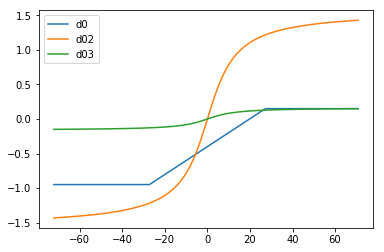

In [14]:
plt.plot(x,d0,label="d0")
plt.plot(x,d02,label="d02")
plt.plot(x,d03,label="d03")
plt.legend(loc=0)


In [15]:
## NSWE in monodomain
reload(serre)
reload(ddmNS)


#h,u = cnoidal.analyticalSolutionSolitary(x[3:-3]-.5*xmin,t,a0,a1)
h,u = cnoidal.analyticalSolutionSolitary(x-.5*xmin,t,a0,a1)
#h = serre.extend2GhostCells(h,3)
#u = serre.extend2GhostCells(u,3)
h = h-d03
#h[0:3] = h[3:6]
#h[-3:] = h[-6:-3]


print(x.size,h.size,u.size)
hall,uall,tall = serre.NSWE(x,h,u,t0,tmax,ddmNS.openDomainThreeGC,None,dx,x.size,vardt = False, dt = dt,
                              fvsolver=ddmNS.fluxes, ghostcells=3,fvTimesolver=serre.Euler)

umin = np.amin(uall)
umax = np.amax(uall)
hmin = np.amin(hall)
hmax = np.amax(hall)

## store referential solution
xM = np.copy(x)
uallM = np.copy(uall)
hallM = np.copy(hall)
tallM = np.copy(tall)

(106, 106, 106)
CFL = 0.003951


In [16]:
hmax

1.184763838250498

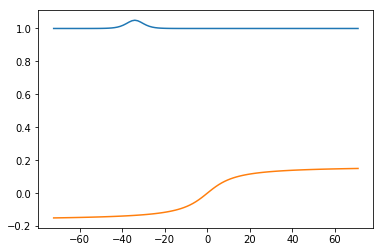

In [17]:
plt.plot(x,h+d03)
plt.plot(x,d03)

In [18]:
## FOR PRINTING
### store d0 for all instants
### add d0 to h to obtain the surface elevation

hallMP = np.copy(hall)
d0all = np.copy(hall)

for i in range (tall.size):
    d0all[:,i] = d03
    hallMP[:,i] = hallM[:,i] + d03

*** Plotting animation ...



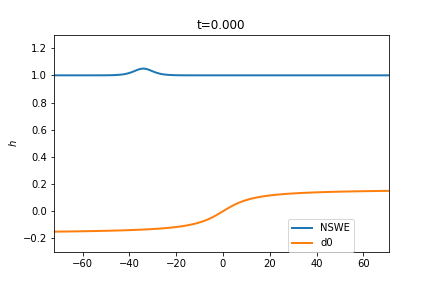
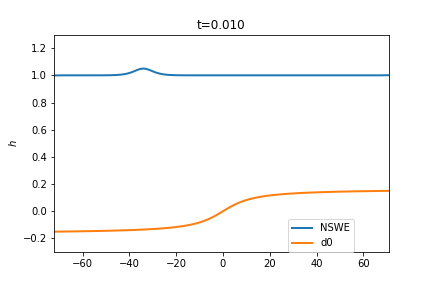
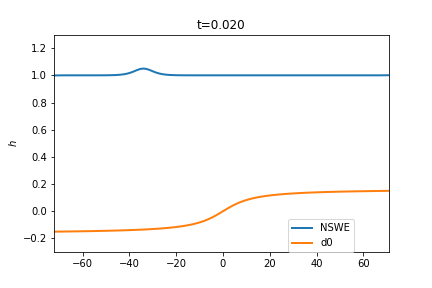
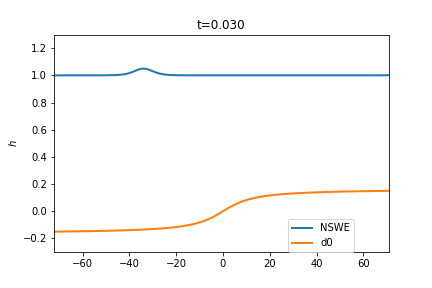
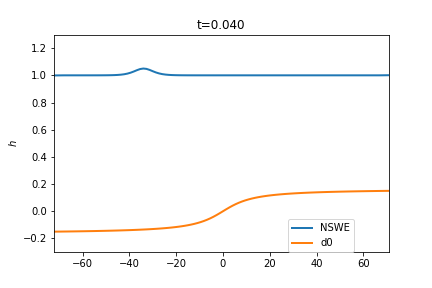
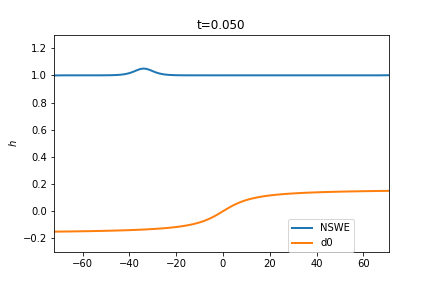
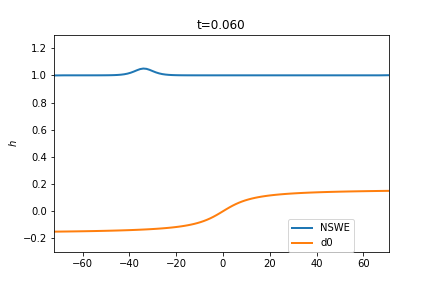
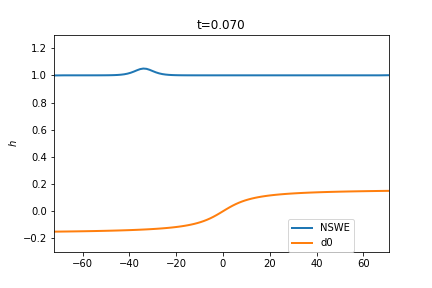
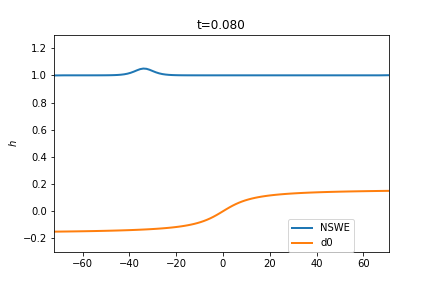
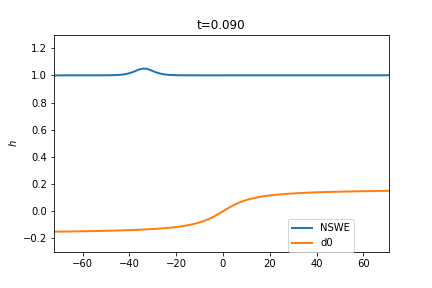
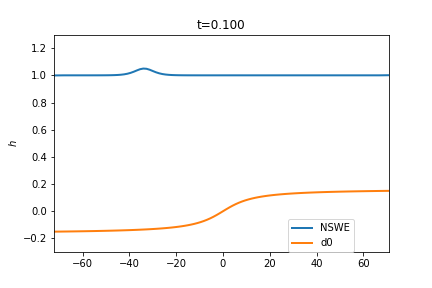
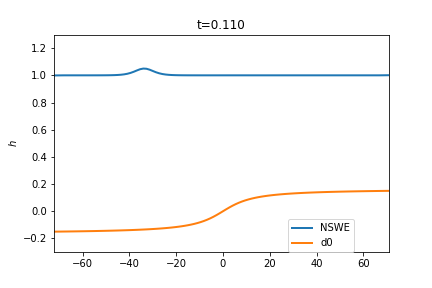
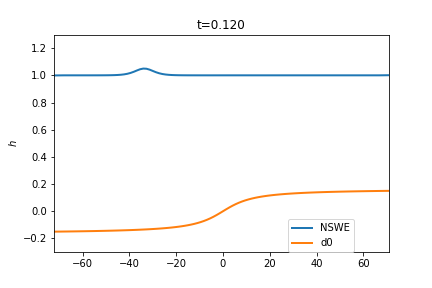
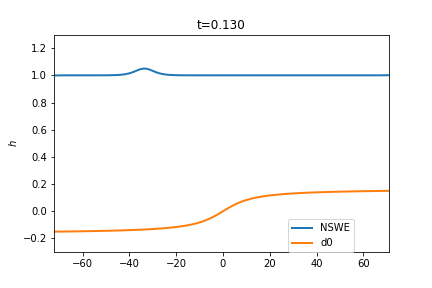
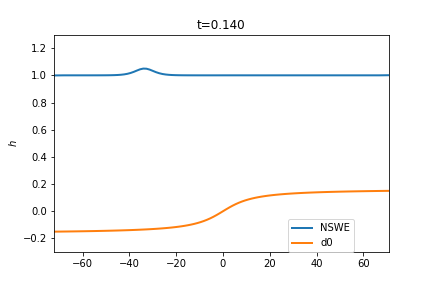
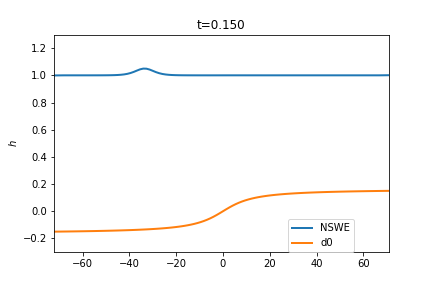
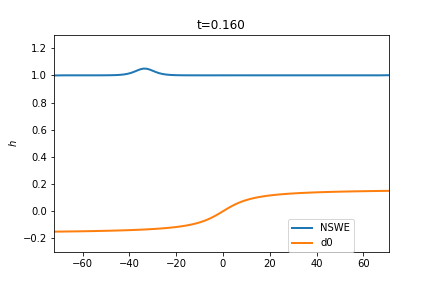
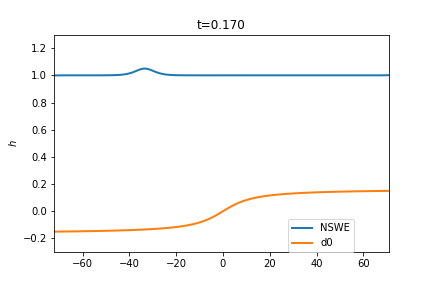
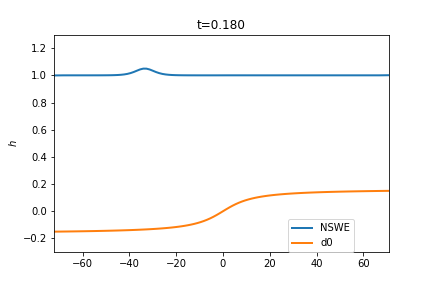
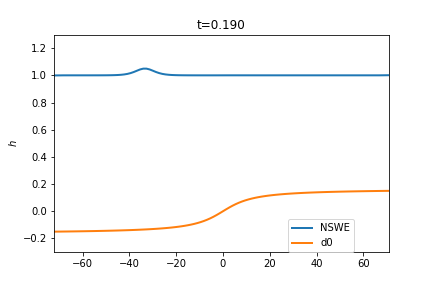
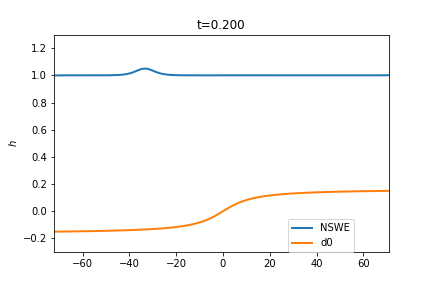
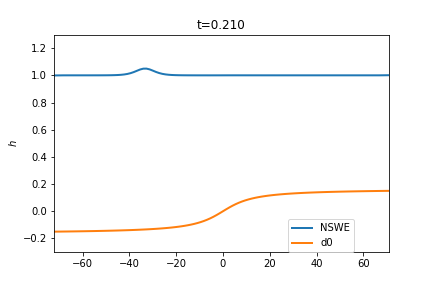
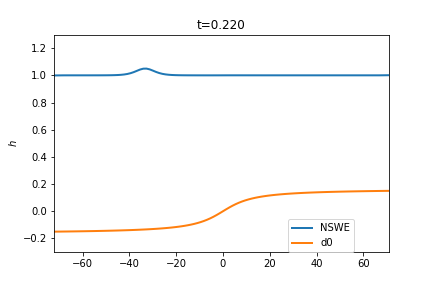
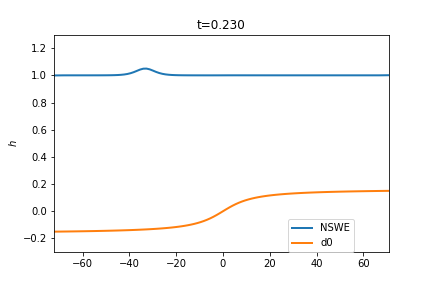
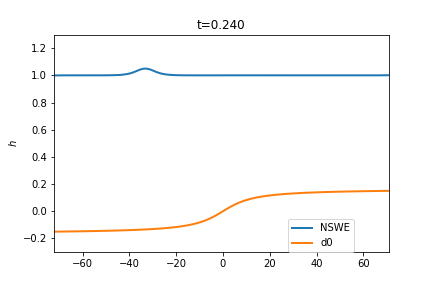
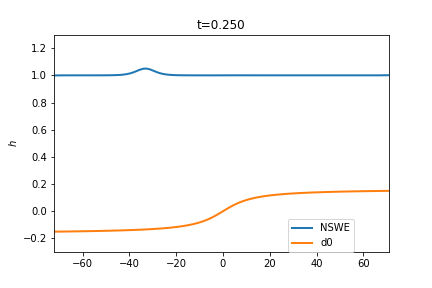
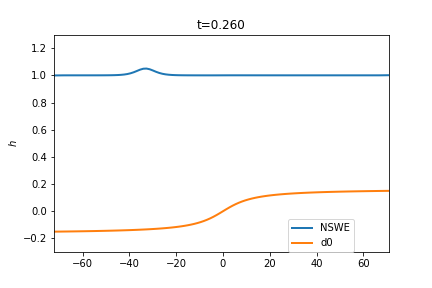
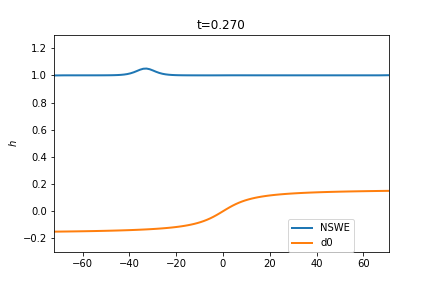
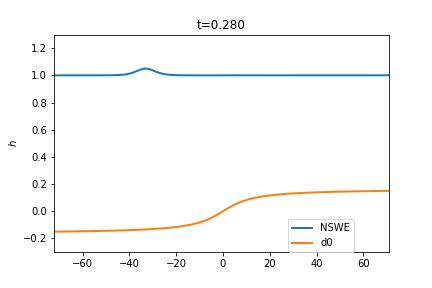
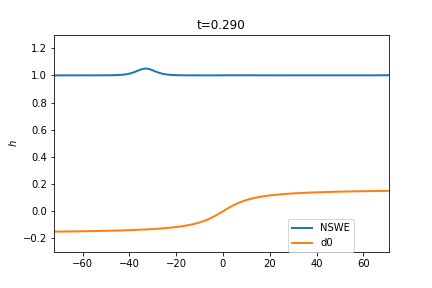
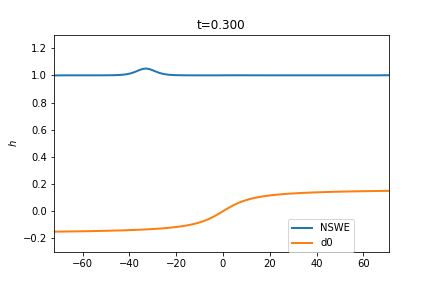
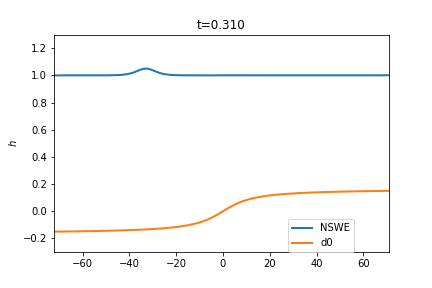
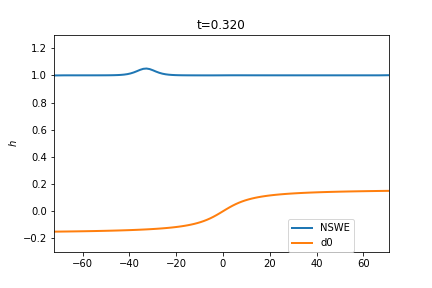
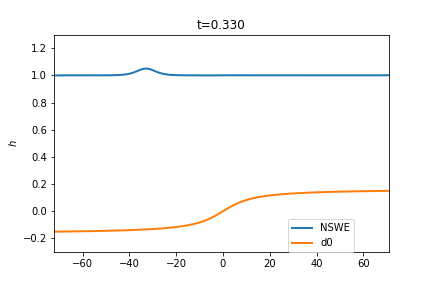
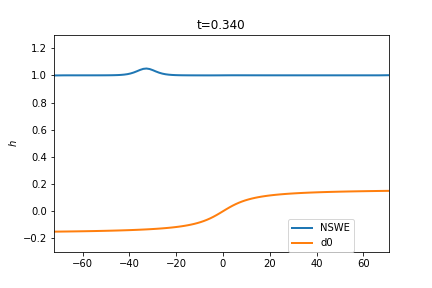
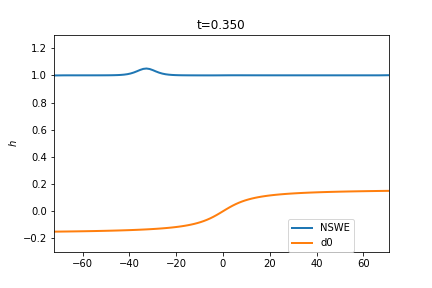
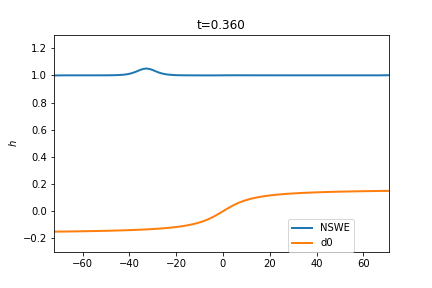
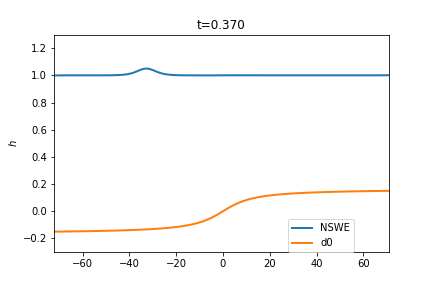
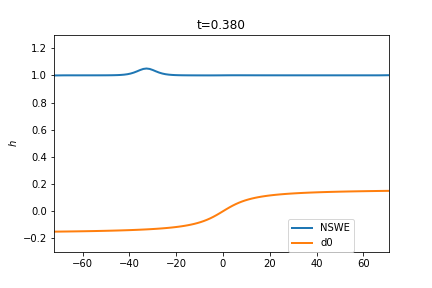
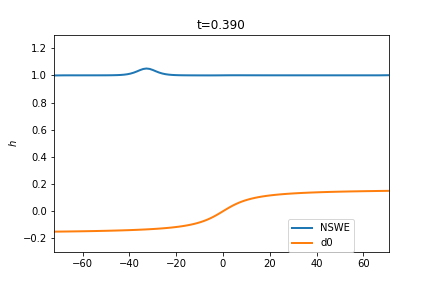
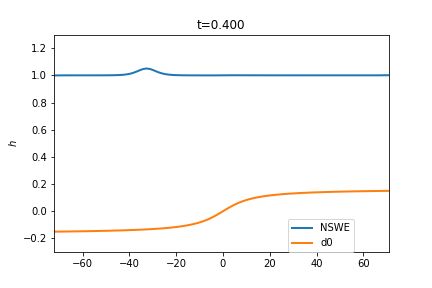
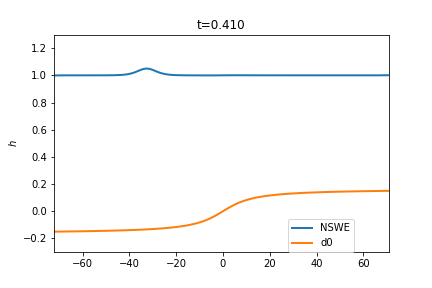
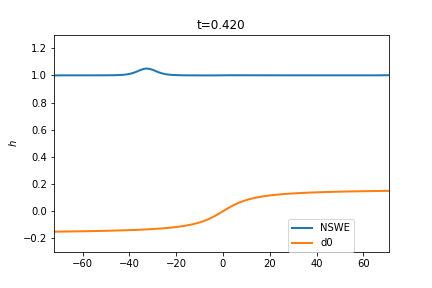
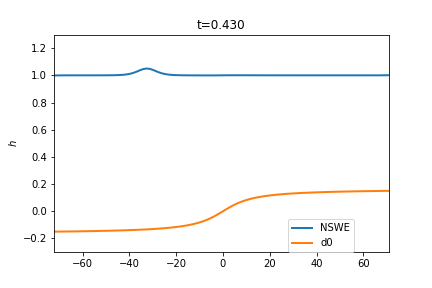
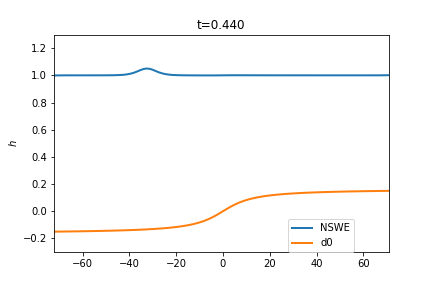
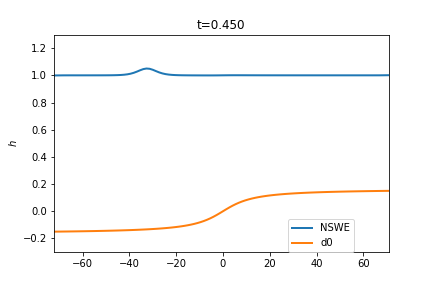
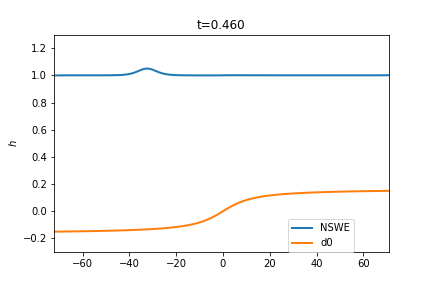
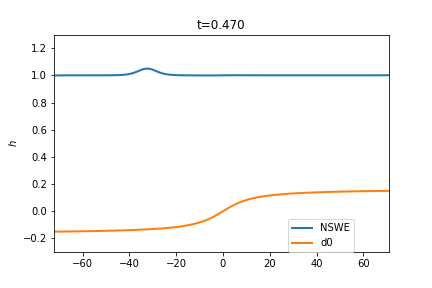
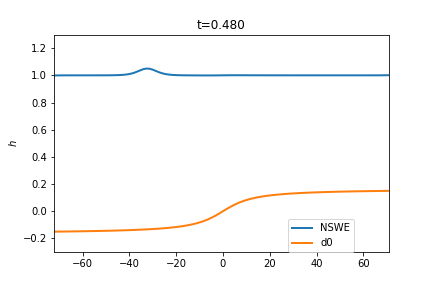
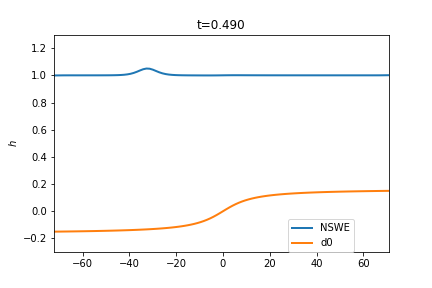
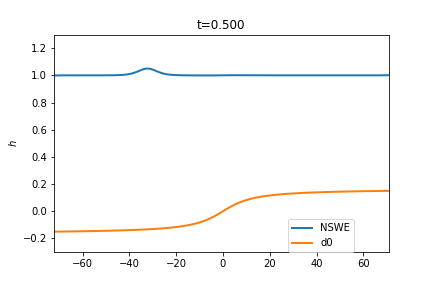
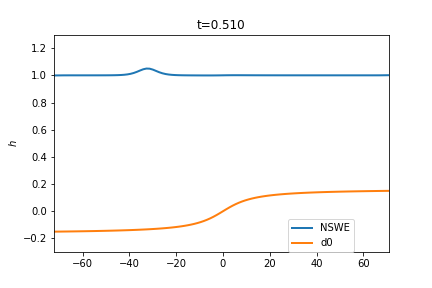
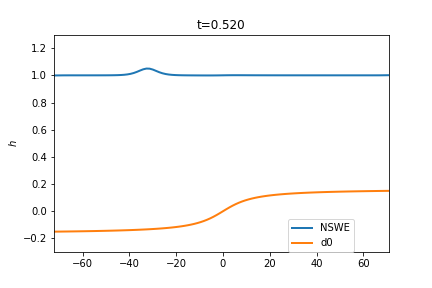
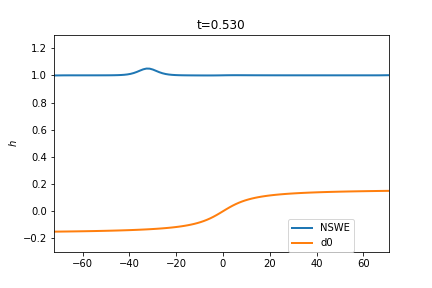
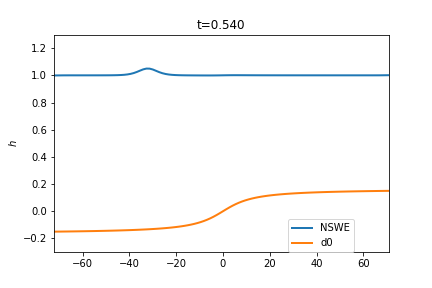
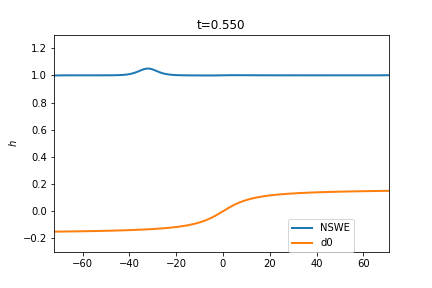
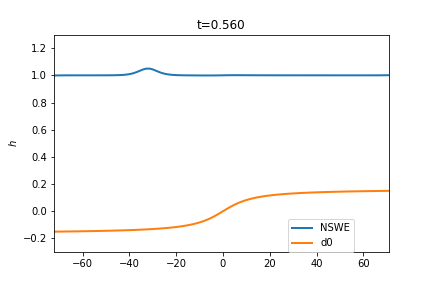
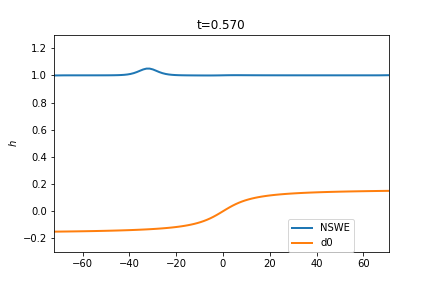
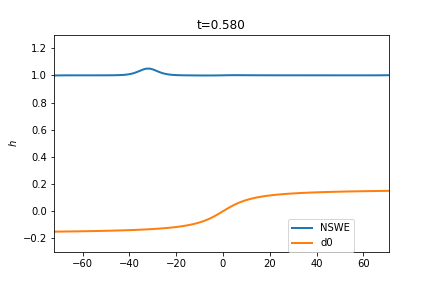
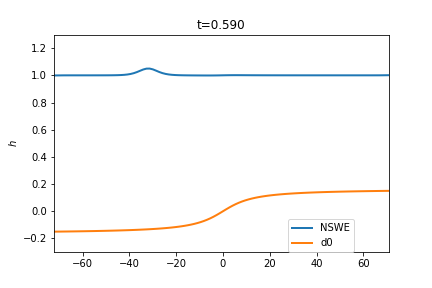
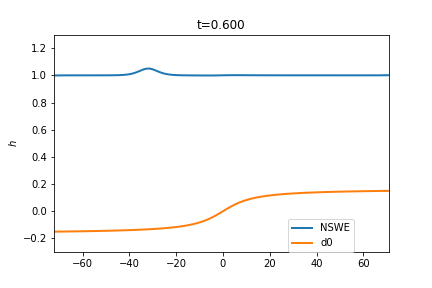
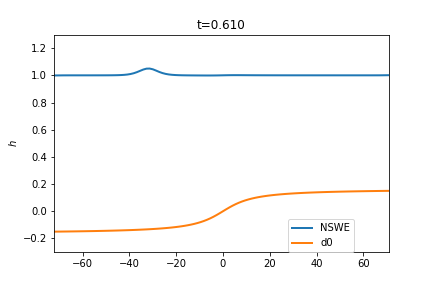
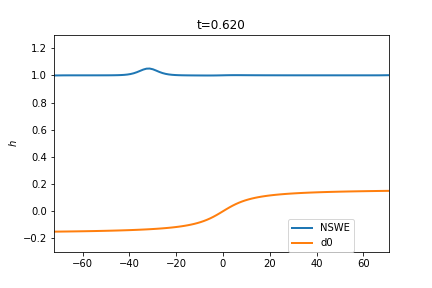
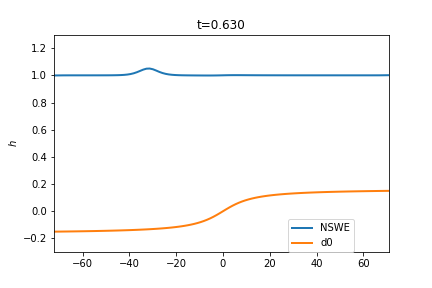
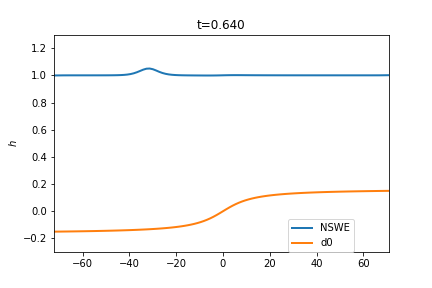
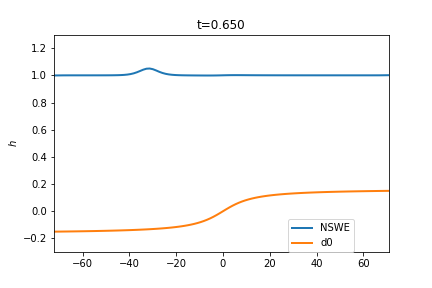
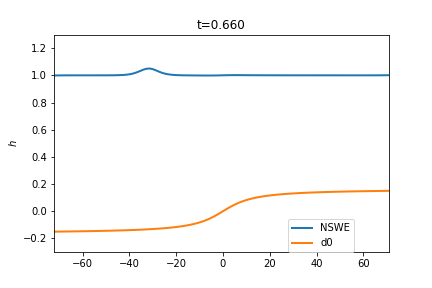
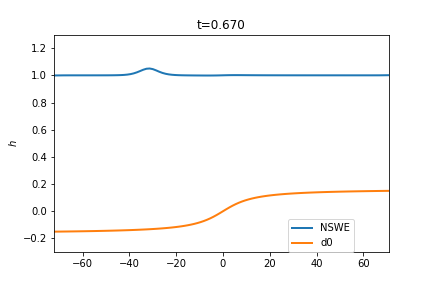
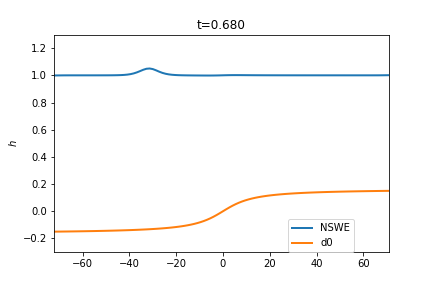
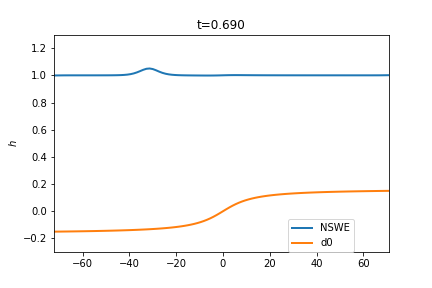
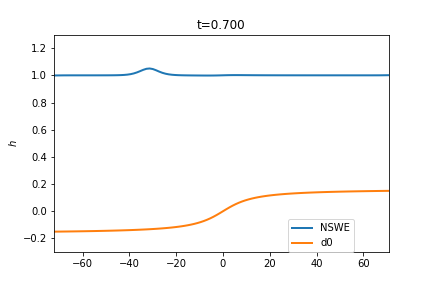
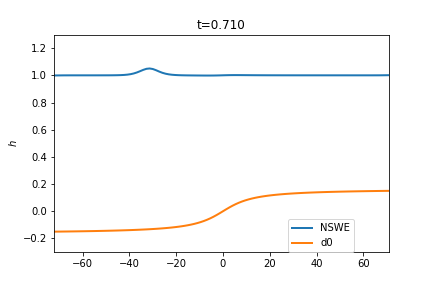
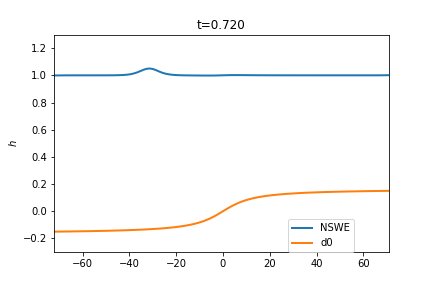
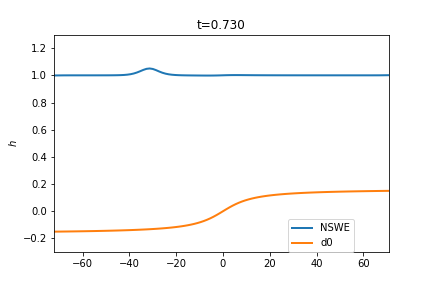
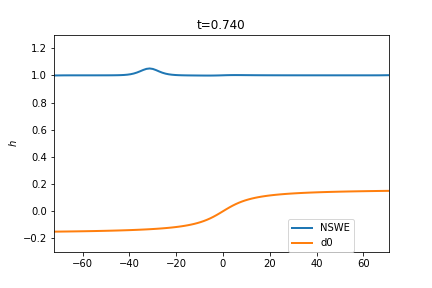
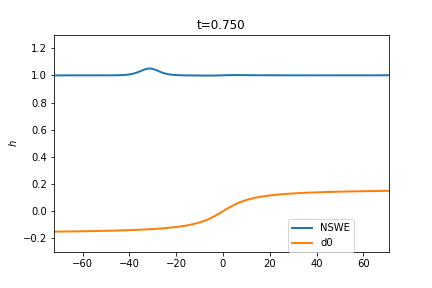
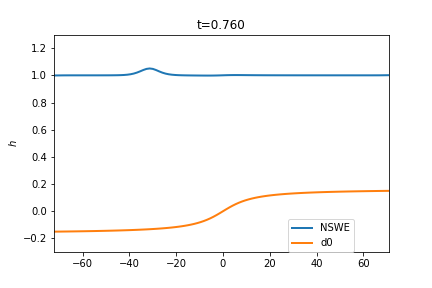
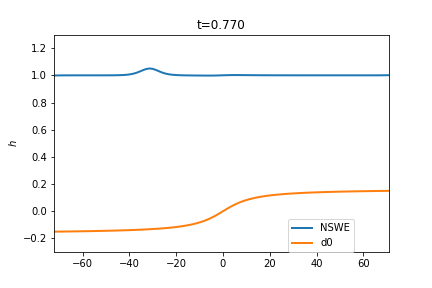
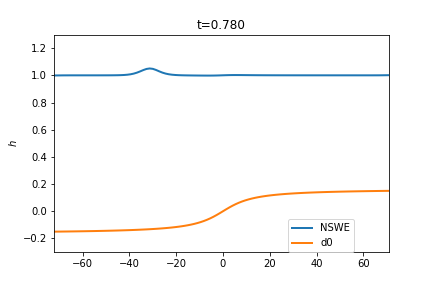
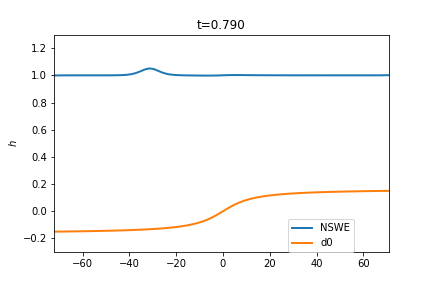
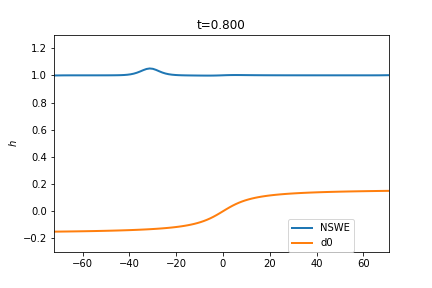
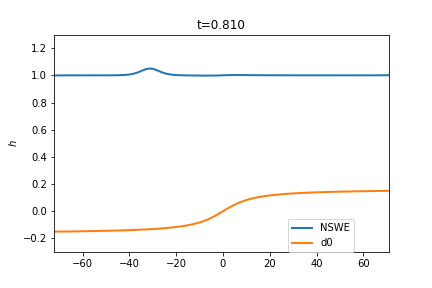
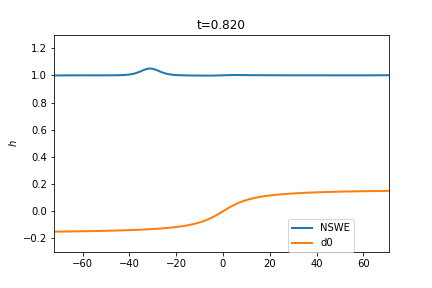
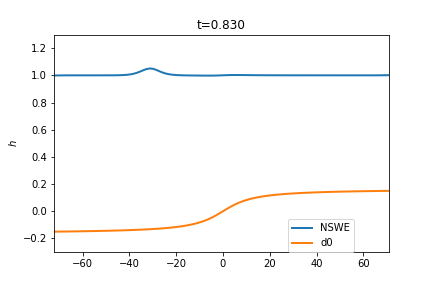
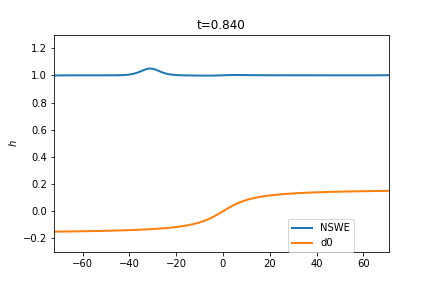
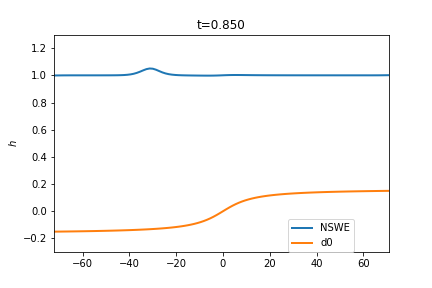
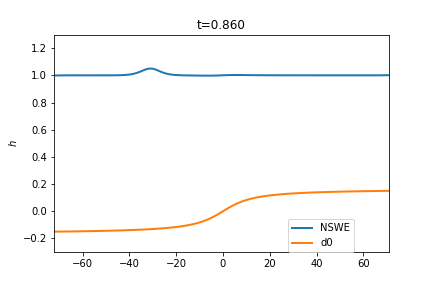
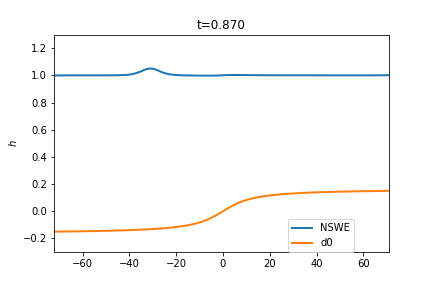
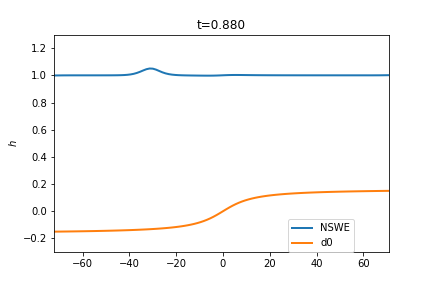
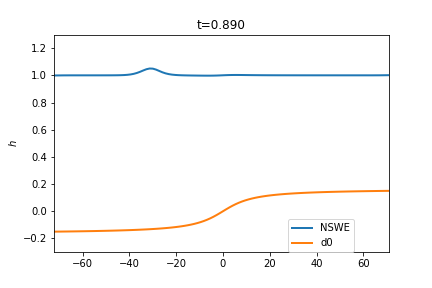
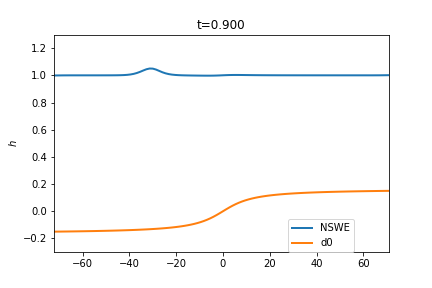
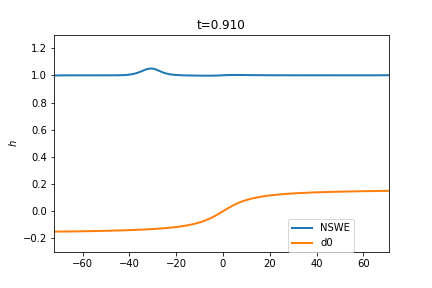
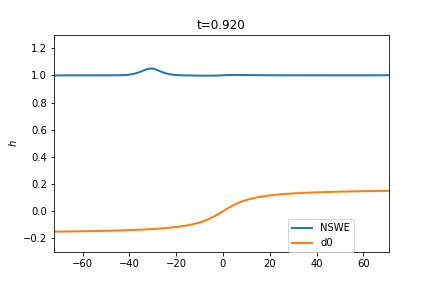
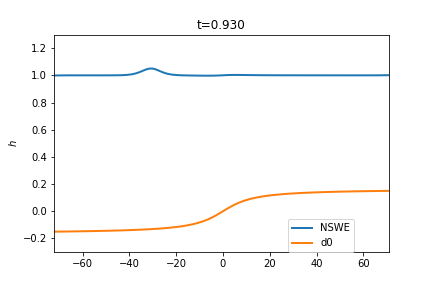
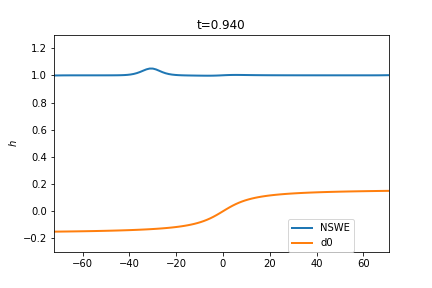
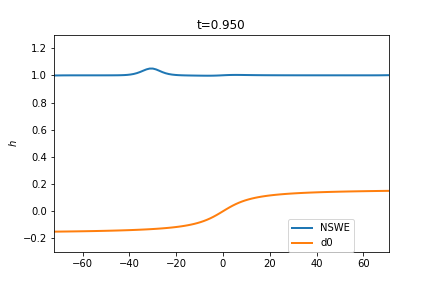
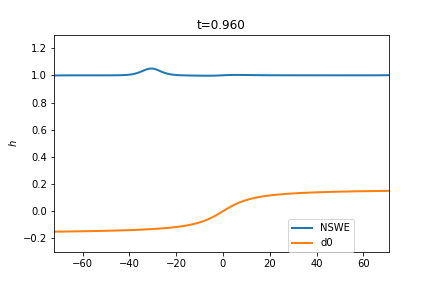
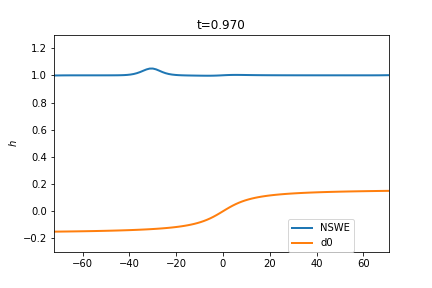
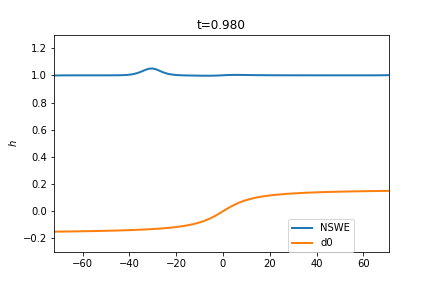
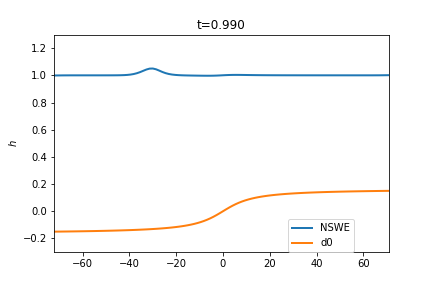
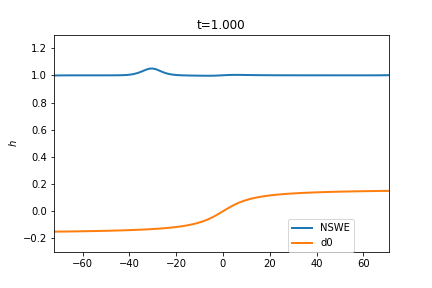
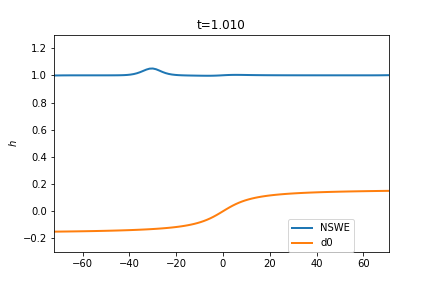
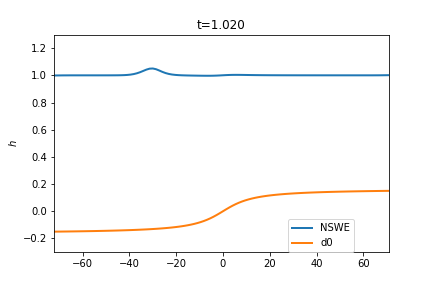
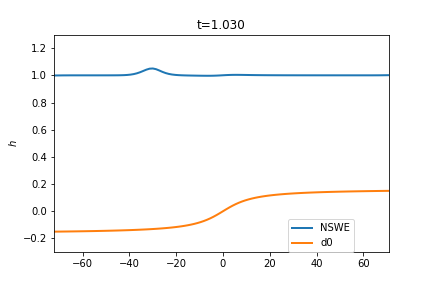
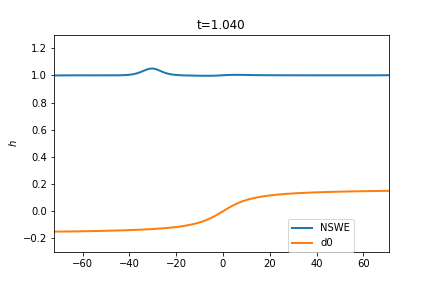
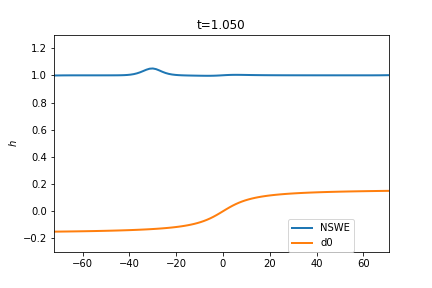
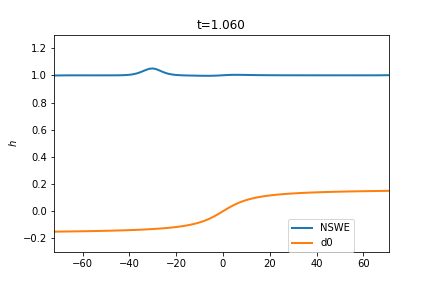
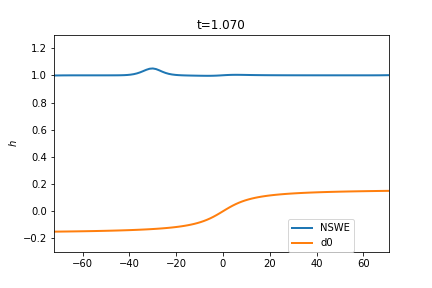
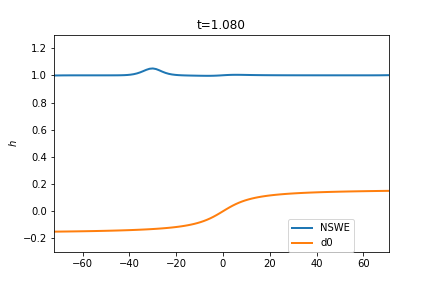
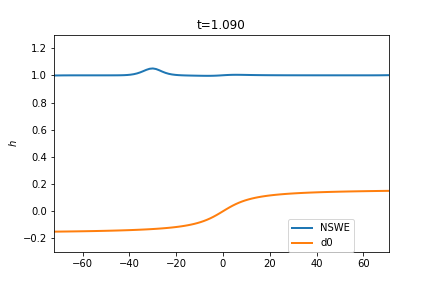
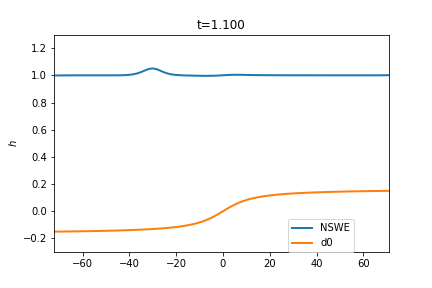
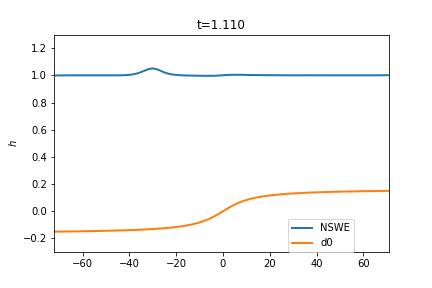
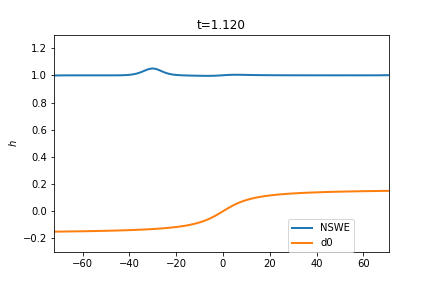
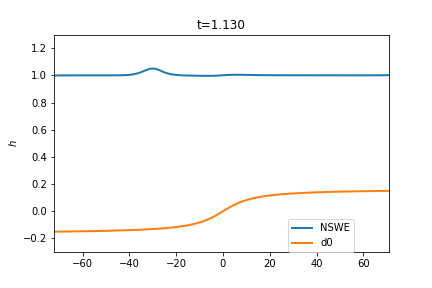
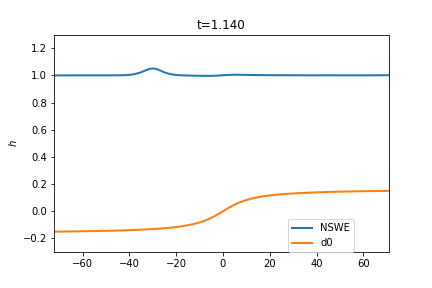
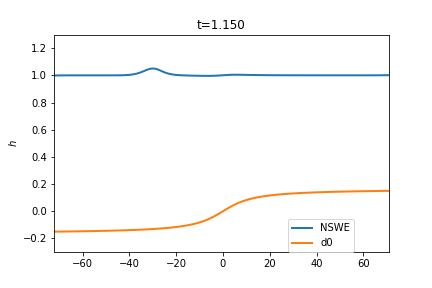
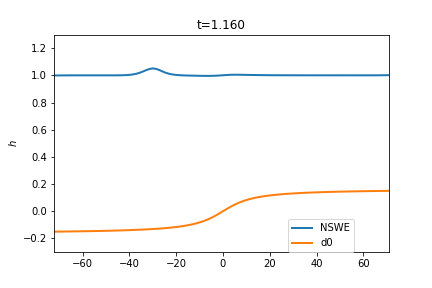
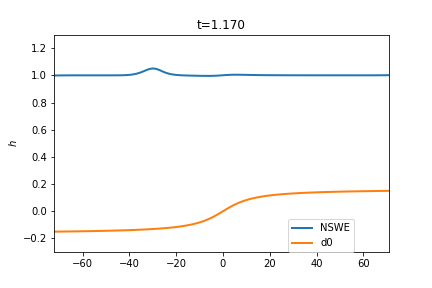
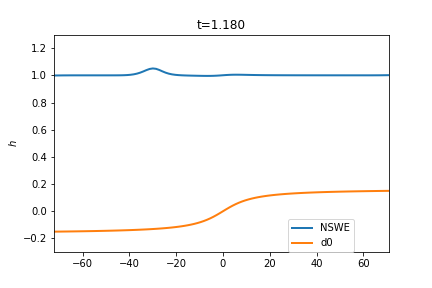
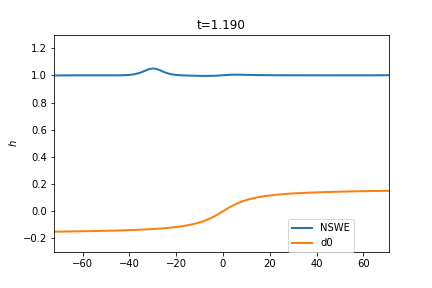
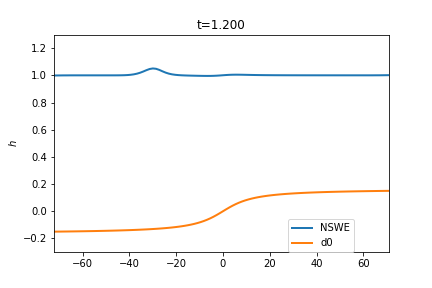
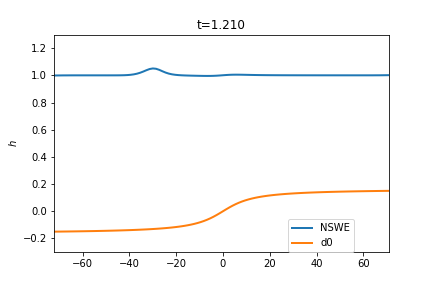
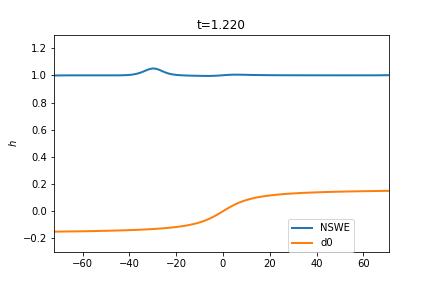
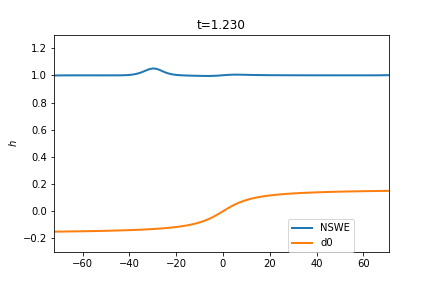
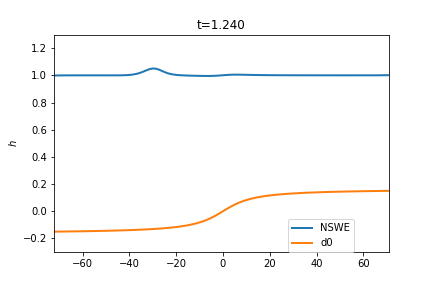
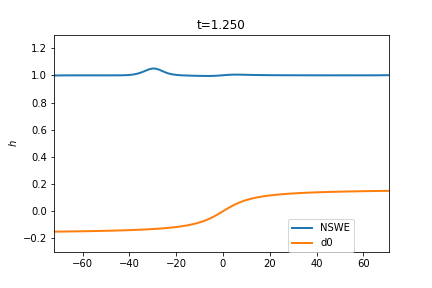
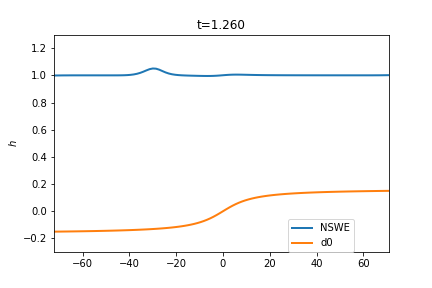
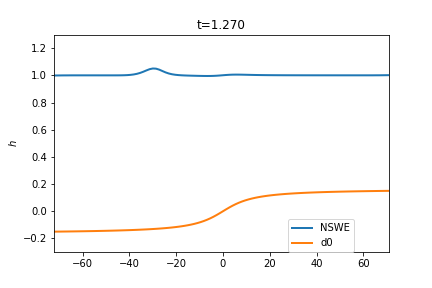
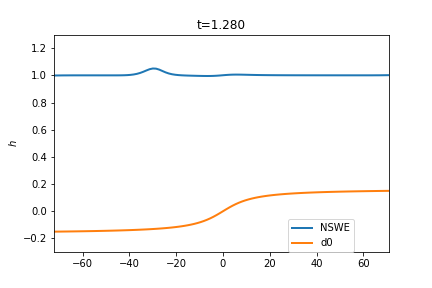
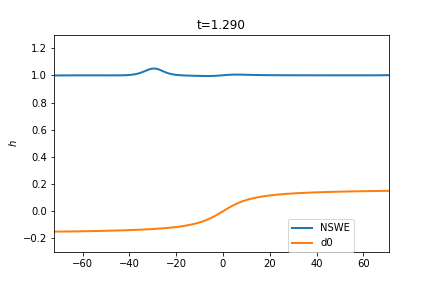
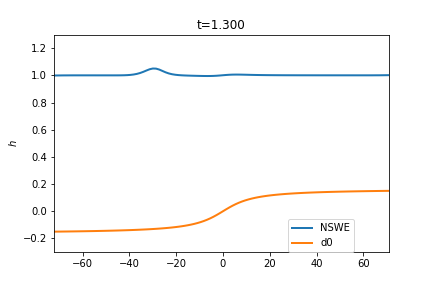
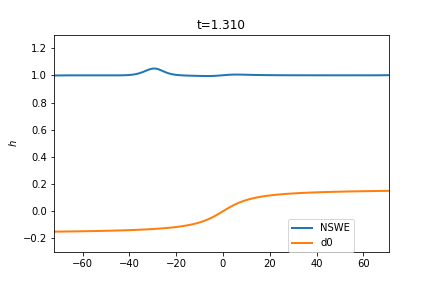
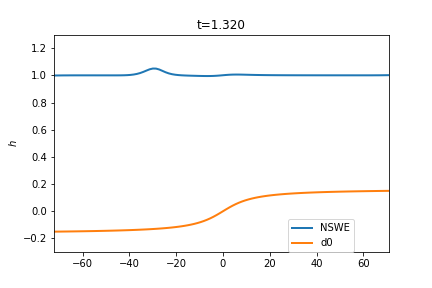
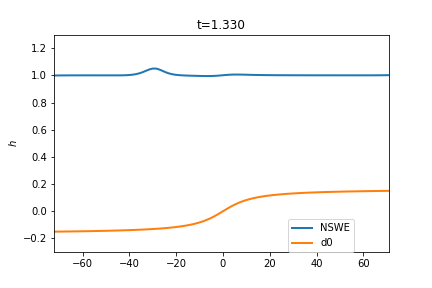
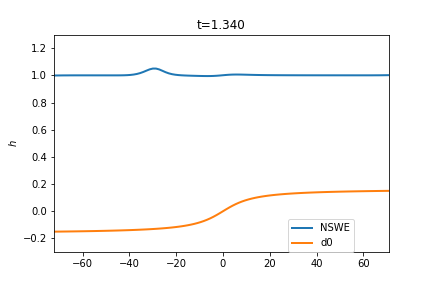
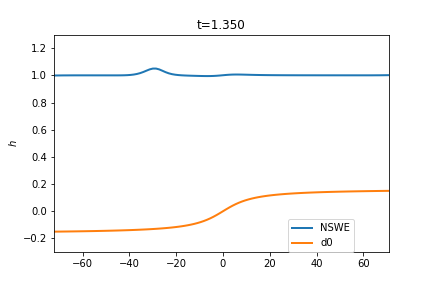
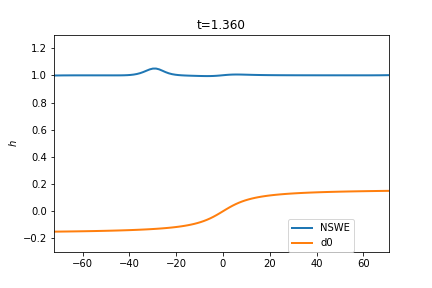
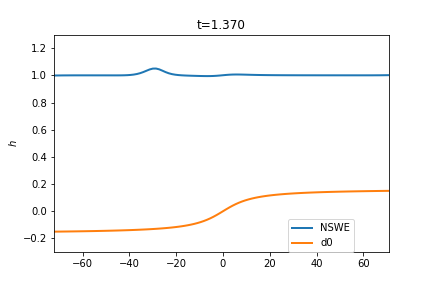
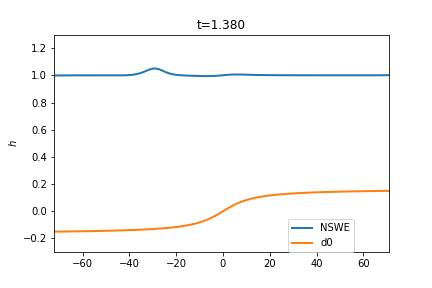
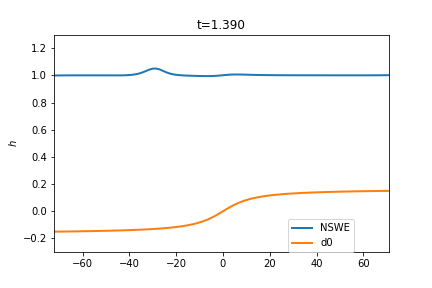
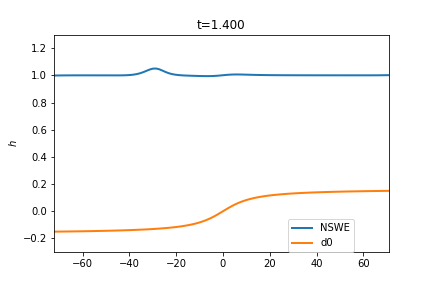
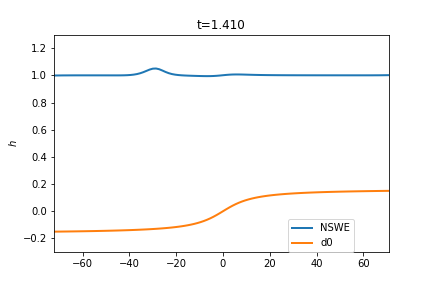
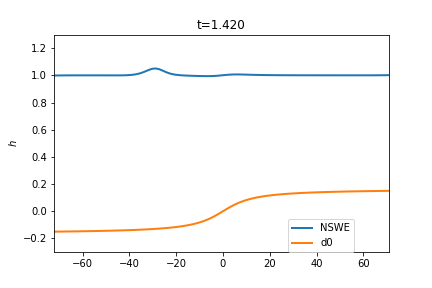
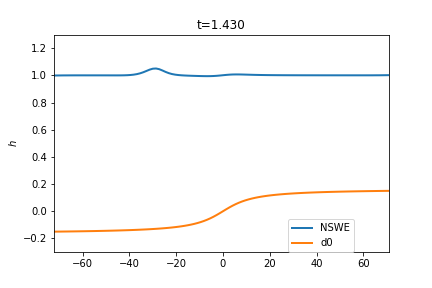
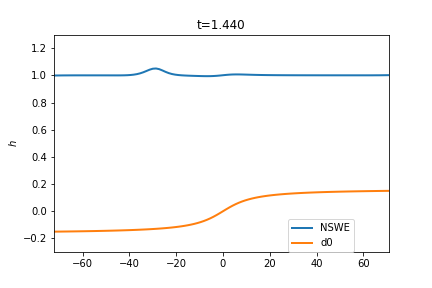
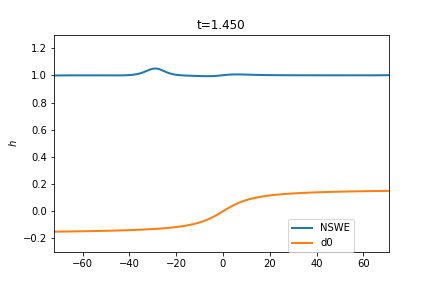
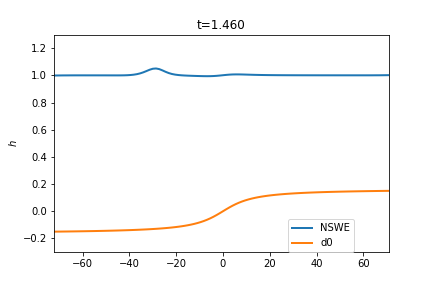
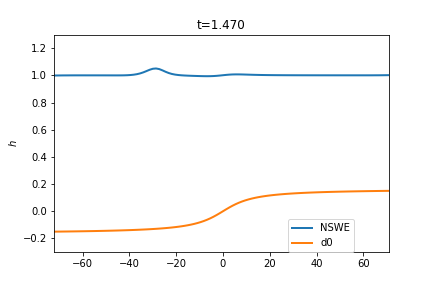
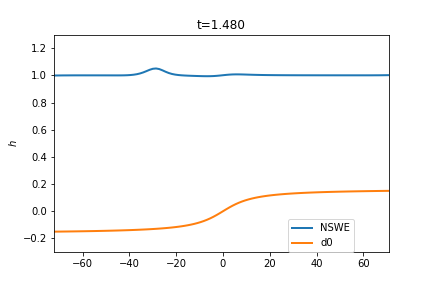
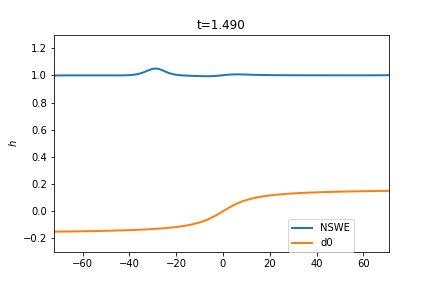
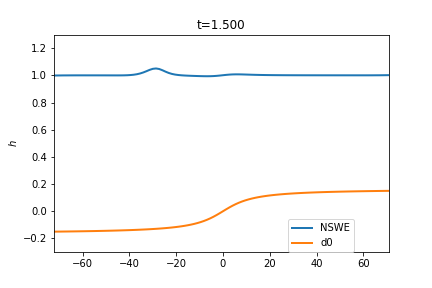
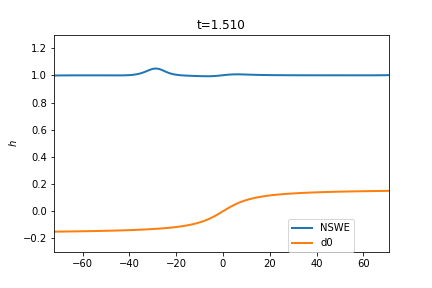
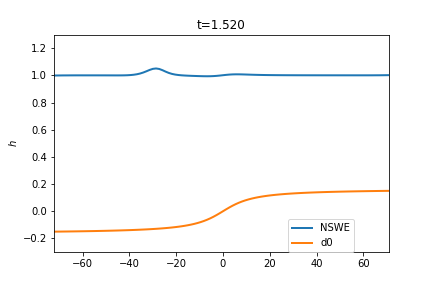
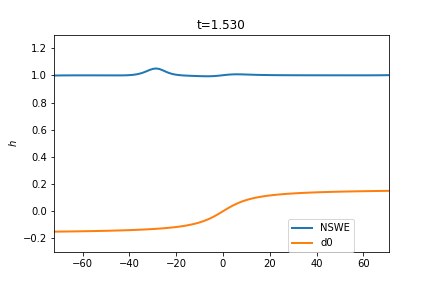
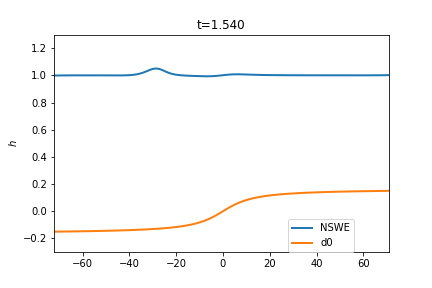
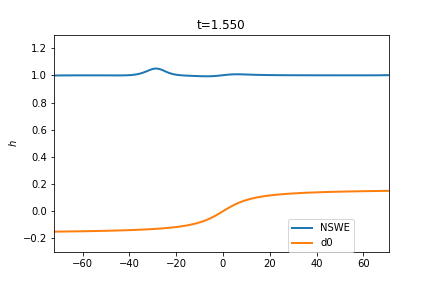
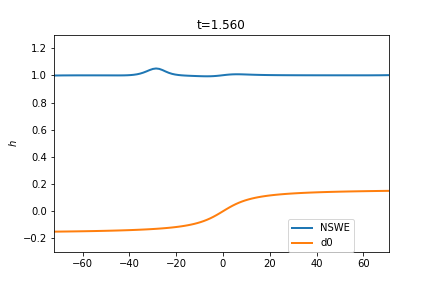
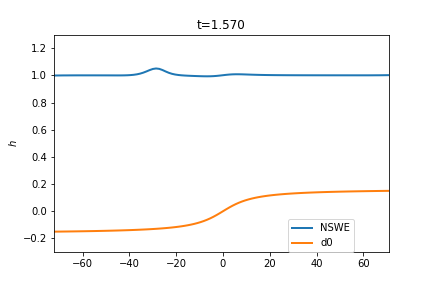
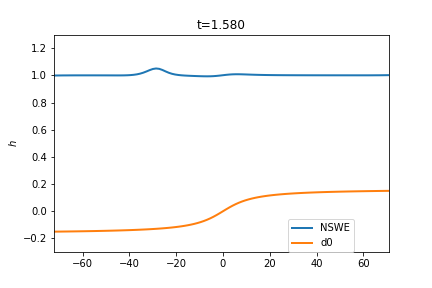
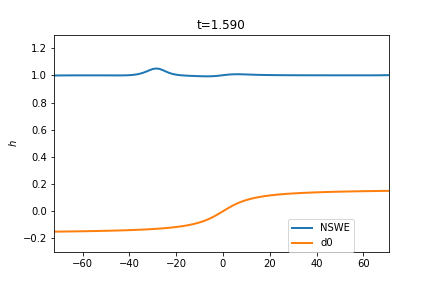
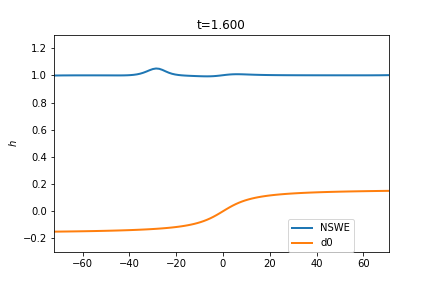
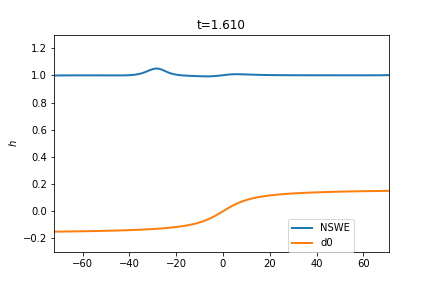
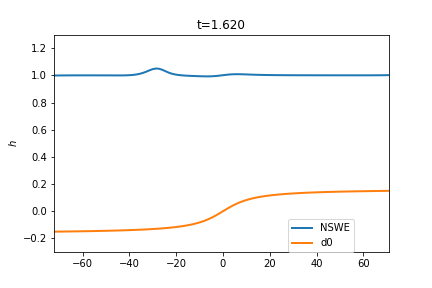
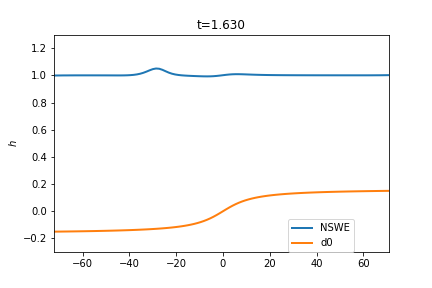
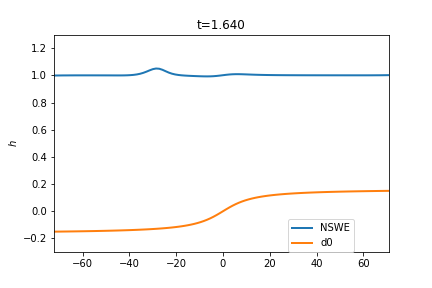
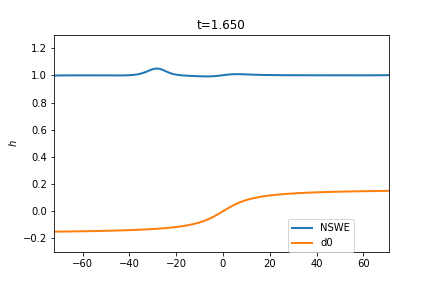
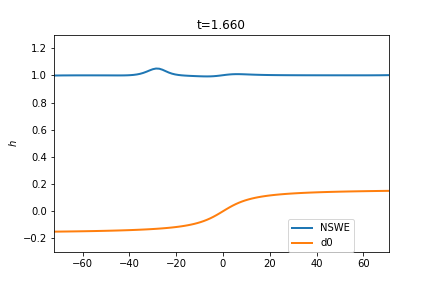
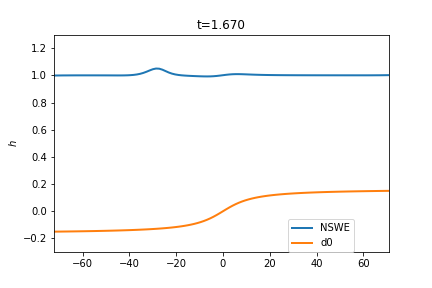
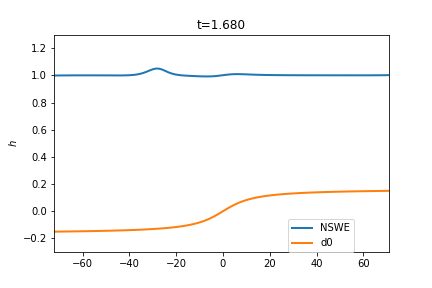
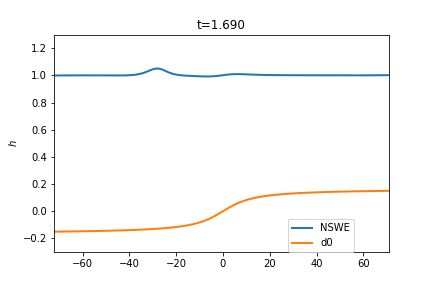
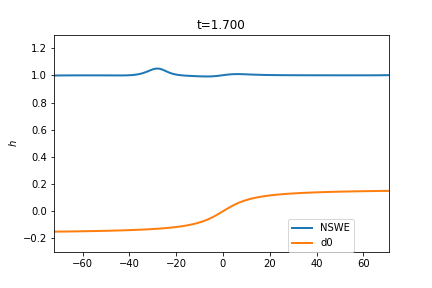
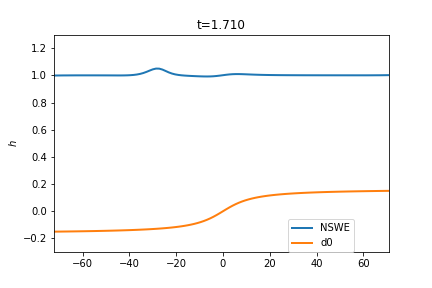
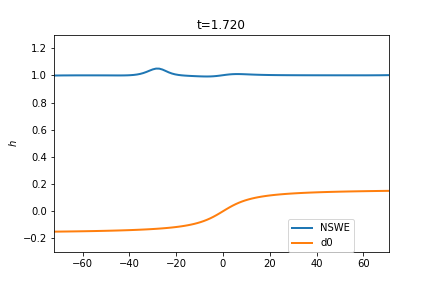
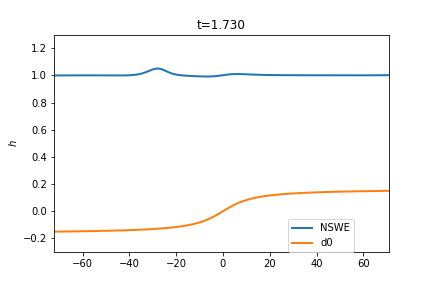
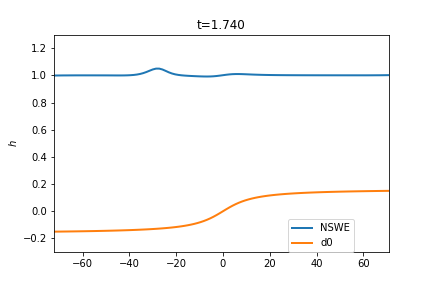
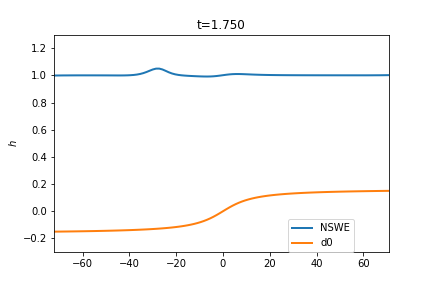
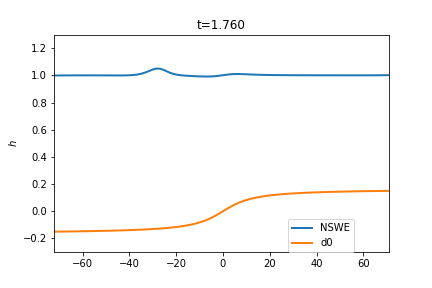
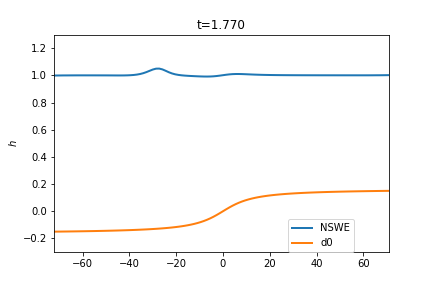
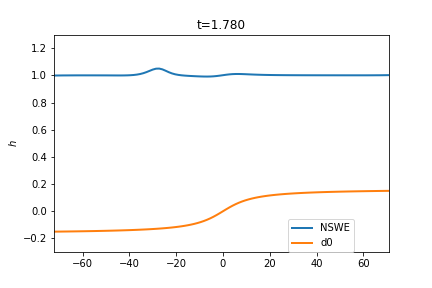
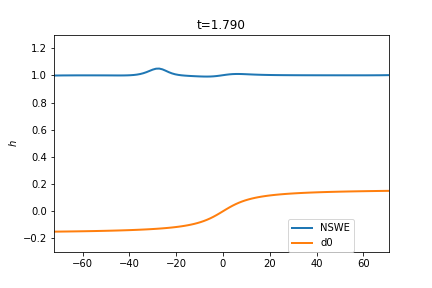
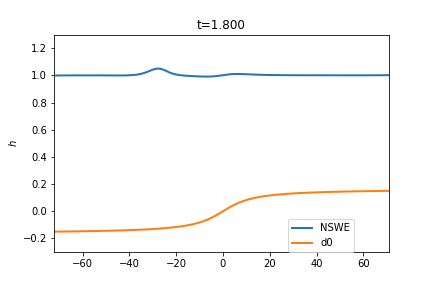
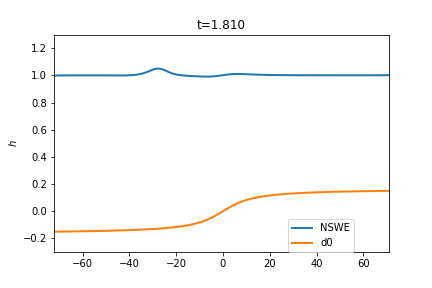
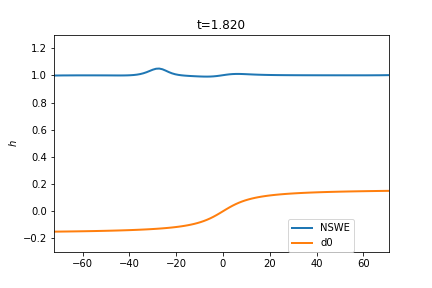
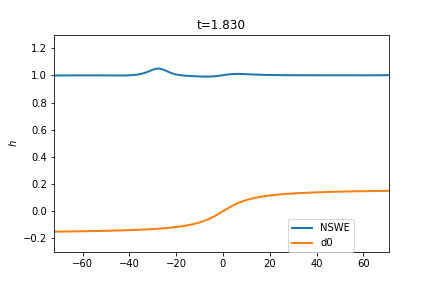
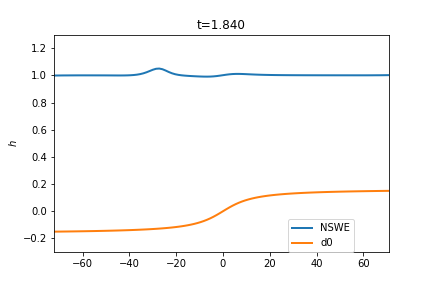
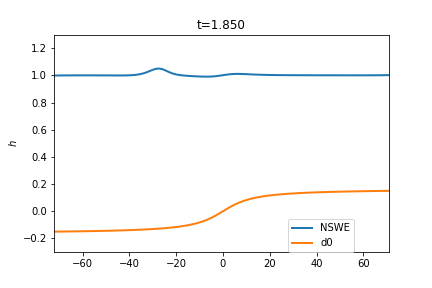
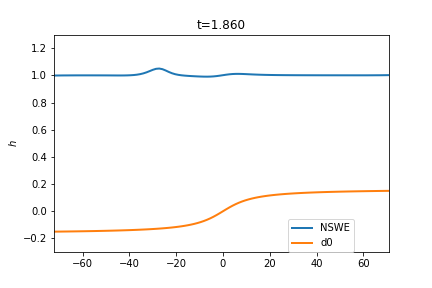
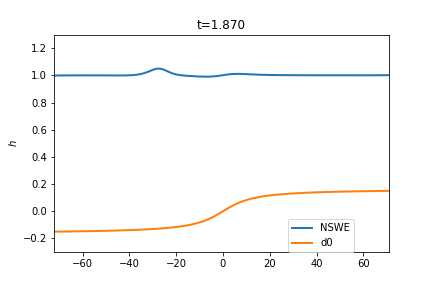
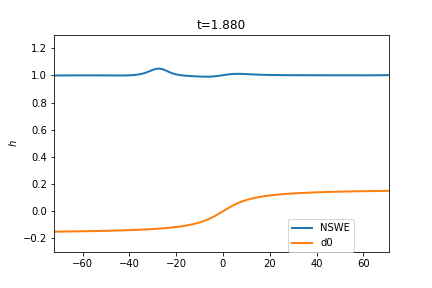
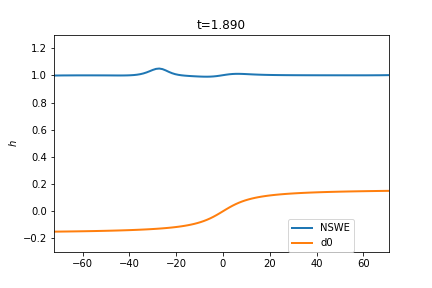
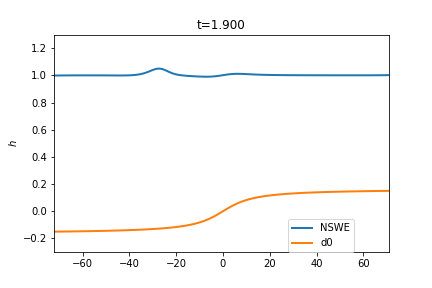
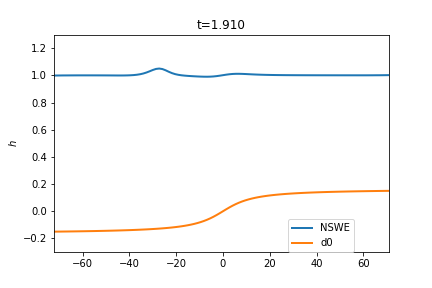
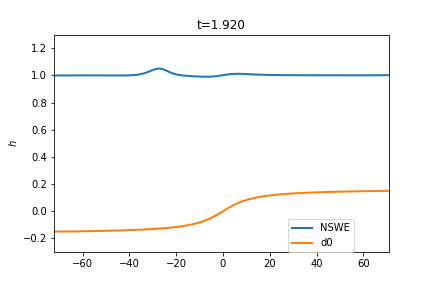
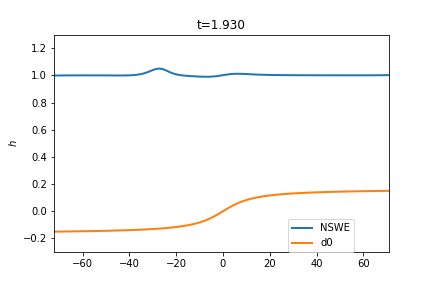
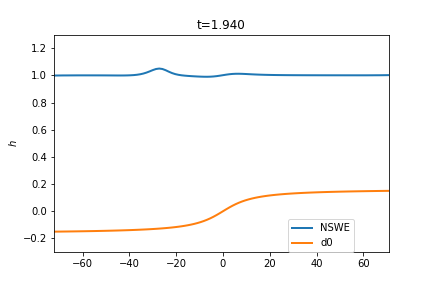
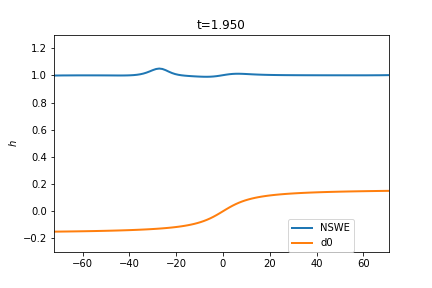
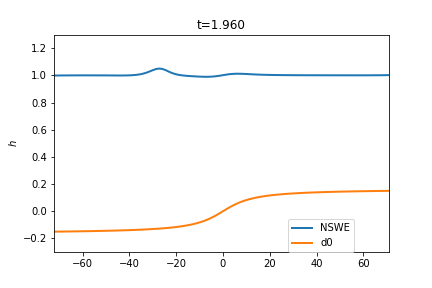
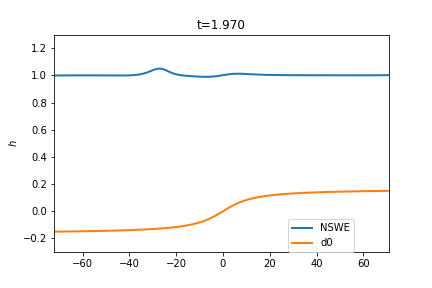
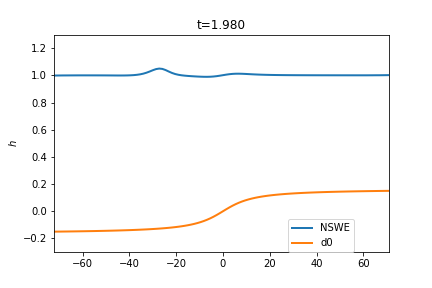
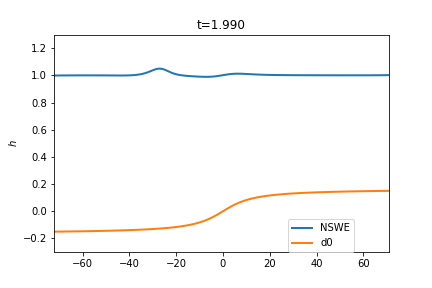
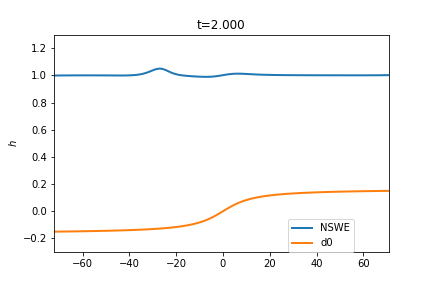
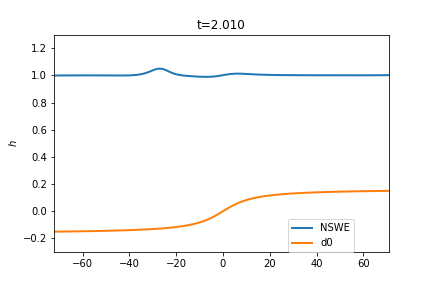
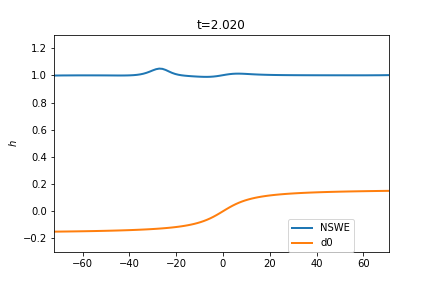
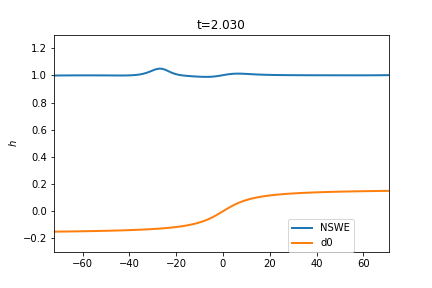
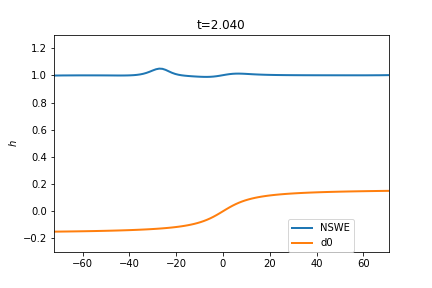
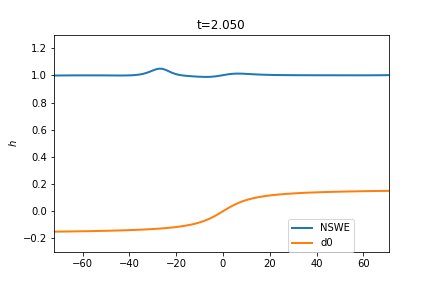
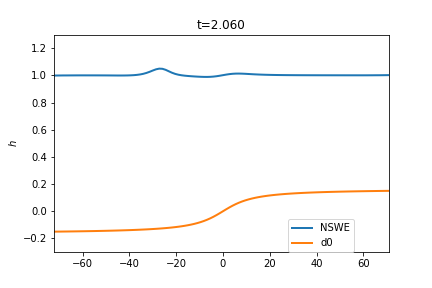
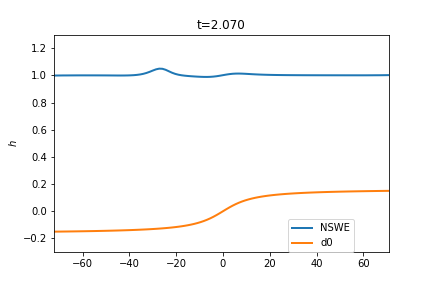
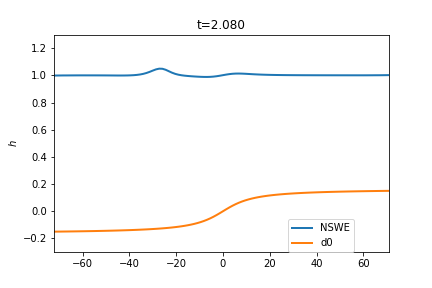
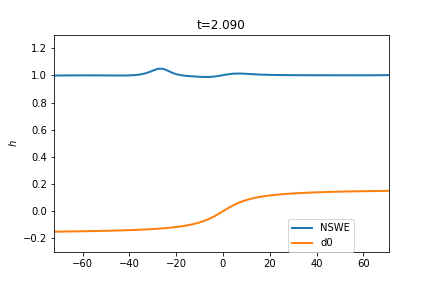
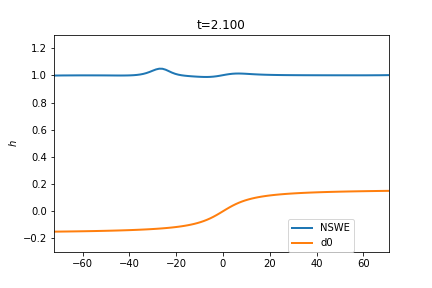
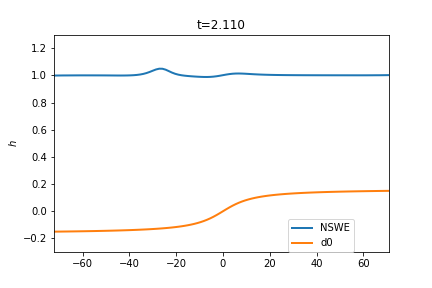
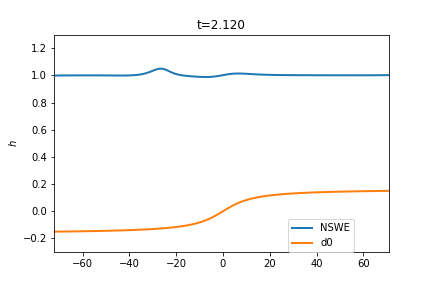
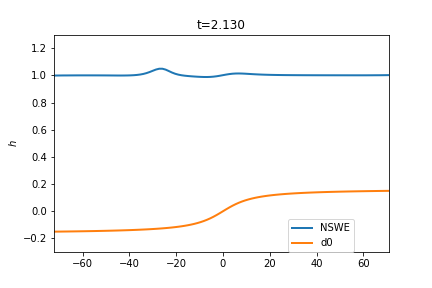
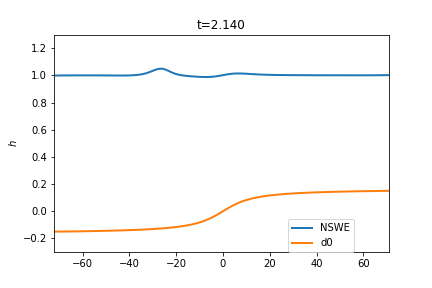
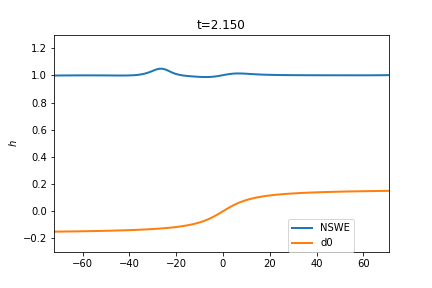
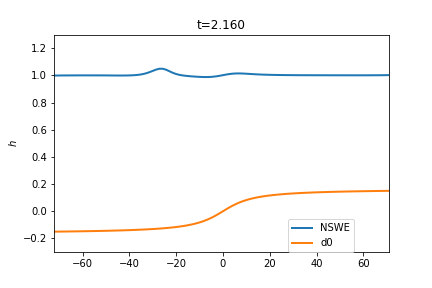
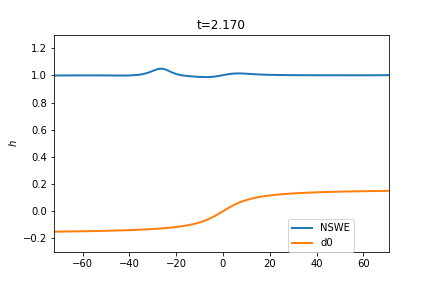
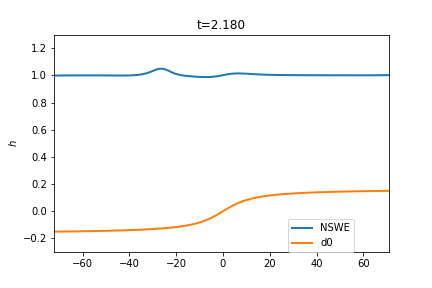
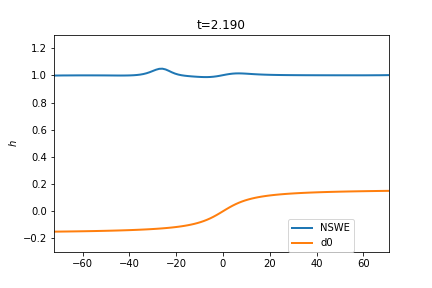
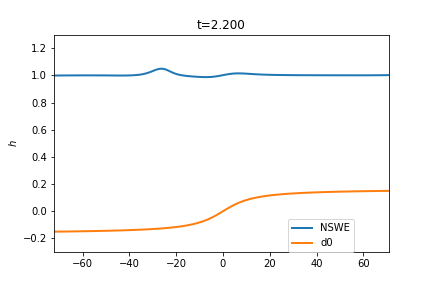
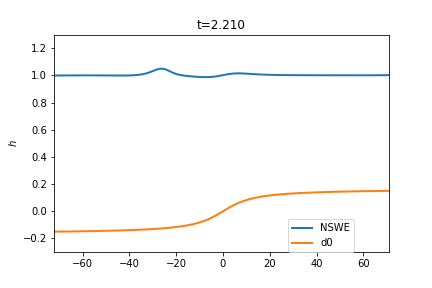
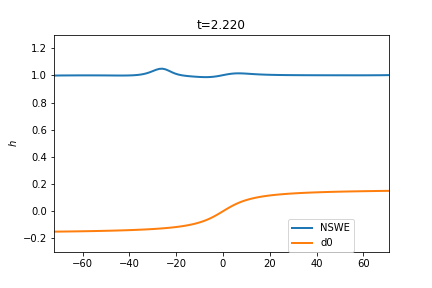
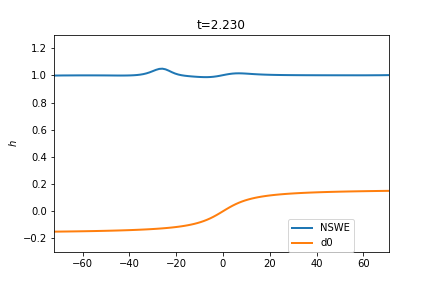
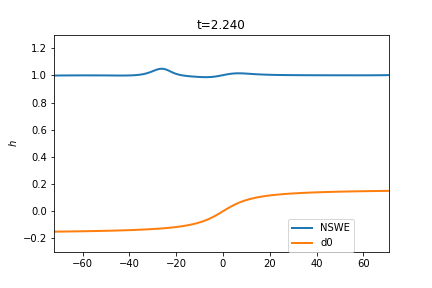
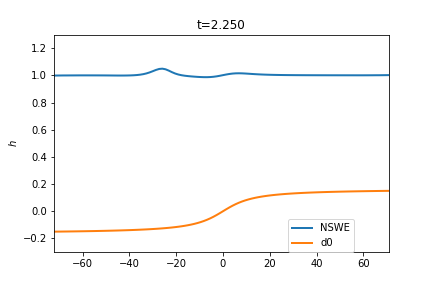
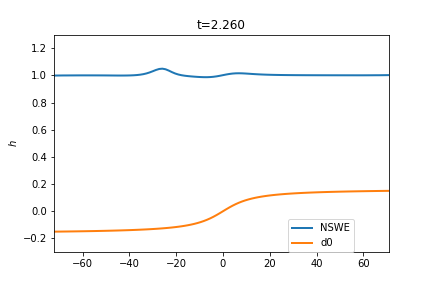
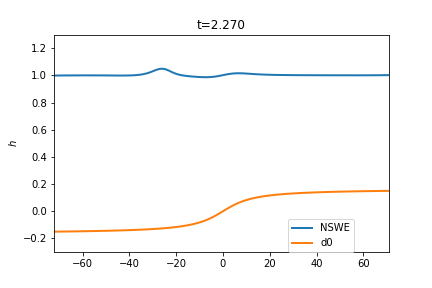
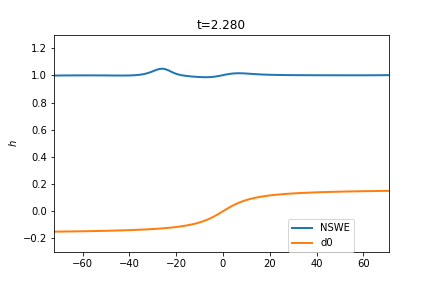
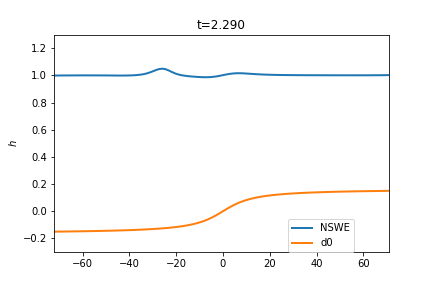
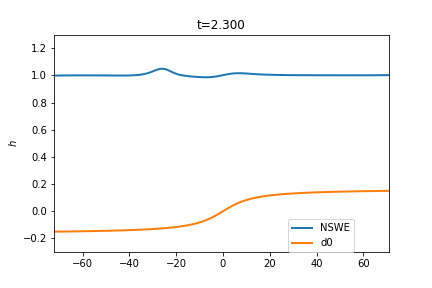
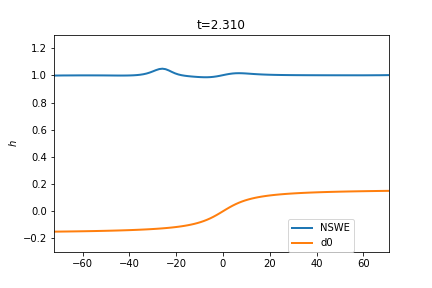
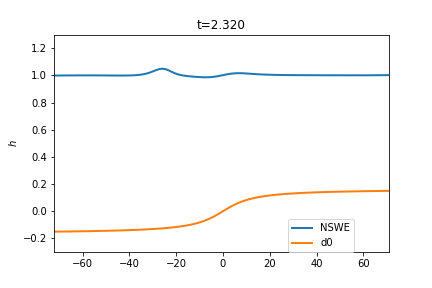
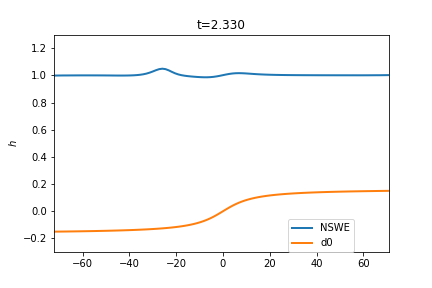
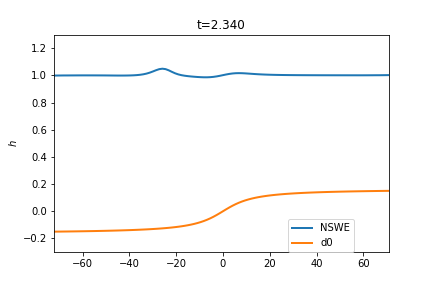
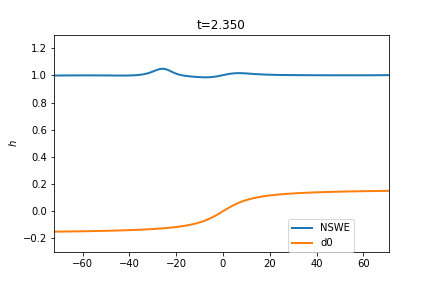
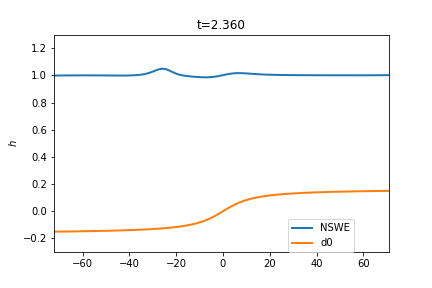
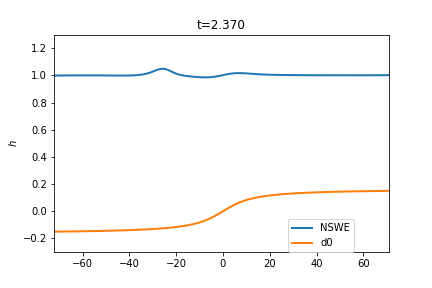
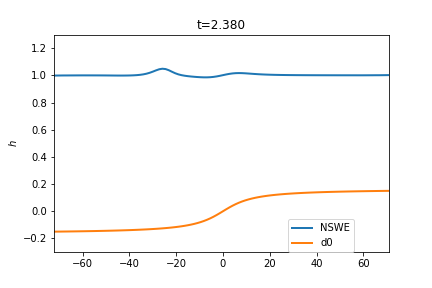
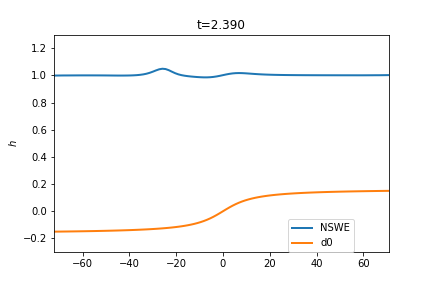
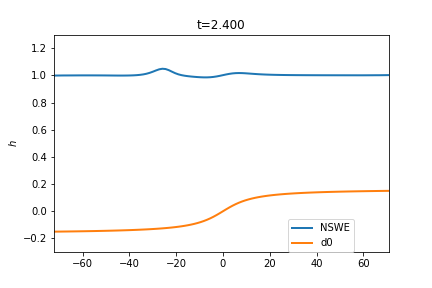
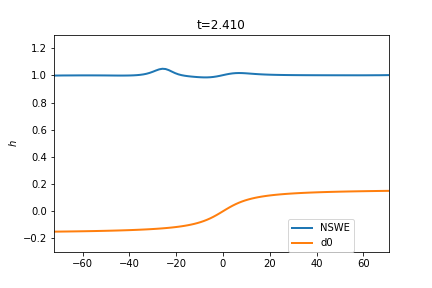
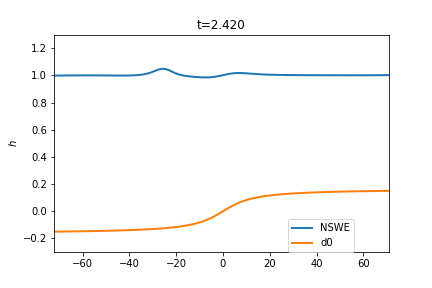
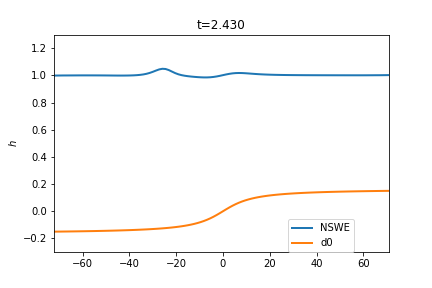
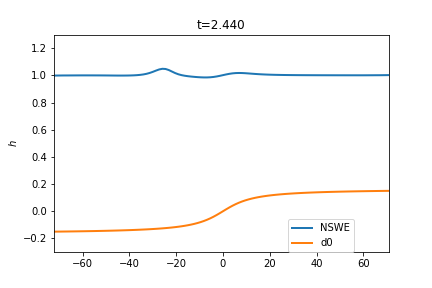
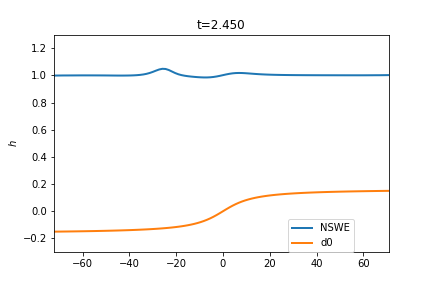
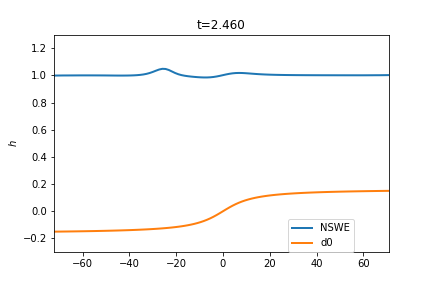
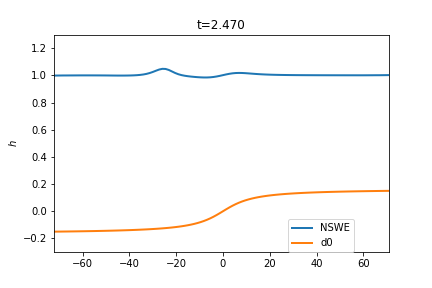
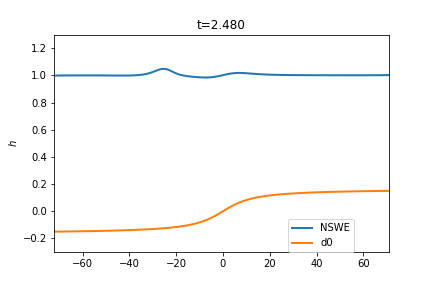
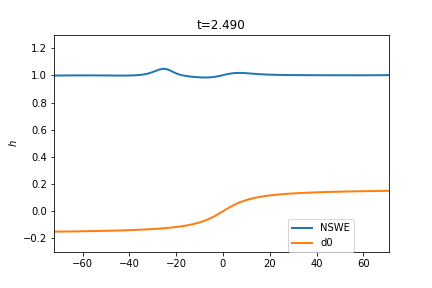
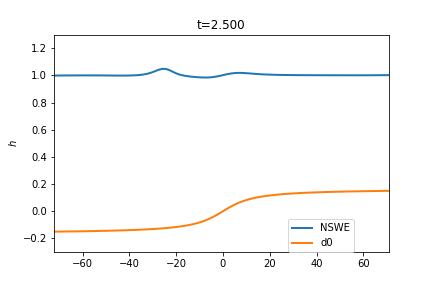
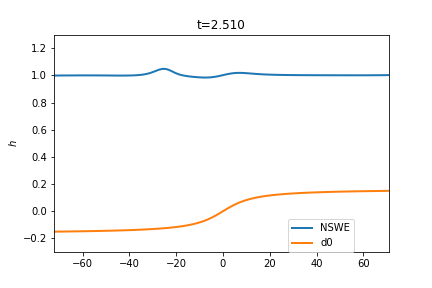
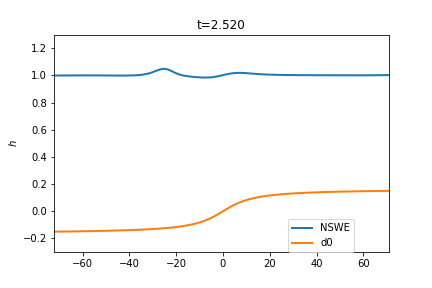
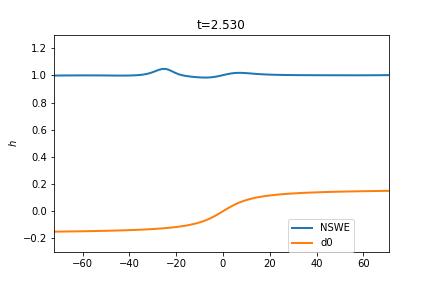
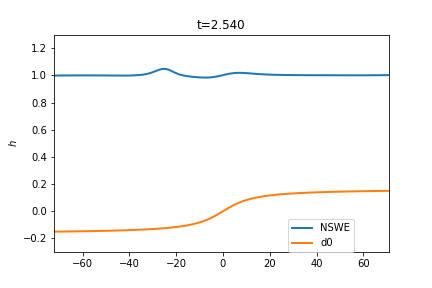
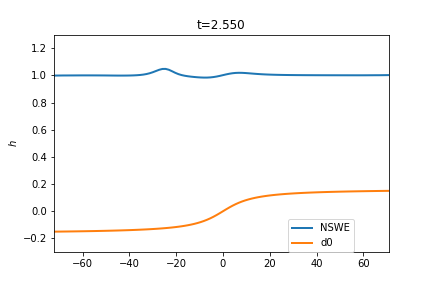
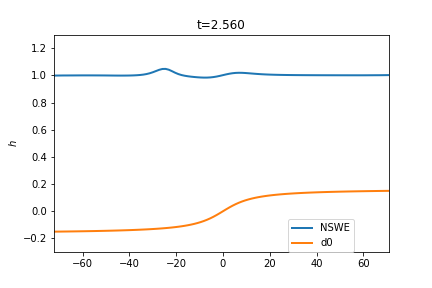
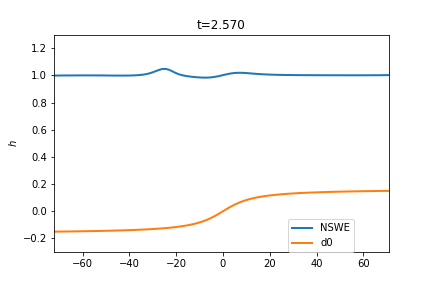
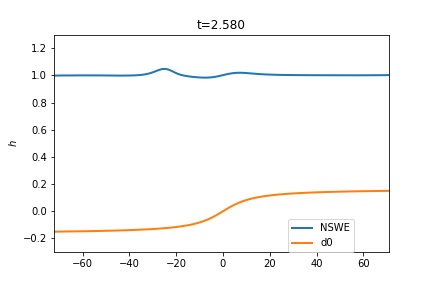
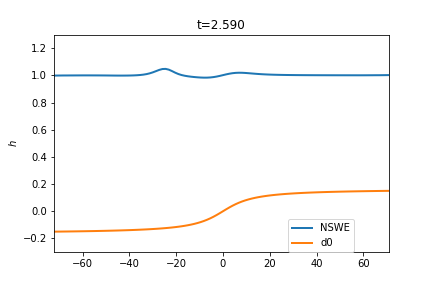
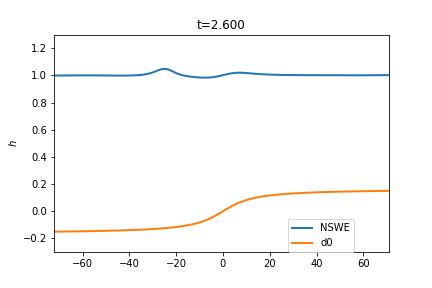
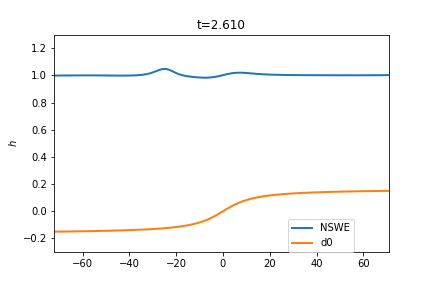
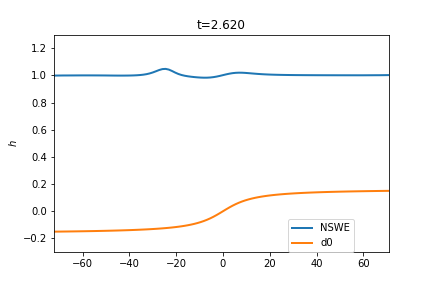
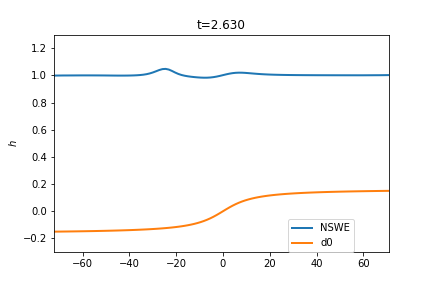
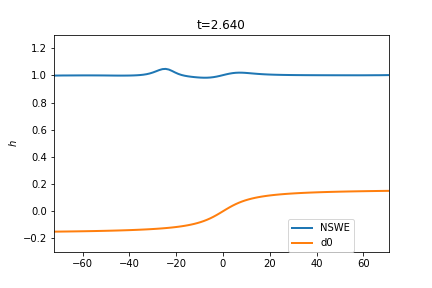
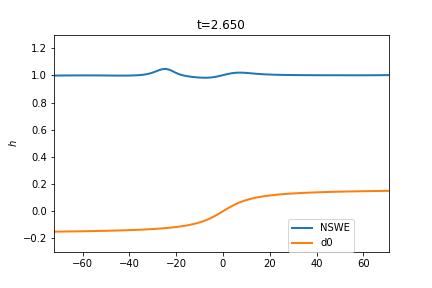
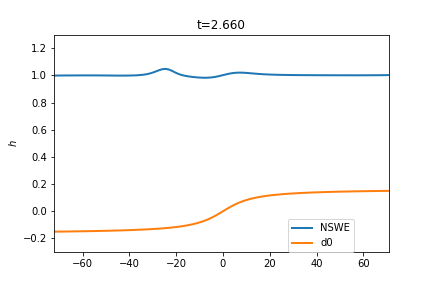
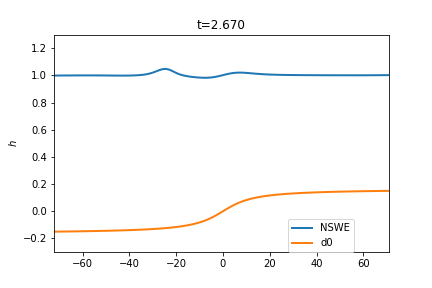
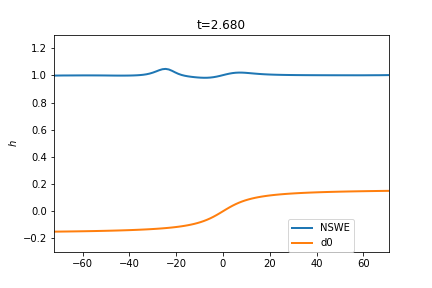
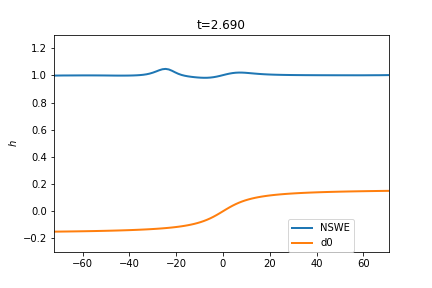
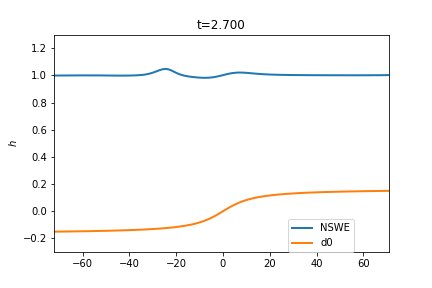
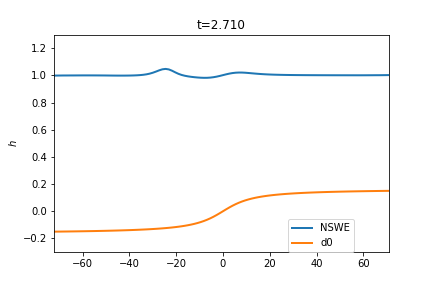
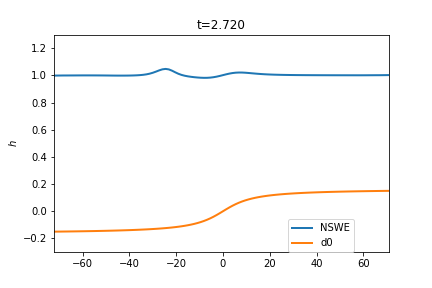
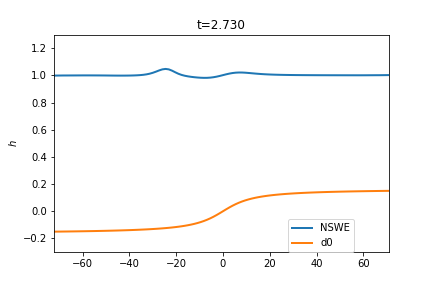
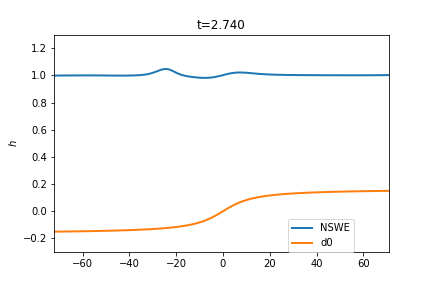
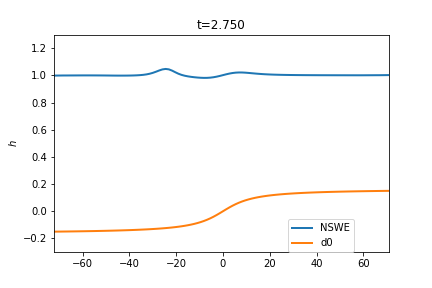
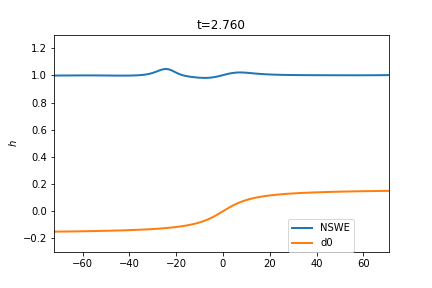
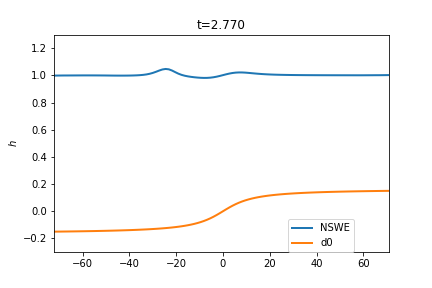
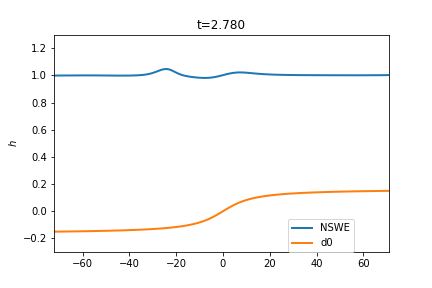
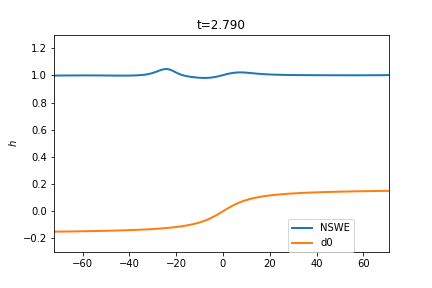
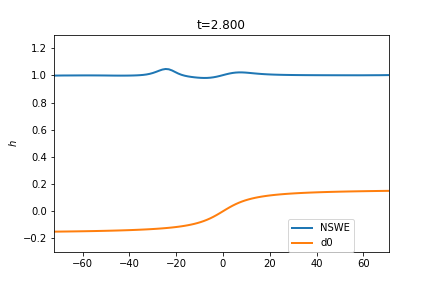
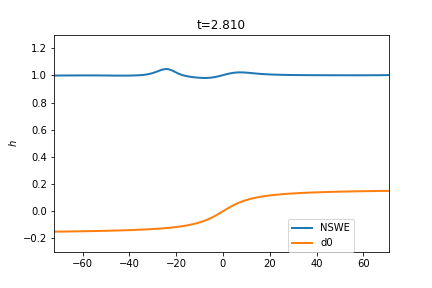
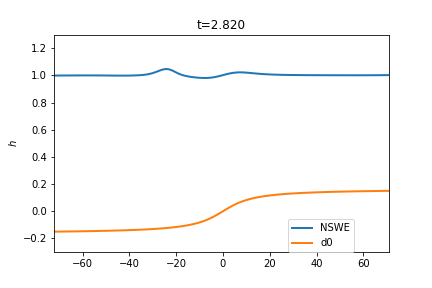
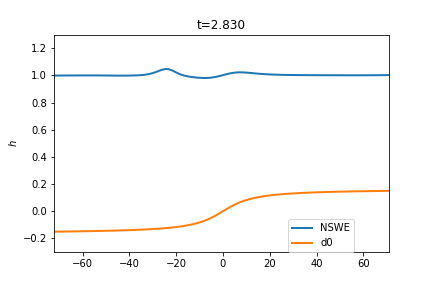
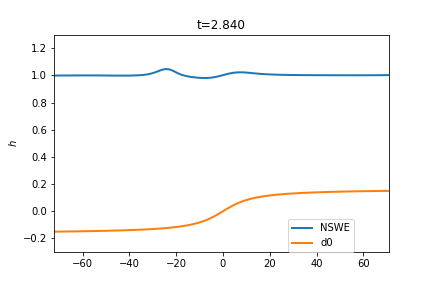
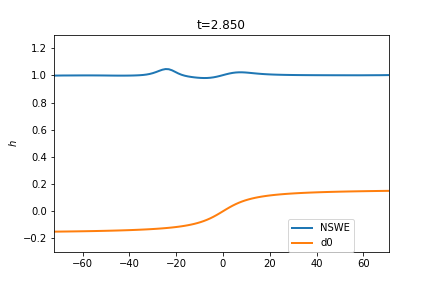
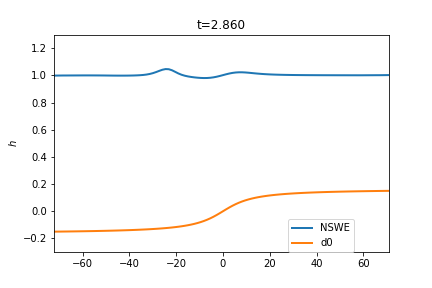
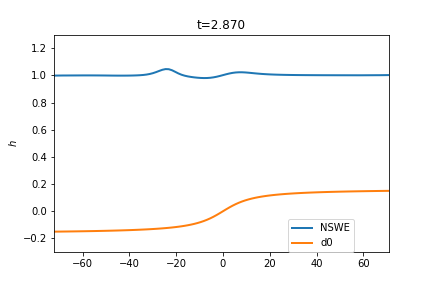
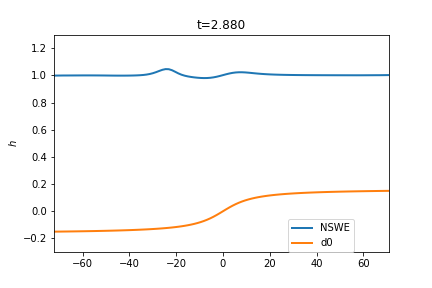
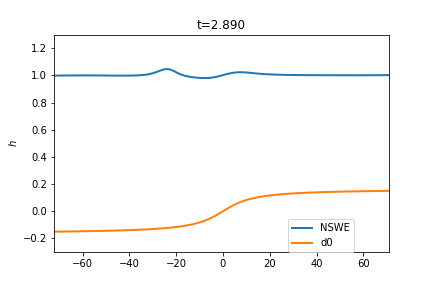
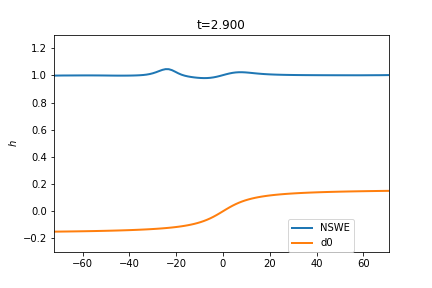
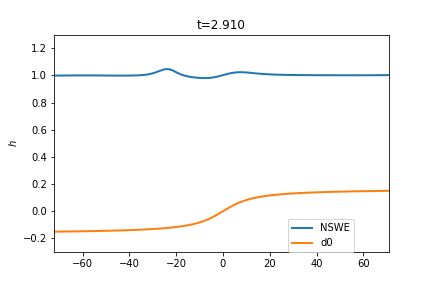
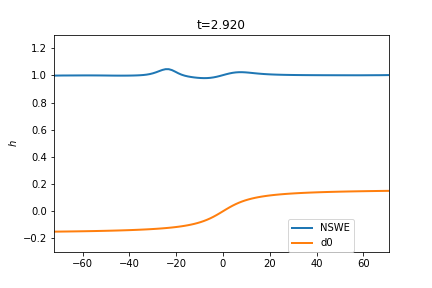
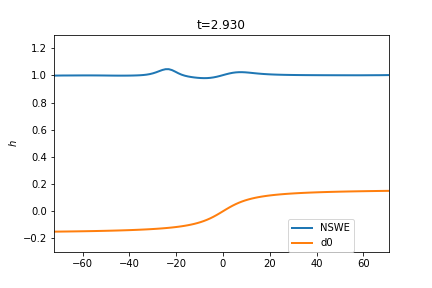
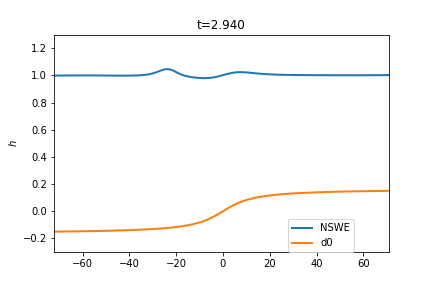
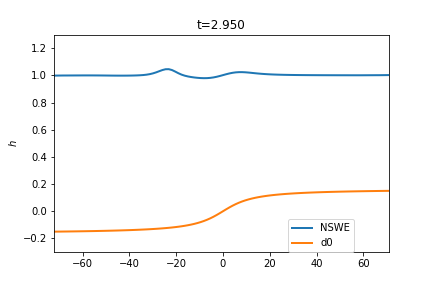
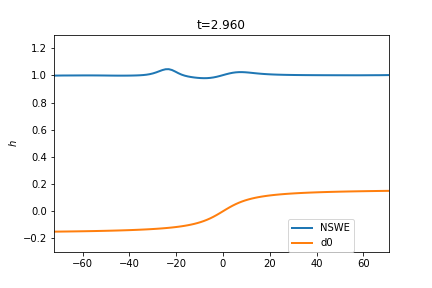
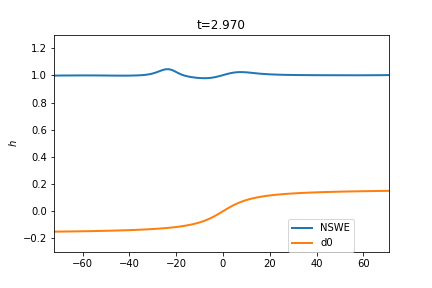
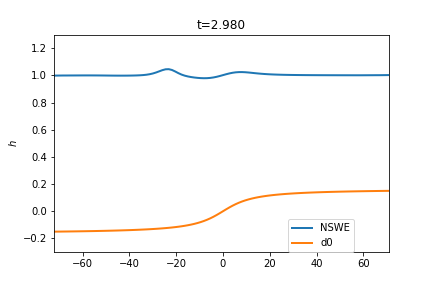
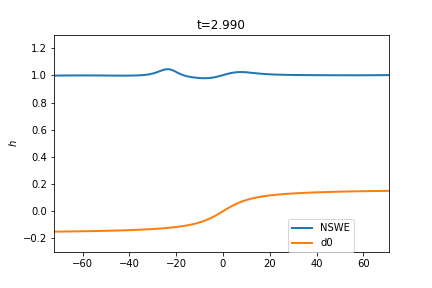
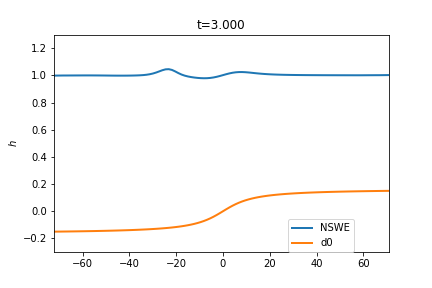
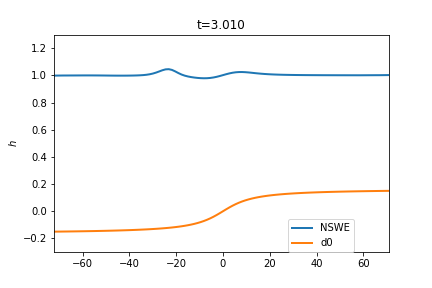
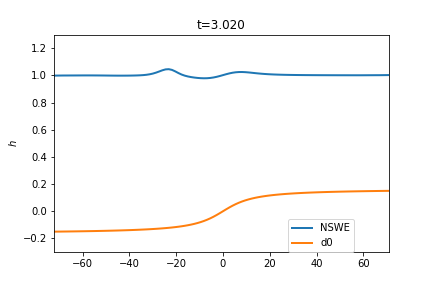
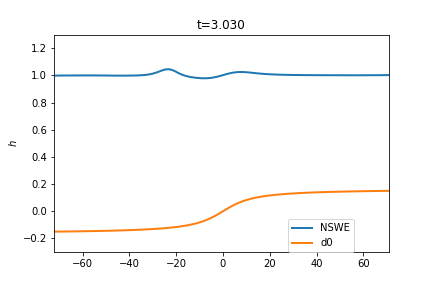
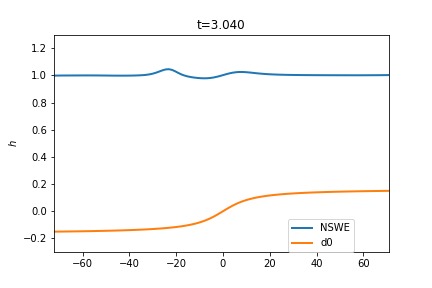
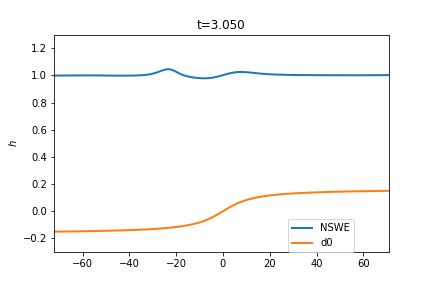
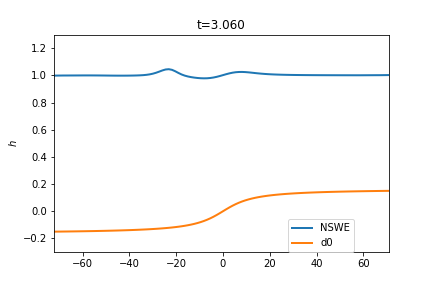
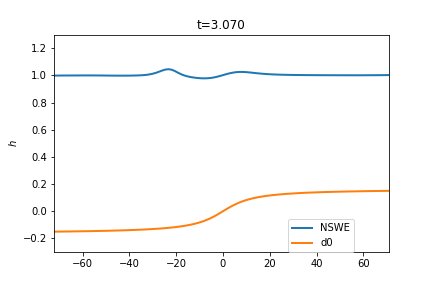
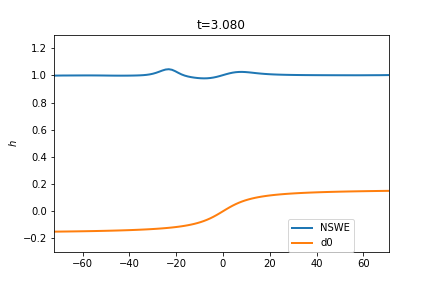
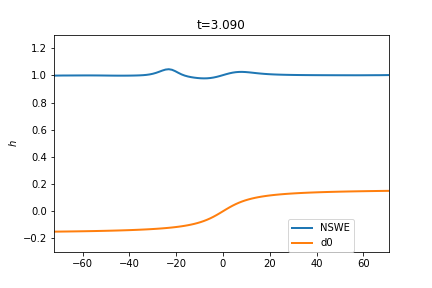
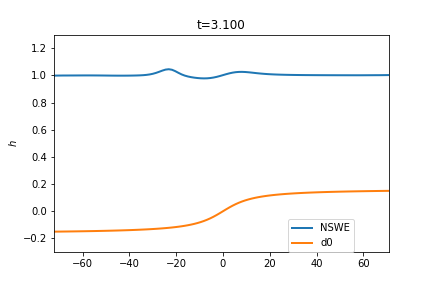
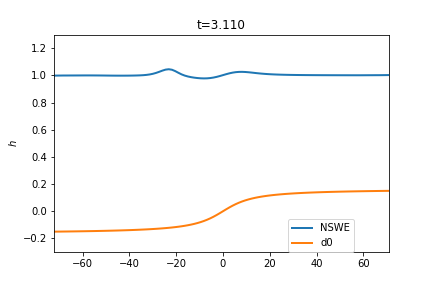
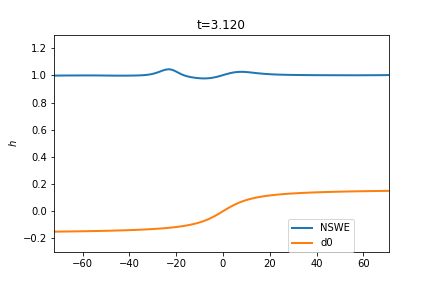
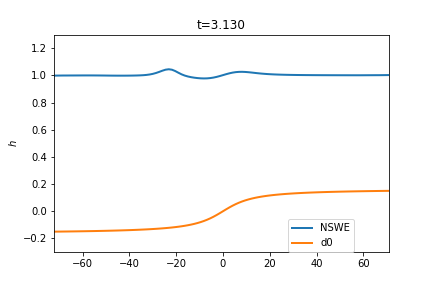
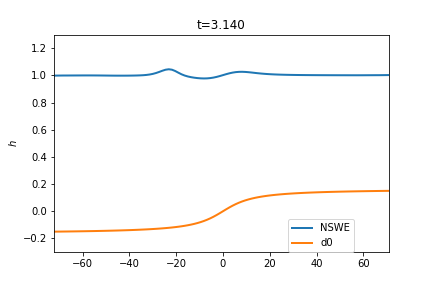
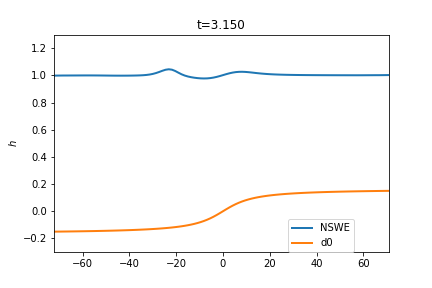
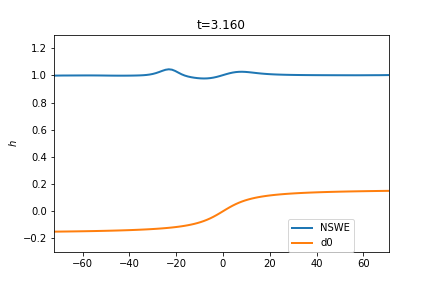
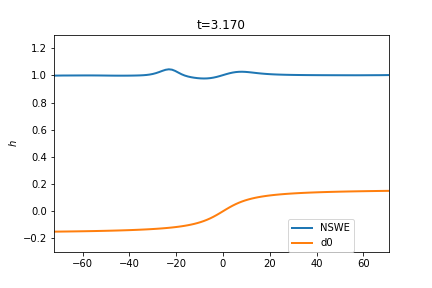
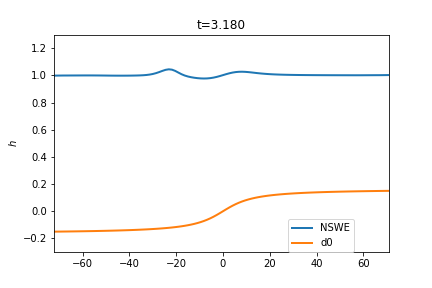
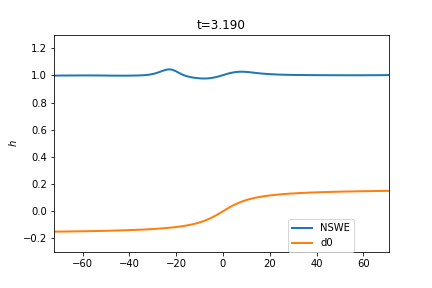
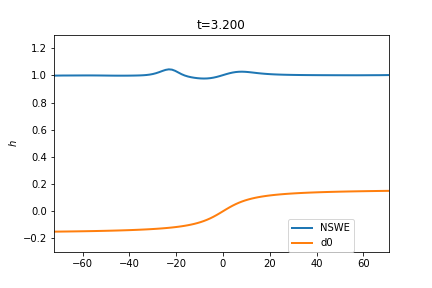
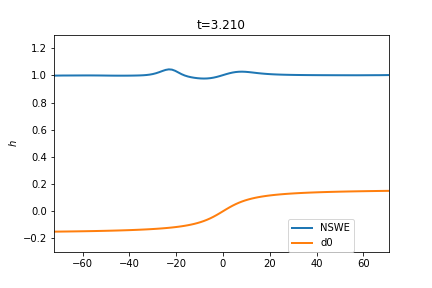
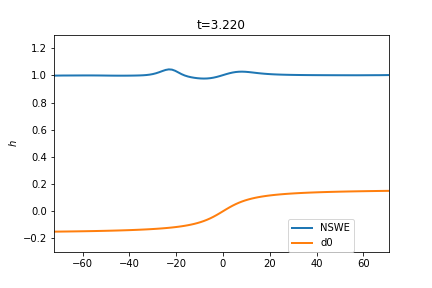
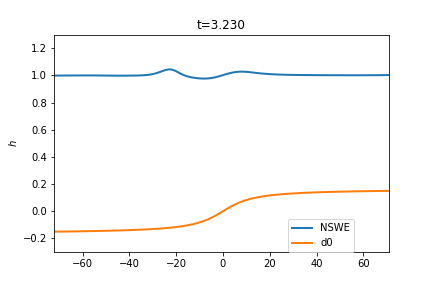
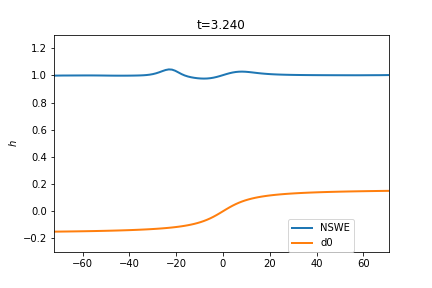
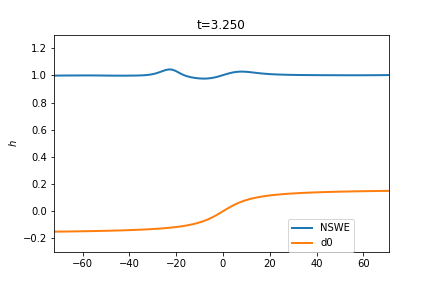
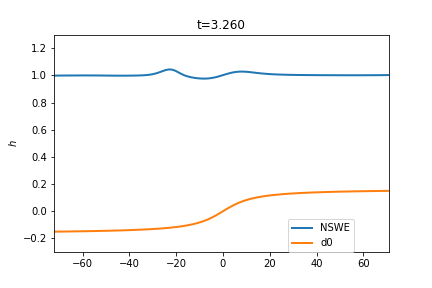
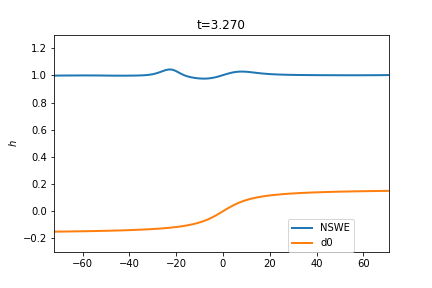
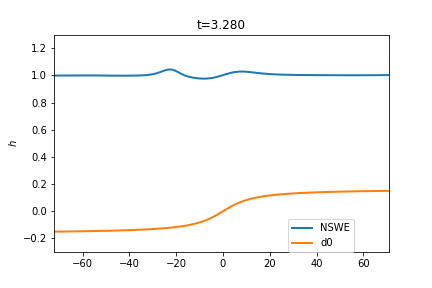
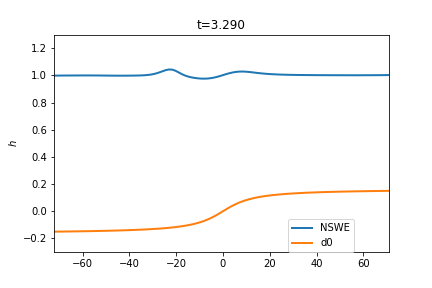
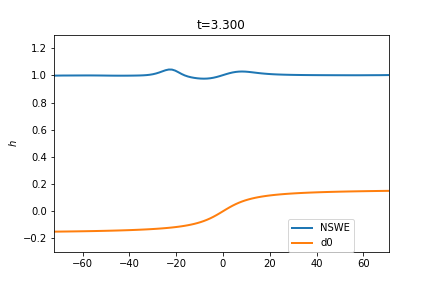
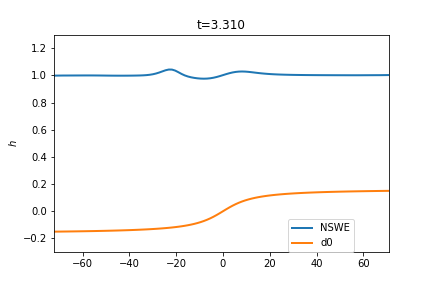
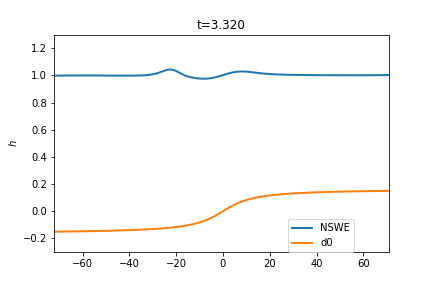
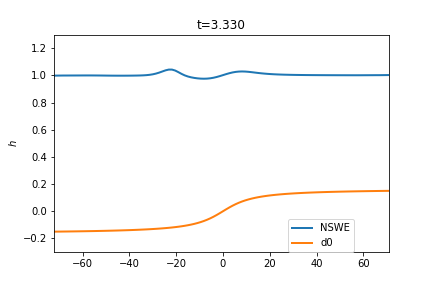
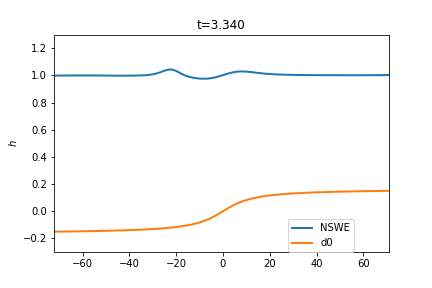
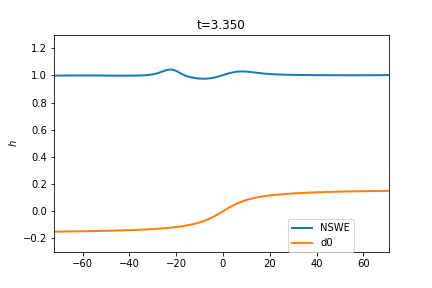
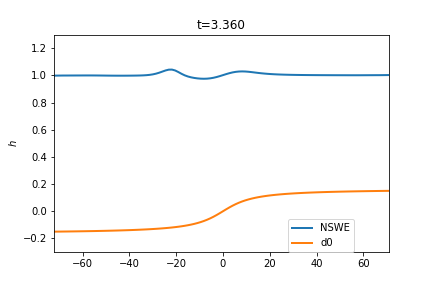
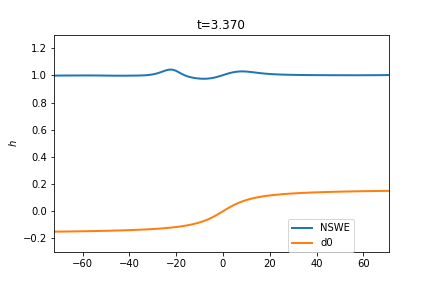
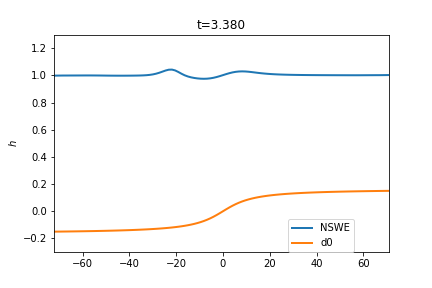
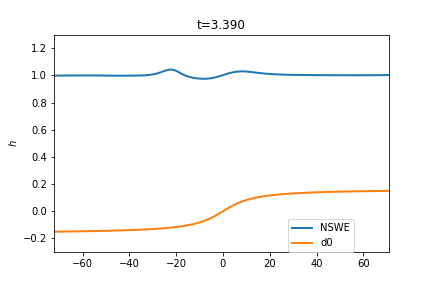
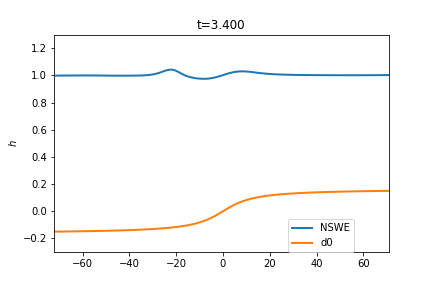
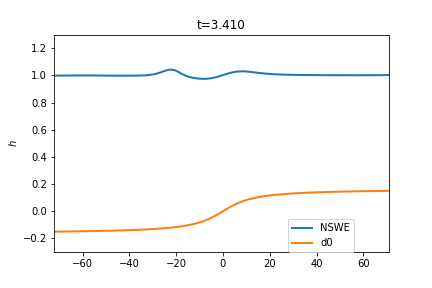
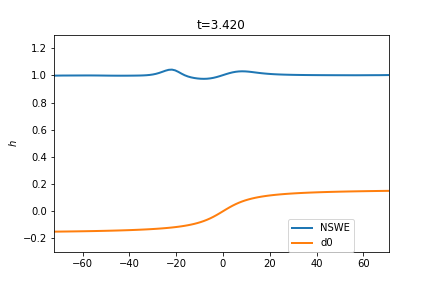
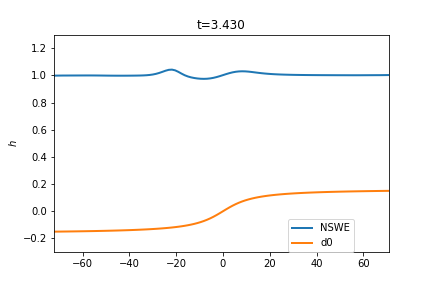
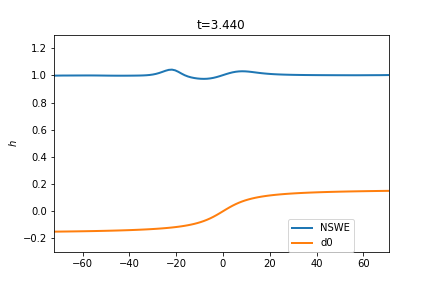
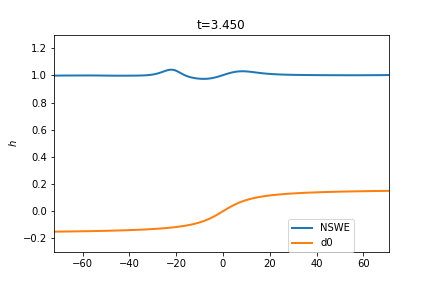
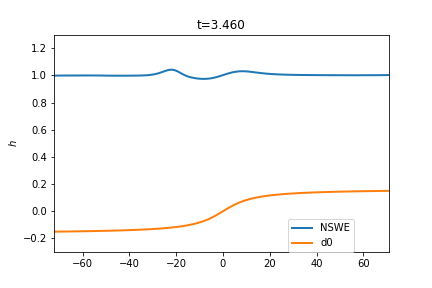
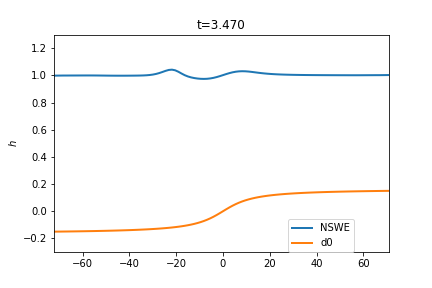
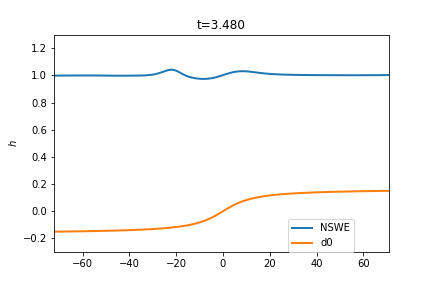
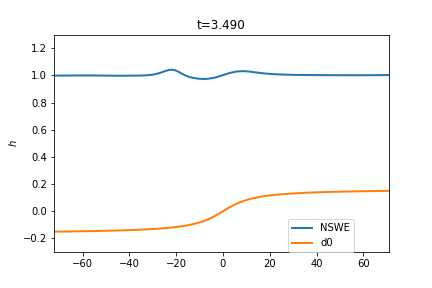
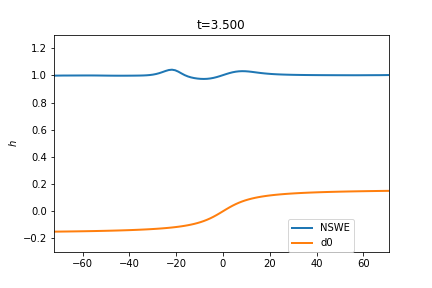
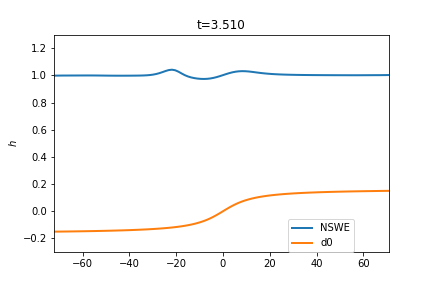
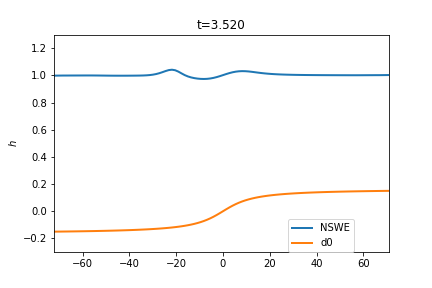
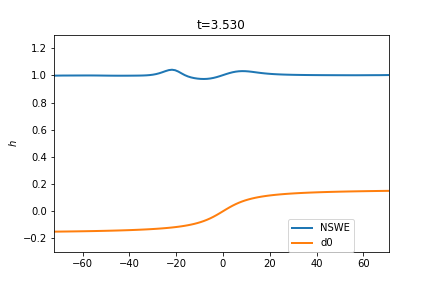
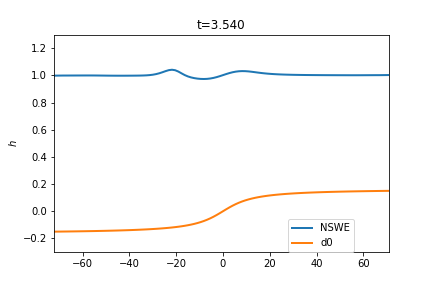
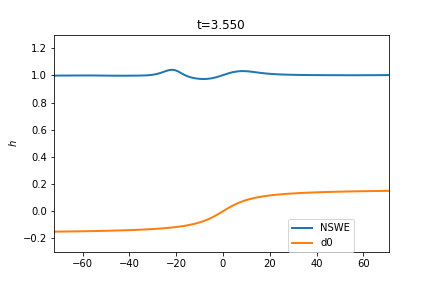
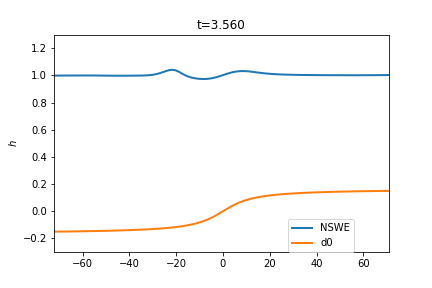
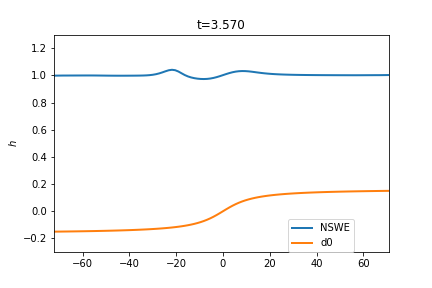
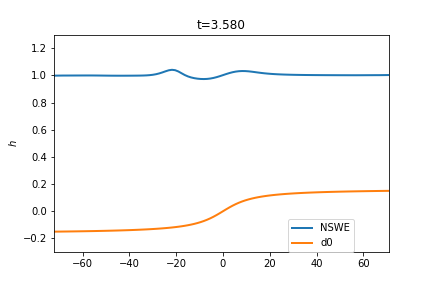
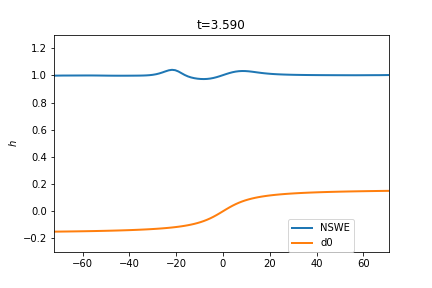
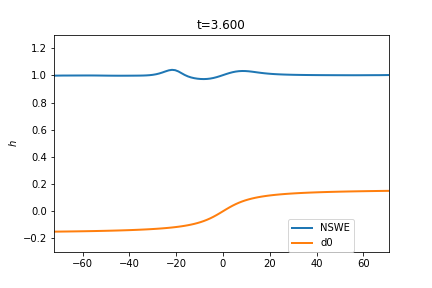
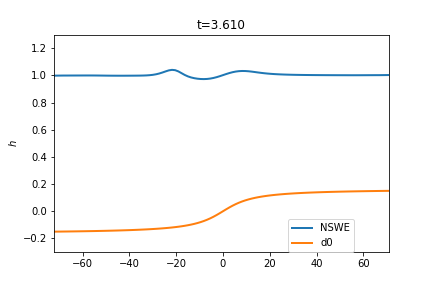
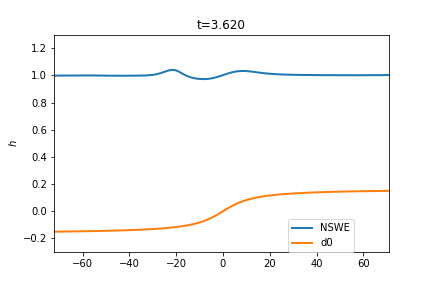
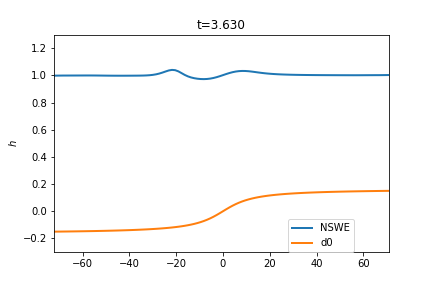
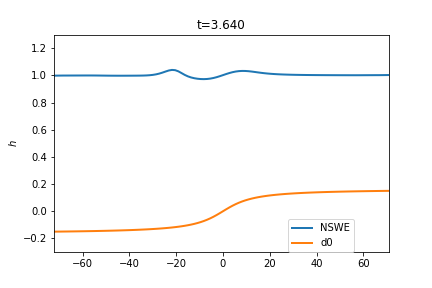
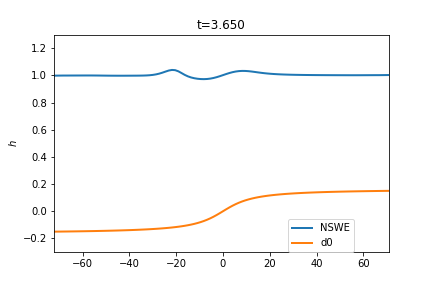
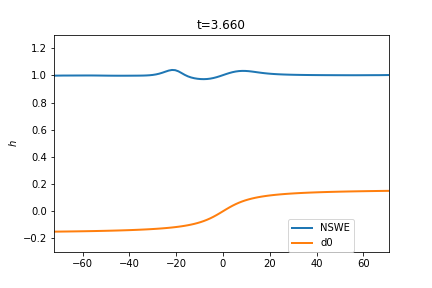
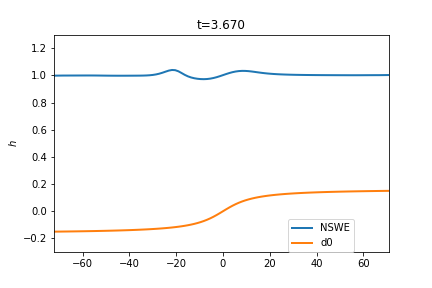
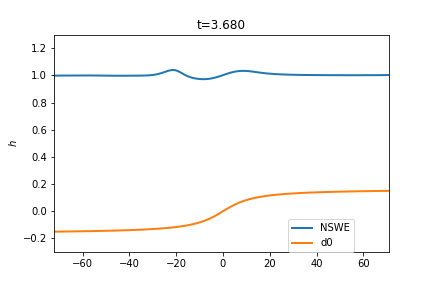
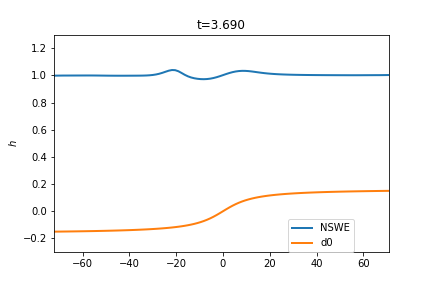
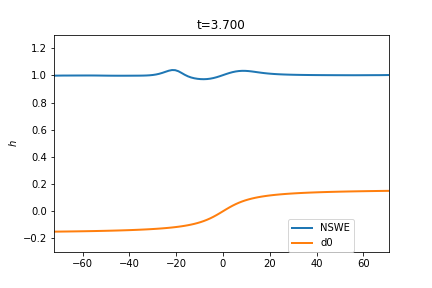
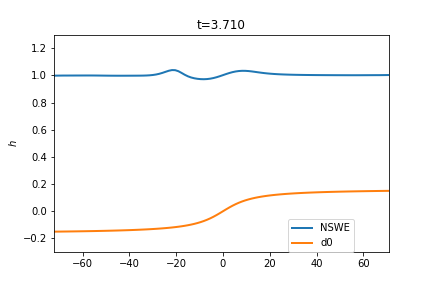
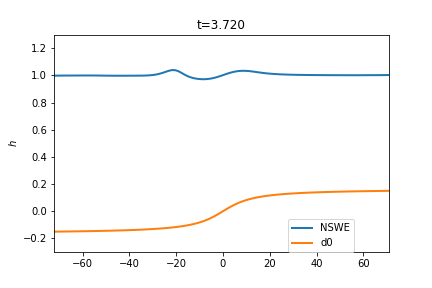
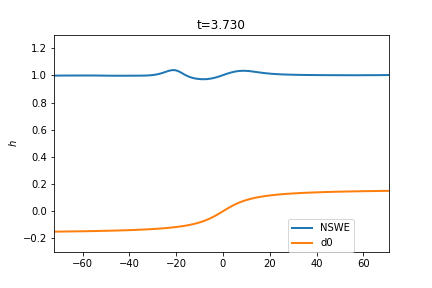
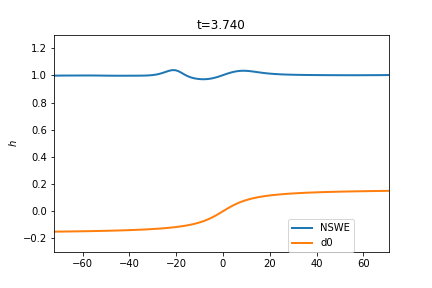
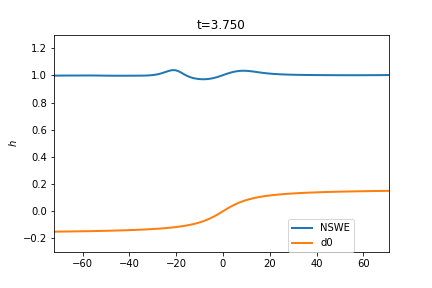
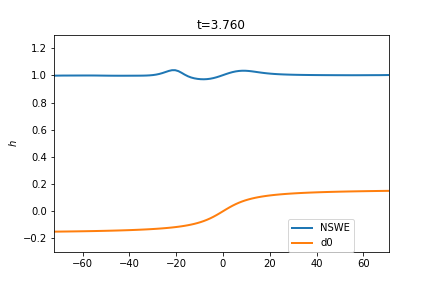
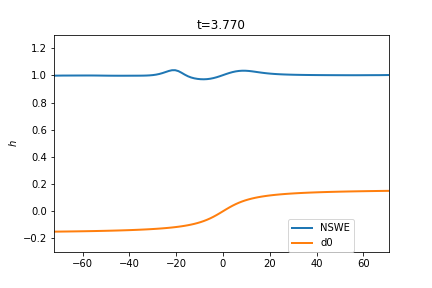
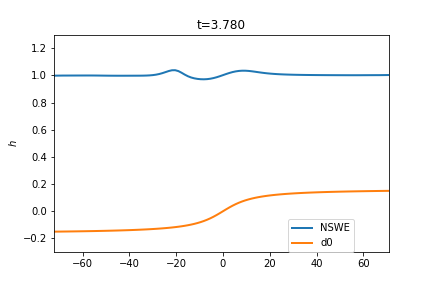
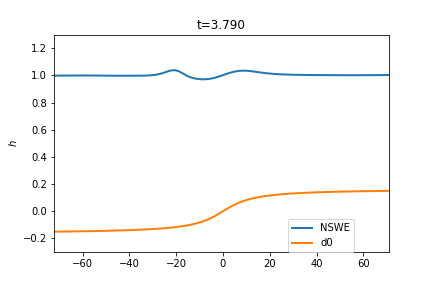
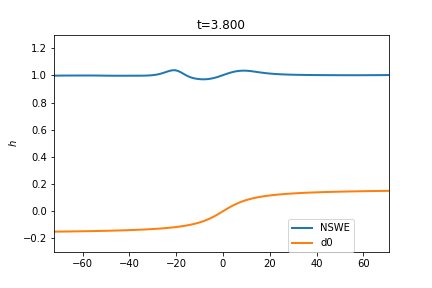
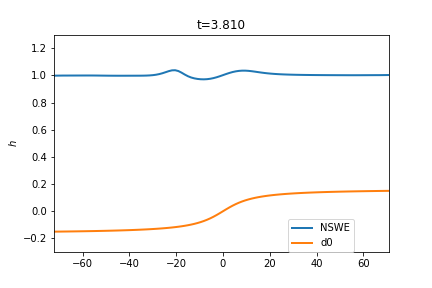
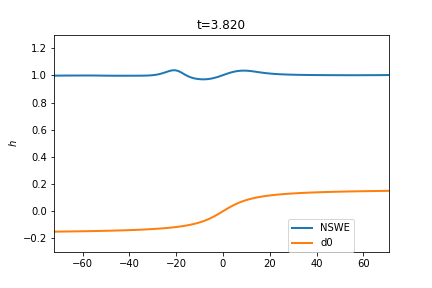
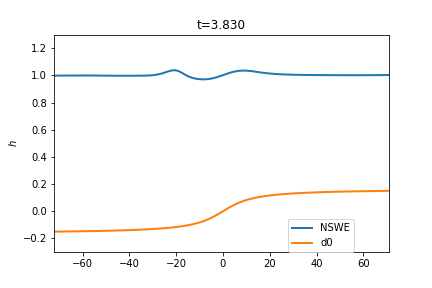
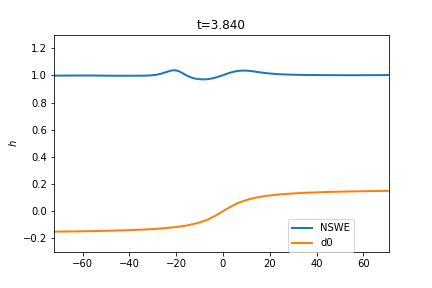
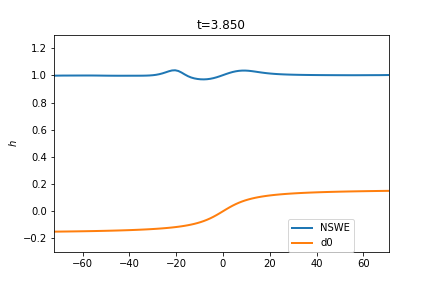
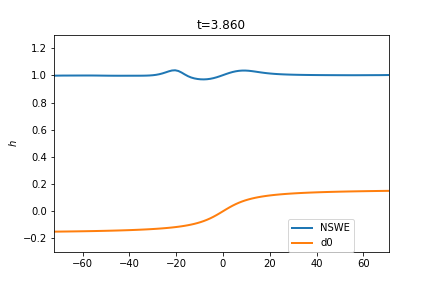
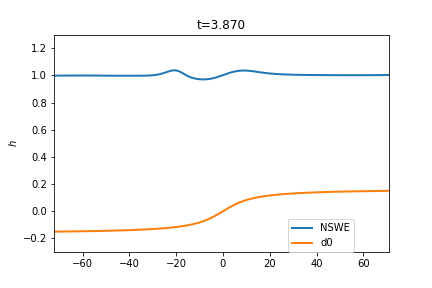
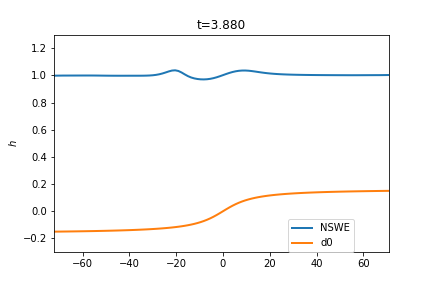
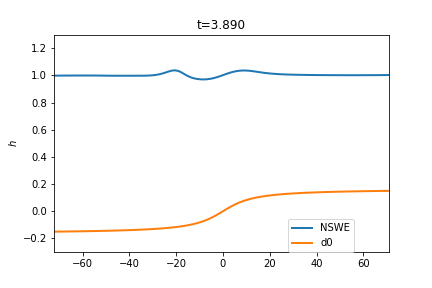
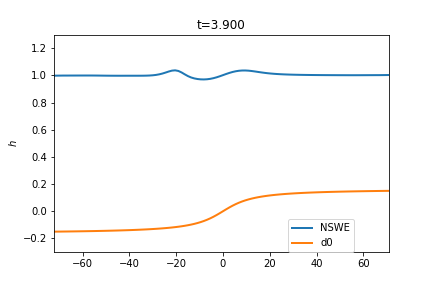
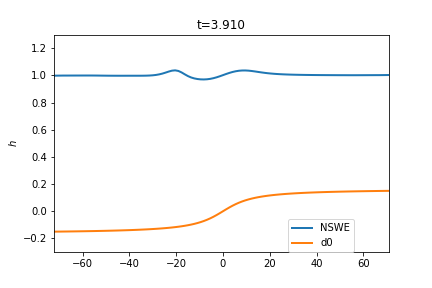
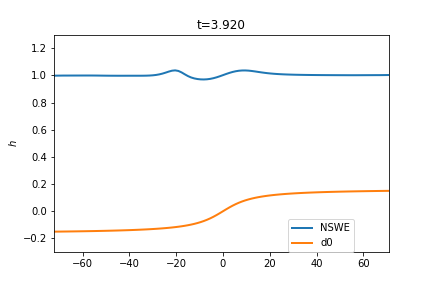
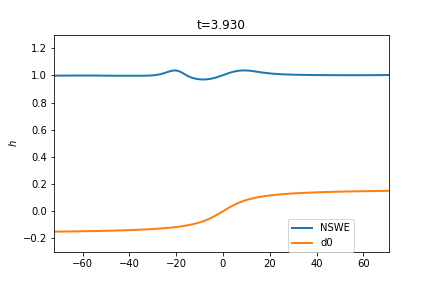
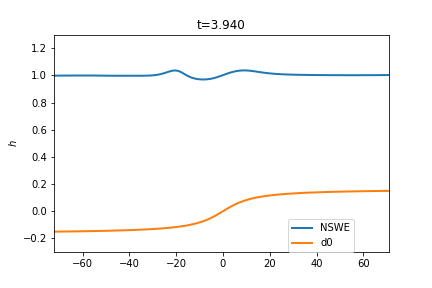
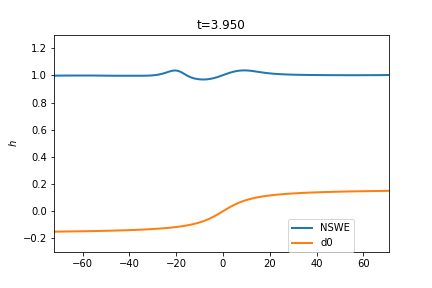
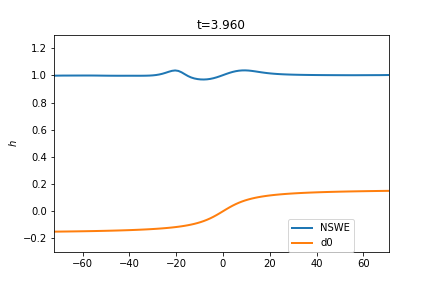
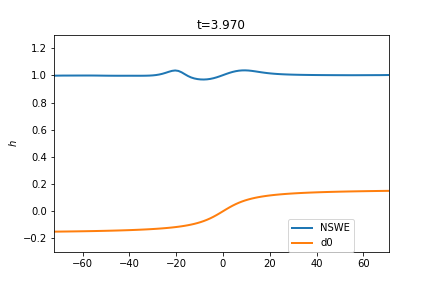
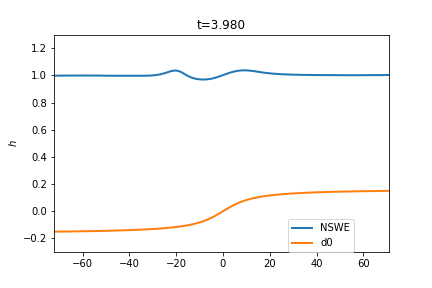
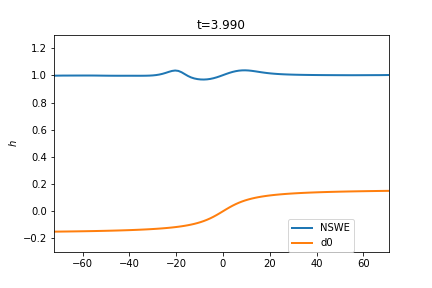
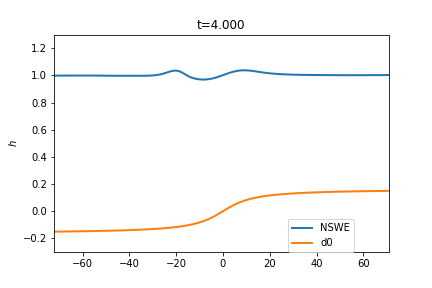
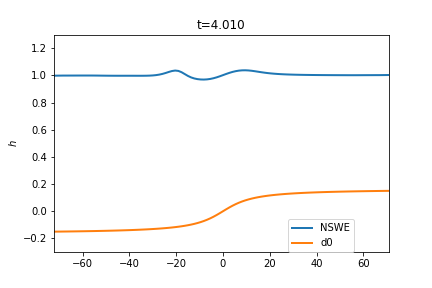
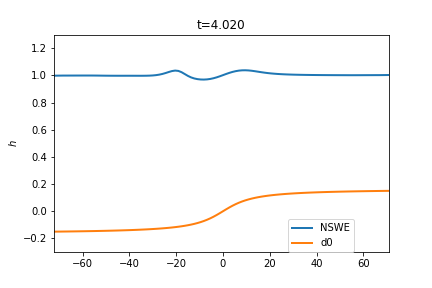
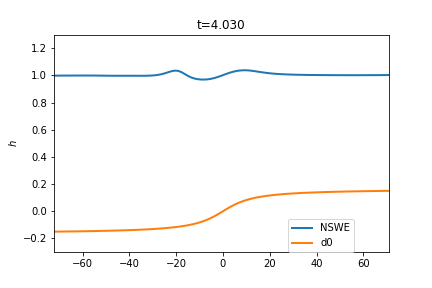
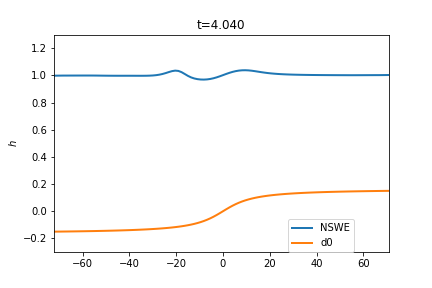
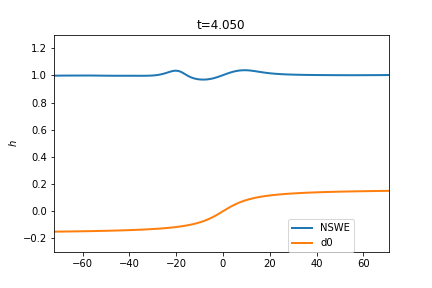
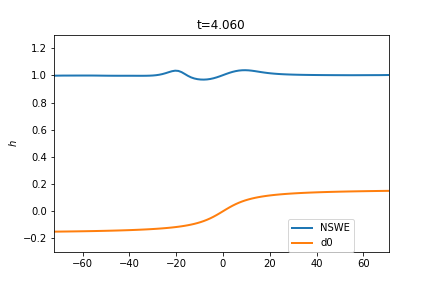
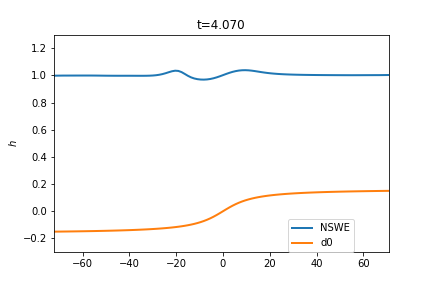
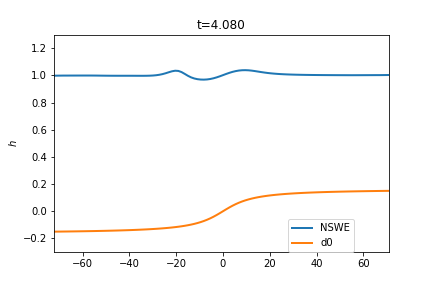
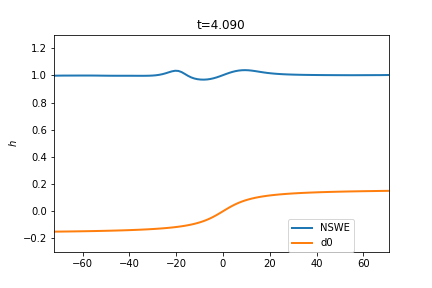
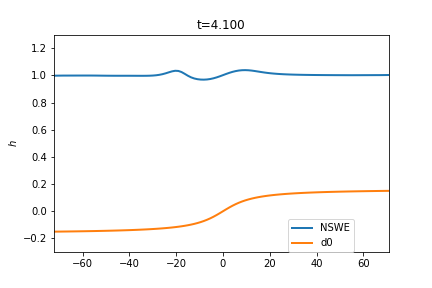
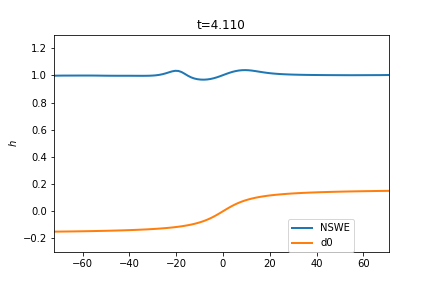
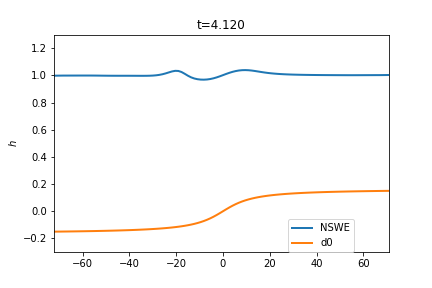
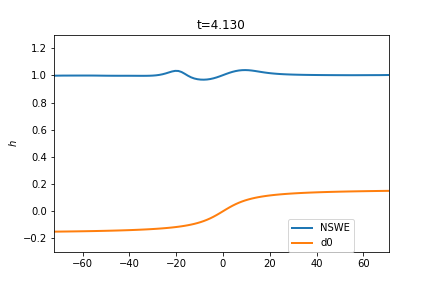
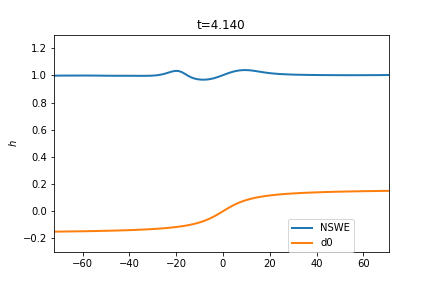
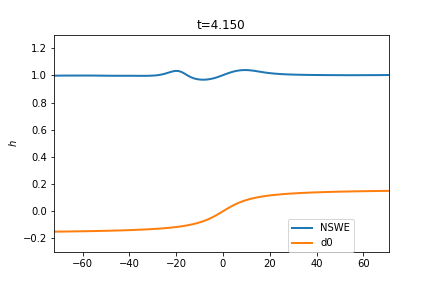
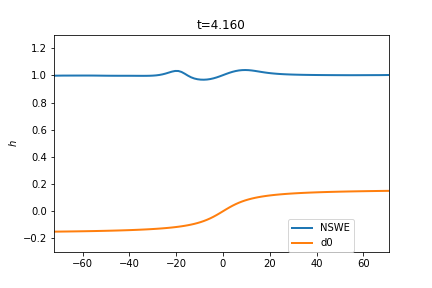
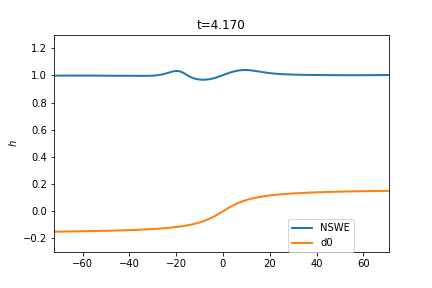
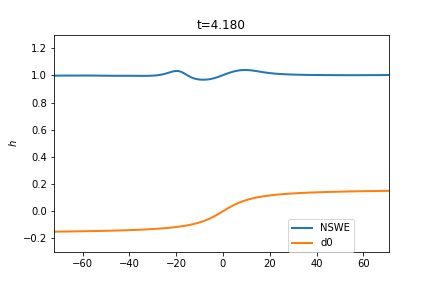
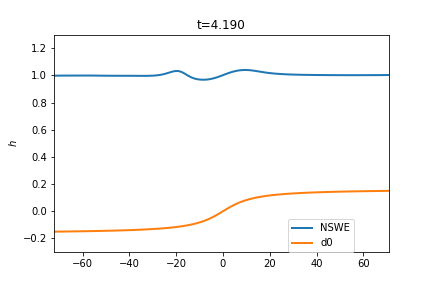
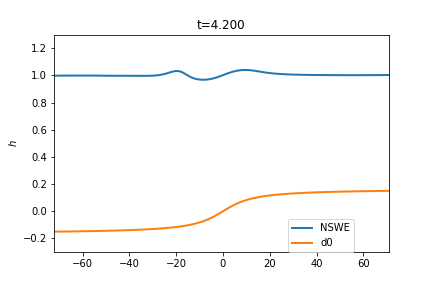
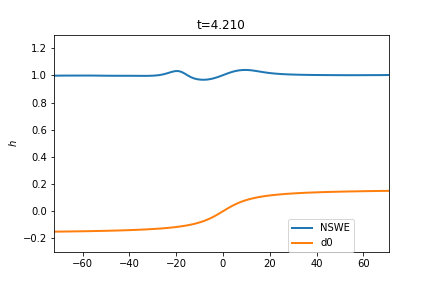
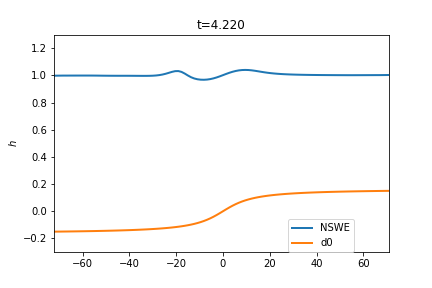
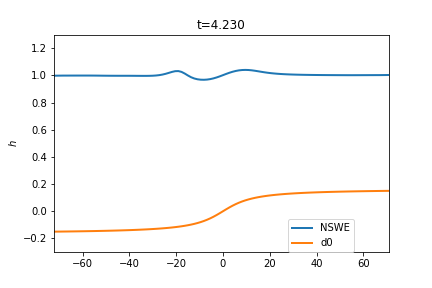
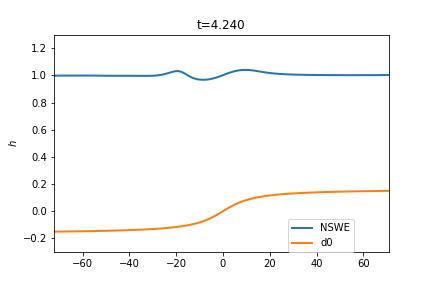
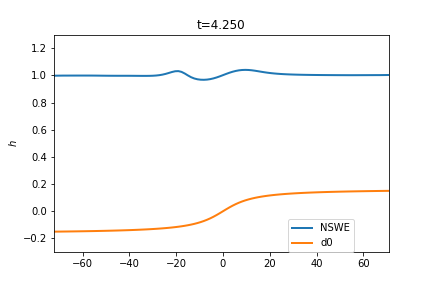
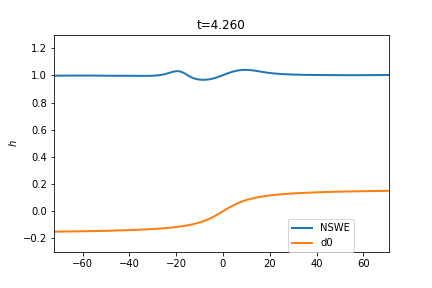
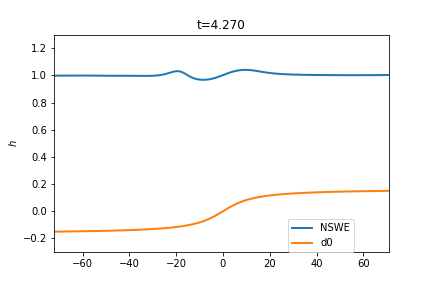
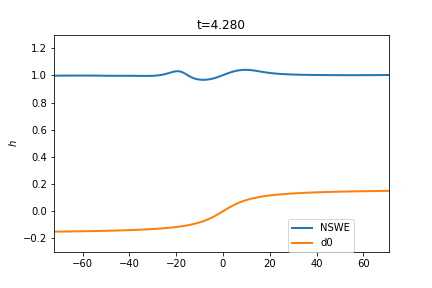
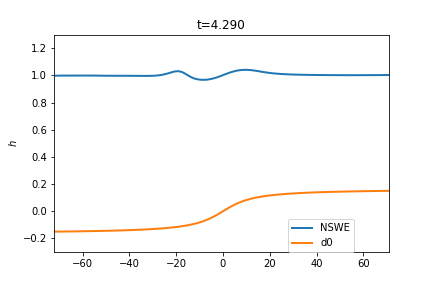
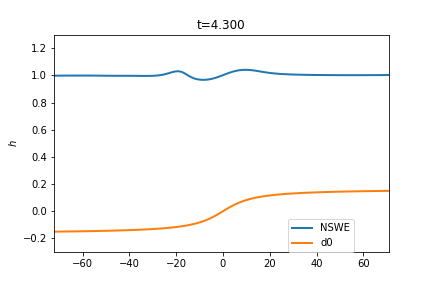
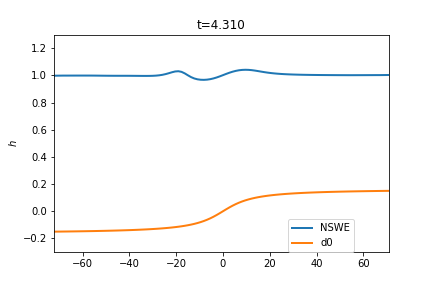
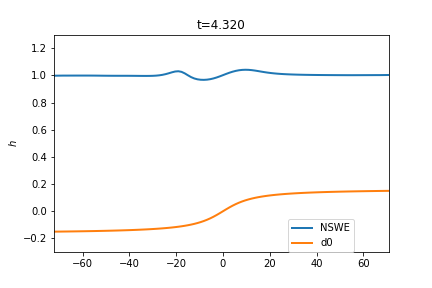
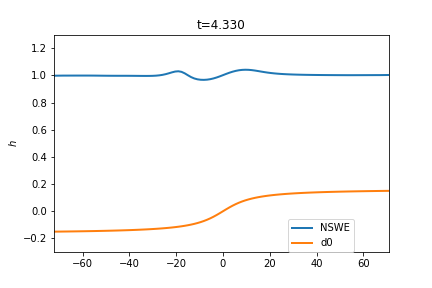
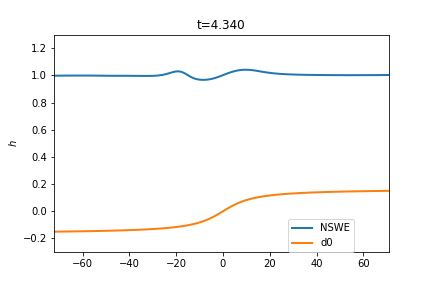
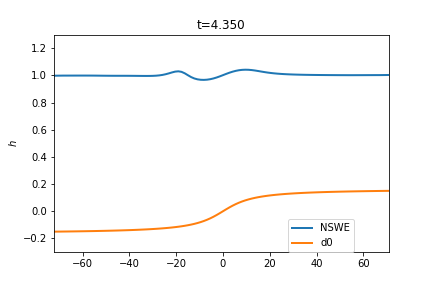
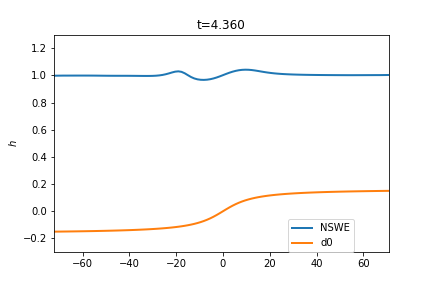
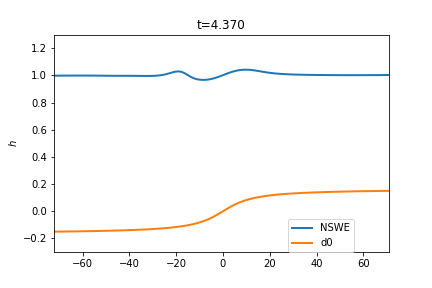
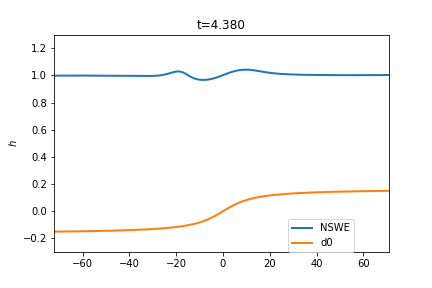
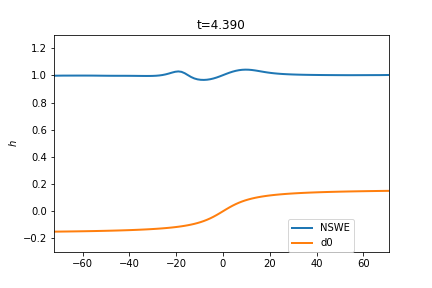
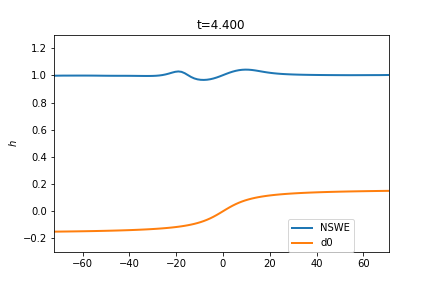
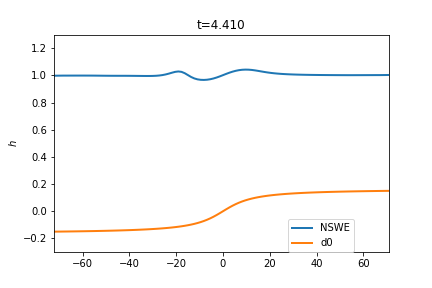
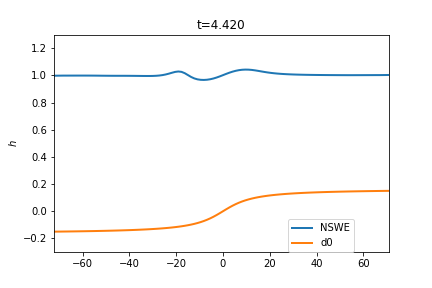
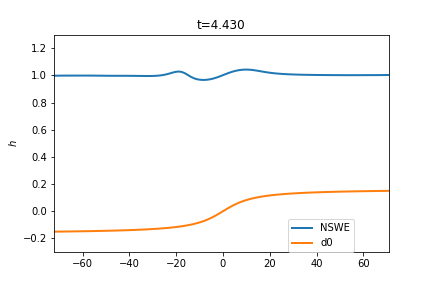
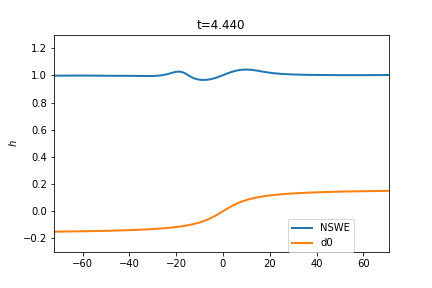
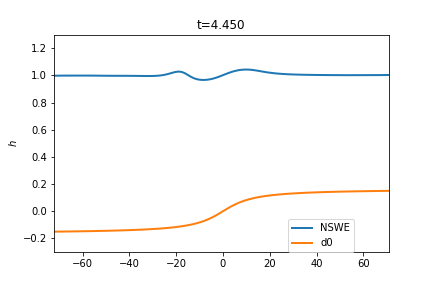
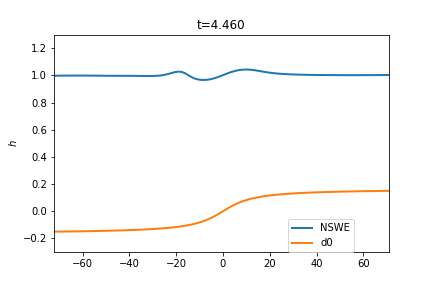
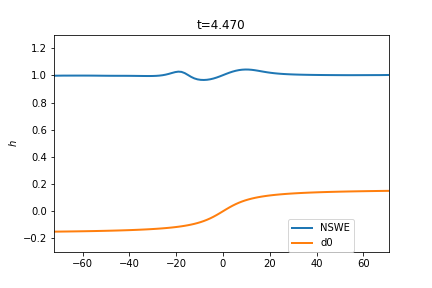
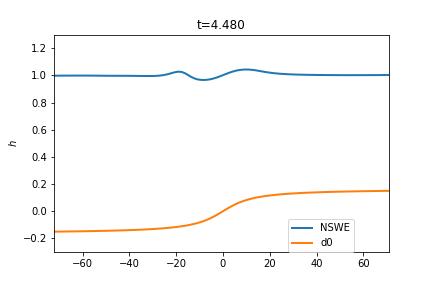
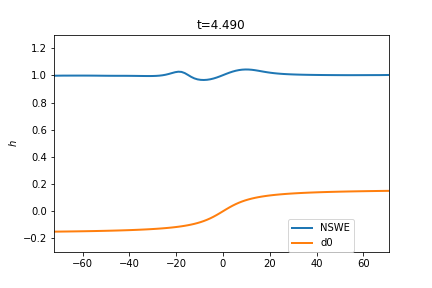
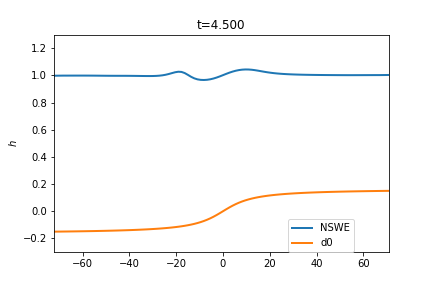
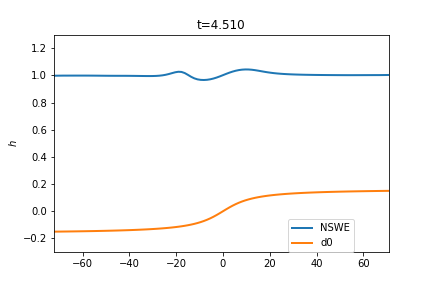
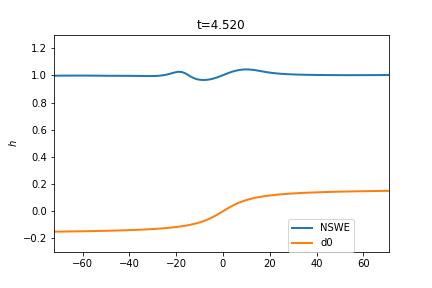
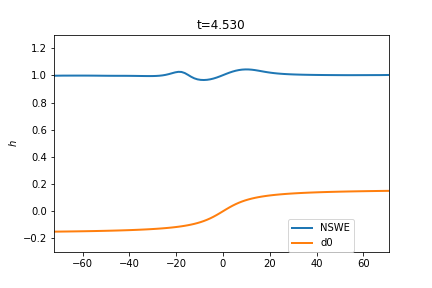
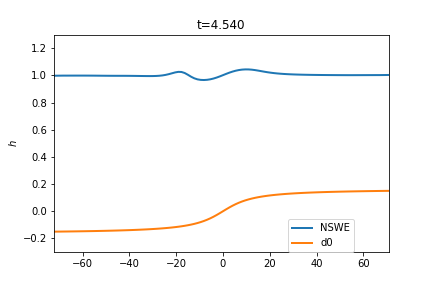
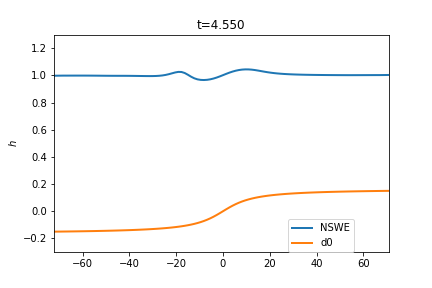
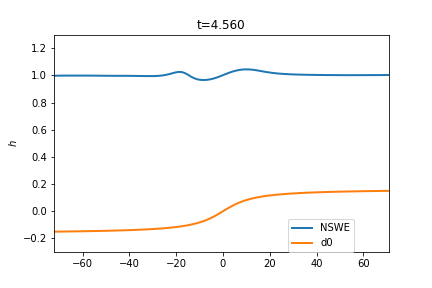
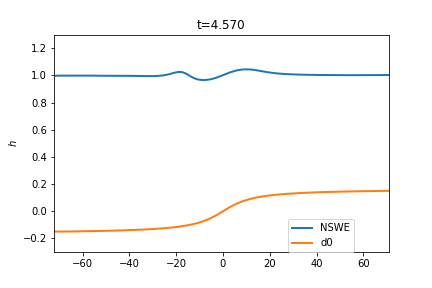
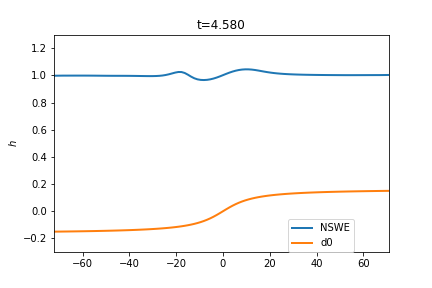
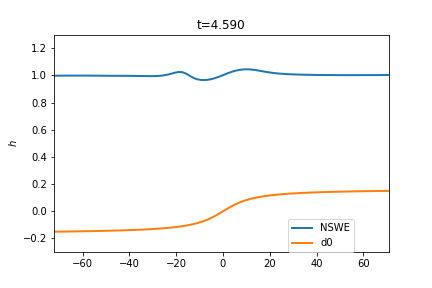
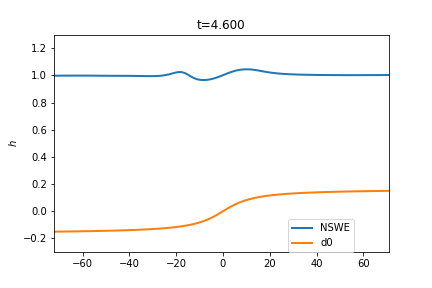
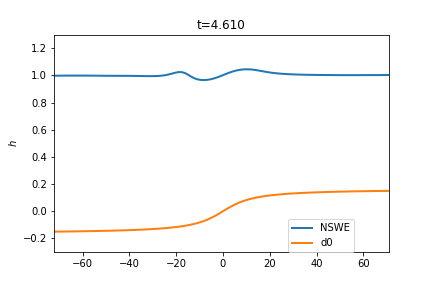
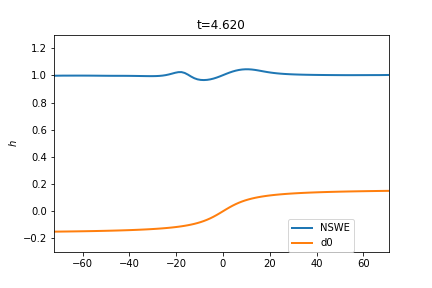
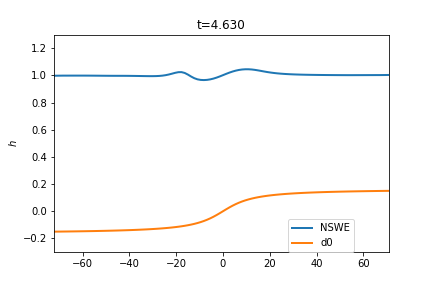
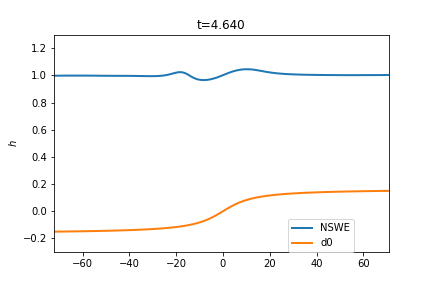
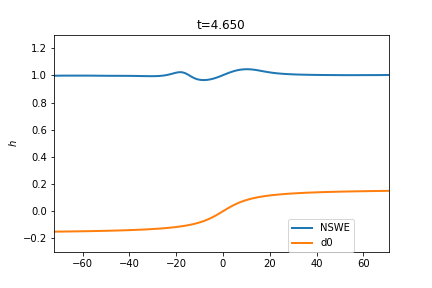
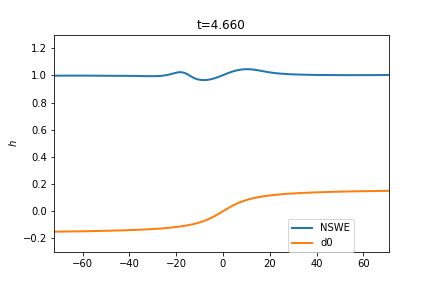
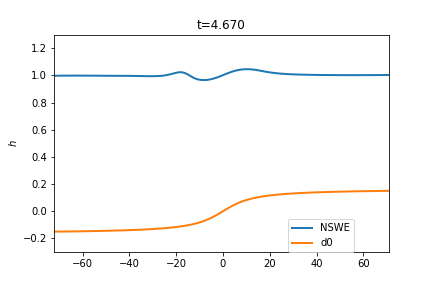
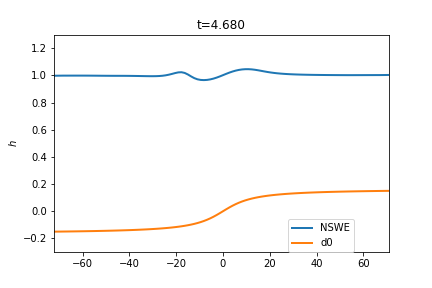
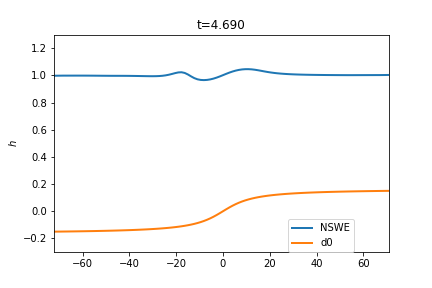
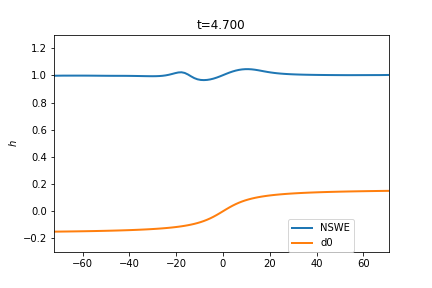
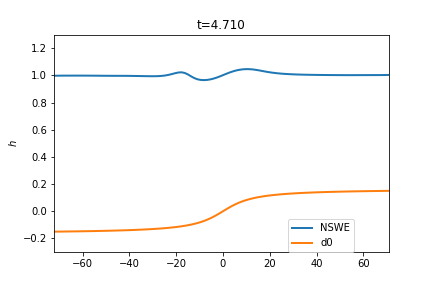
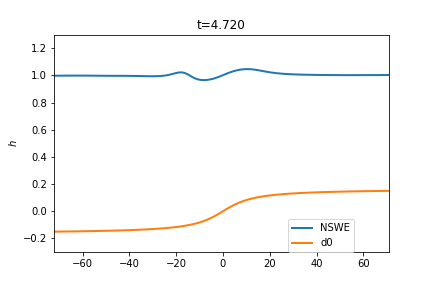
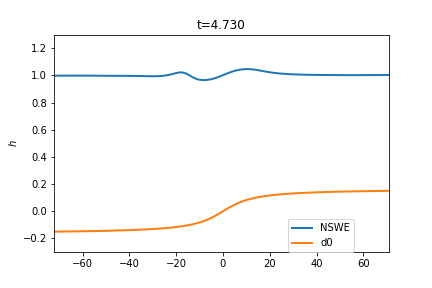
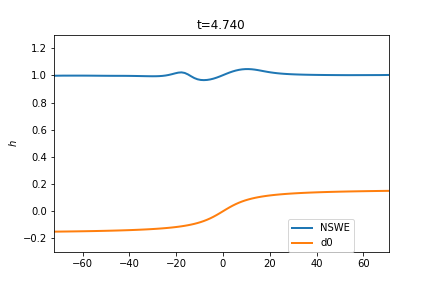
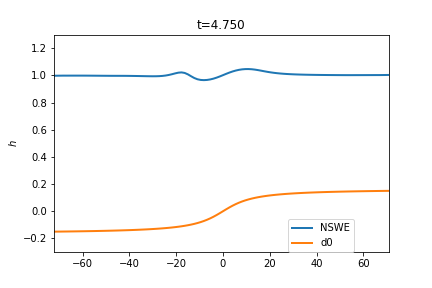
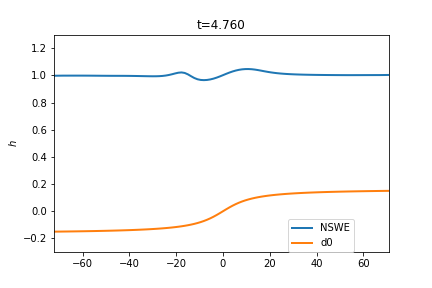
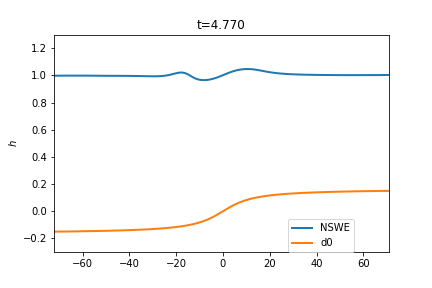
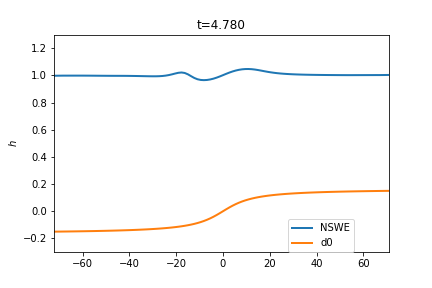
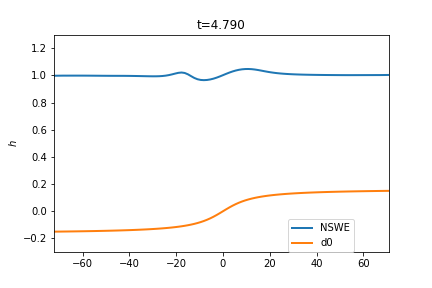
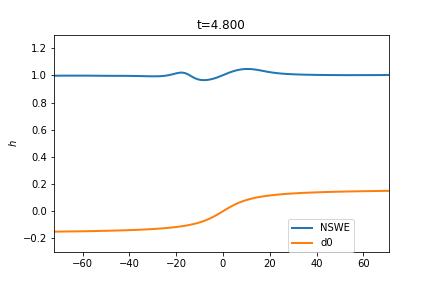
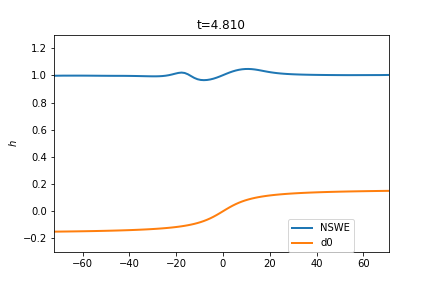
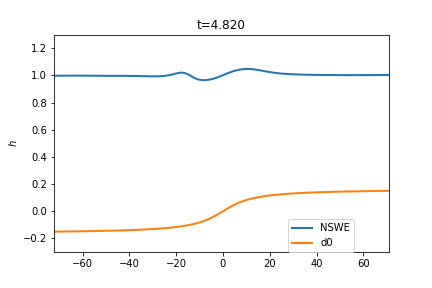
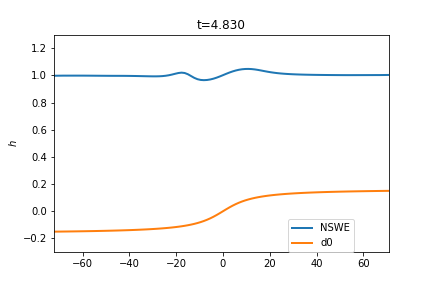
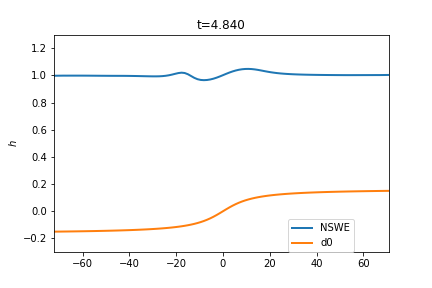
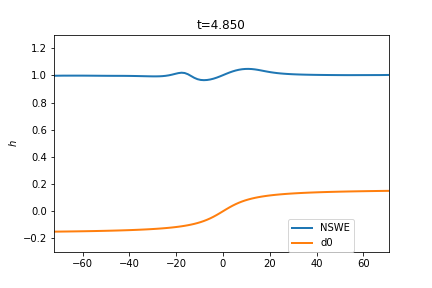
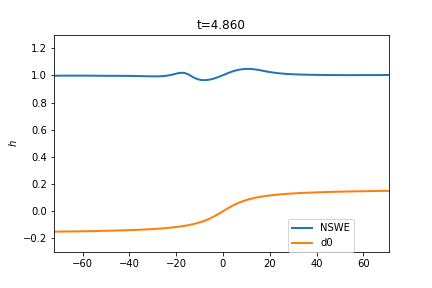
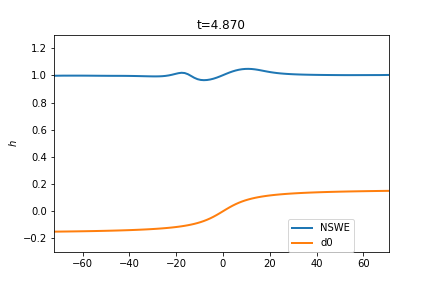
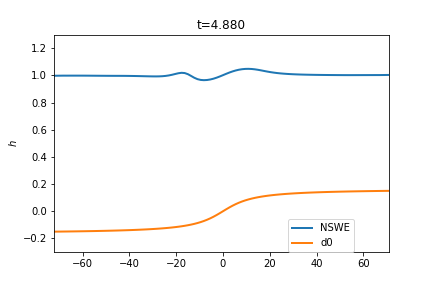
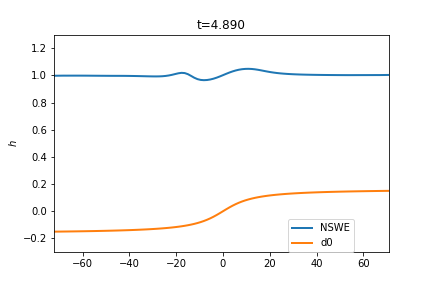
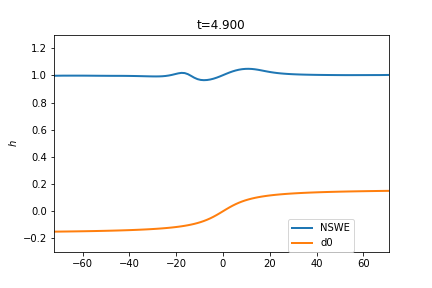
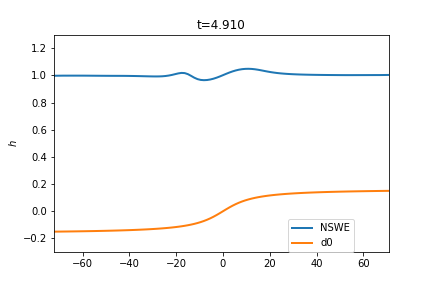
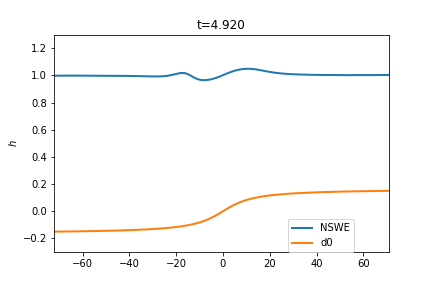
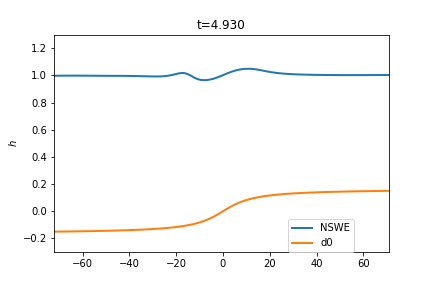
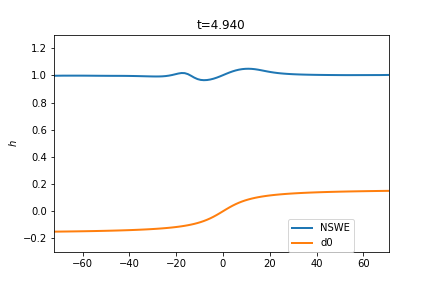
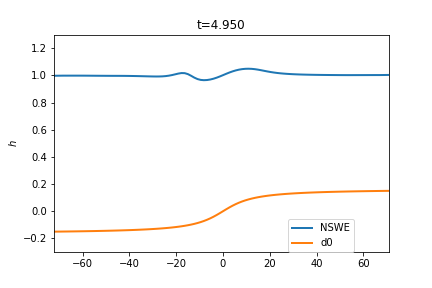
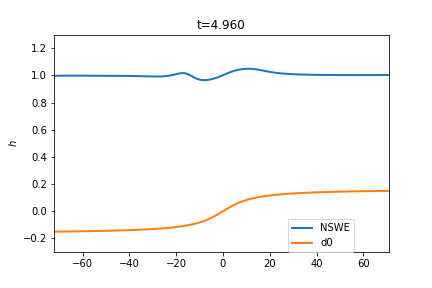
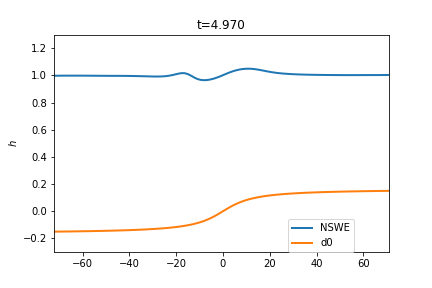
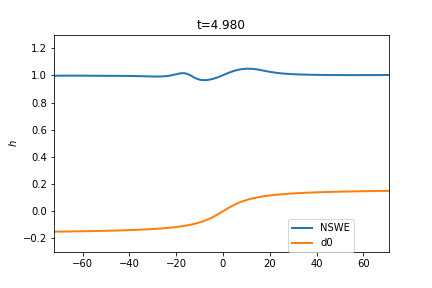
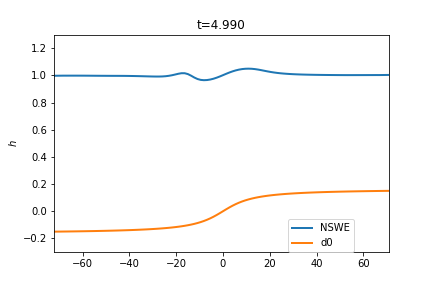
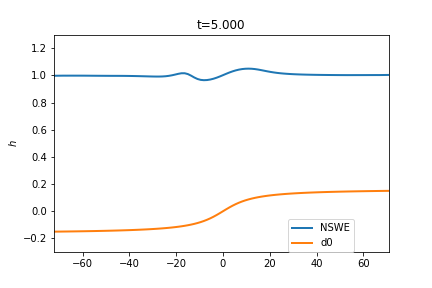
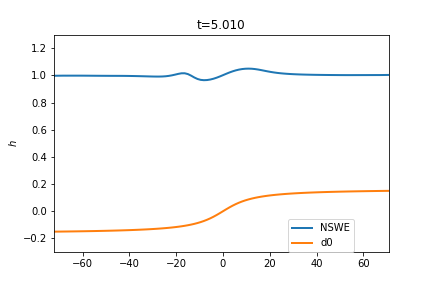

In [19]:
lb = ["NSWE", "d0"]
gF.plotAnimationNSolutions(2,x,np.array([hallMP,d0all]),tallM,x[0],x[-1],-0.3,1.3,lb,ylabel=r'$h$',location=(0.7,0.))

## DDM with overlapping 

In [20]:
### Only NSWE

In [21]:
## DDM

Nddm = x.size/2
print(x.size)
print(x[Nddm:Nddm+3])

print(x[Nddm],Nddm)
configDDM = 2 ## With overtlapping
#overlapping size
ov = 0 ## ov = 0: 1 cell overlapped

if configDDM == 1:
    x1 = x[0:Nddm+3] ## (0:Nddm+1) + 3 gc 
    x2 = x[Nddm-3:] ## 3gc + (Nddm:)
    h1 = h[0:Nddm+3]
    h2 = h[Nddm-3:]
    u1 = u[0:Nddm+3]
    u2 = u[Nddm-3:]
elif configDDM == 2:
    x1 = x[0:Nddm+4+ov] ## (0:Nddm+1) + 3 gc + ov
    x2 = x[Nddm-3-ov:] ## ov + 3gc + (Nddm:)
    h1 = h[0:Nddm+4+ov]
    h2 = h[Nddm-3-ov:]
    u1 = u[0:Nddm+4+ov]
    u2 = u[Nddm-3-ov:]

## TBC for dispersive equation
## in right domain

print(x1[-3]-x2[4+2*ov],x2[0]-x1[-7-2*ov])



hall1,uall1,tall1,hall2,uall2,tall2 = ddmNS.DDM(x1,h1,u1,x2,h2,u2,t0,tmax,ddmNS.DDM_BCs,dx,nx+6,
             dt = dt, fvsolver=ddmNS.fluxes,
             ghostcells = 3, externalBC="open",coupleSerre=False,ov=ov,uref=uallM,
                                              href = hallM,xref=x,debug=False, fvTimesolver=serre.Euler)

umin = np.amin(uall1)
umax = np.amax(uall1)
hmin = np.amin(hall1)
hmax = np.amax(hall1)

### remove ghost cells for Printing
x1P = x1[3:-3]
x2P = x2[3:-3]

d0all1 = np.zeros_like(hall1)
d0all2 = np.zeros_like(hall2)
for i in range (tall1.size):
    d0all1[:x1.size,i] = d03[:x1.size]
    d0all2[:,i] = d03[x.size-x2.size:]    
    hall1[:,i] = hall1[:,i] + d0all1[:,i]
    hall2[:,i] = hall2[:,i] + d0all2[:,i]

d0all1P = d0all1[3:-3,:]
d0all2P = d0all2[3:-3,:]
uall1P = uall1[3:-3,:]
uall2P = uall2[3:-3,:]
hall1P = hall1[3:-3,:]
hall2P = hall2[3:-3,:]


106
[1.56319402e-13 1.36274164e+00 2.72548327e+00]
(1.5631940186722204e-13, 53)
(0.0, 0.0)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
print(xhall1[-4,],x2[3])

In [ ]:
plt.plot(x1P,hall1P[:,0])
plt.plot(x1P,d0all1P[:,0])
plt.plot(x2P,hall2P[:,0])
plt.plot(x2P,d0all2P[:,0])

In [ ]:
### NSWE + dispersive in the left (imposing continuity in interface)

In [ ]:
reload(serreTBC)
reload(ddmNS)
## DDM

Nddm = x.size/2
print(x.size)
print(x[Nddm:Nddm+3])

ov = 0
configDDM = 2
if configDDM == 1:
    x1 = x[0:Nddm+3] ## (0:Nddm+1) + 3 gc 
    x2 = x[Nddm-3:] ## 3gc + (Nddm:)
    h1 = h[0:Nddm+3]
    h2 = h[Nddm-3:]
    u1 = u[0:Nddm+3]
    u2 = u[Nddm-3:]
elif configDDM == 2:
    x1 = x[0:Nddm+4+ov] ## (0:Nddm+1) + 3 gc + ov
    x2 = x[Nddm-3-ov:] ## ov + 3gc + (Nddm:)
    h1 = h[0:Nddm+4+ov]
    h2 = h[Nddm-3-ov:]
    u1 = u[0:Nddm+4+ov]
    u2 = u[Nddm-3-ov:]


c1 = 1.
c2 = 1.

lamb1 = c1
S1 = -c2-lamb1
P1 = 3*c2/(h0*h0*c1)    
    
serreDomain = 1
if serreDomain == 1:
    BCconfig = np.array([[0,"TBC",0.,0.,-1./lamb1,1.],
                             [1,"TBC",0.,-1./(lamb1*lamb1),0,1.],
                             [-1,"TBC",0.,P1,-S1,1.]])
else :
    BCconfig = np.array([[0,"TBC",0.,0.,-1./lamb1,1.],
                             [1,"TBC",0.,-1./(lamb1*lamb1),0,1.],
                             [-1,"TBC",0.,P1,-S1,1.]])
    
hall1DL,uall1DL,tall1DL,hall2DL,uall2DL,tall2DL = ddmNS.DDM(x1,h1,u1,x2,h2,u2,t0,tmax,ddmNS.DDM_BCs,dx,nx,
             dt = dt, fvsolver=ddmNS.fluxes,
             ghostcells = 3, externalBC="open",coupleSerre=True,serreDomain=serreDomain,dispersiveBC=BCconfig,
             ov=ov,fvTimesolver=serre.Euler,uref=uallM,
                                              href = hallM,xref=x,dirichletIBC=True,eta=eta)

umin = np.amin(uall1)
umax = np.amax(uall1)
hmin = np.amin(hall1)
hmax = np.amax(hall1)

### remove ghost cells for Printing
x1DLP = x1[3:-3]
x2DLP = x2[3:-3]
uall1DLP = uall1DL[3:-3,:]
uall2DLP = uall2DL[3:-3,:]
hall1DLP = hall1DL[3:-3,:]
hall2DLP = hall2DL[3:-3,:]

In [ ]:
plt.plot(x1P,hall1DLP[:,0])
plt.plot(x1P,d0all1P[:,0])
plt.plot(x2P,hall2DLP[:,0])
plt.plot(x2P,d0all2P[:,0])

In [ ]:
d0all1DL = np.zeros_like(hall1DL)
d0all2DL = np.zeros_like(hall2DL)
for i in range (tall1DL.size):
    d0all1DL[:x1.size,i] = d03[:x1.size]
    d0all2DL[:,i] = d03[x.size-x2.size:]    
    hall1DL[:,i] = hall1DL[:,i] + d0all1DL[:,i]
    hall2DL[:,i] = hall2DL[:,i] + d0all2DL[:,i]

d0all1DLP = d0all1DL[3:-3,:]
d0all2DLP = d0all2DL[3:-3,:]
uall1DLP = uall1DL[3:-3,:]
uall2DLP = uall2DL[3:-3,:]
hall1DLP = hall1DL[3:-3,:]
hall2DLP = hall2DL[3:-3,:]

In [ ]:
plt.plot(x1P,hall1DLP[:,0])
plt.plot(x1P,d0all1P[:,0])
plt.plot(x2P,hall2DLP[:,0])
plt.plot(x2P,d0all2P[:,0])

In [ ]:
hall1DLP[0,0] - hall1P[0,0]

In the following animation, we plot two solutions : 

* The solution given by the NSWE model over the entire domain (the first two curves, corresponding respectively to the left and the right subdomains);
* The solution given by the coupling between the Serre and the NSWE, applied respectively in the left and in the right subdomains (the two following curves, corresponding respectively to the left and the right subdomains);

Finally, the last two curves are the bottom (in the left and in the right subdomains)

In [ ]:
lb = ["Full NSWE ($\Omega_1$)","Full NSWE ($\Omega_2$)", "SerrexNSWE ($\Omega_1$)", "SerrexNSWE ($\Omega_2$)","d0","d0"]
gF.plotAnimationNSolutionsDiffDomain(6,np.array([x1P,x2P,x1DLP,x2DLP,x1P,x2P]),
                                     np.array([hall1P,hall2P,hall1DLP,hall2DLP,d0all1DLP,d0all2DLP]),
                                     tall1DL,xmin,xmax,-0.3,1.3,lb,ylabel=r'$u$',location=0)